In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from tqdm import tqdm_notebook

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# default parameters
batch_size = 64  # input batch size
image_size = 32  # height / width of input image to network
nz = 100 # size of latent z vector
ngf = 32
ndf = 32
niter = 25 # number of epochs
lr = 0.0002 # learning rate
beta1 = 0.5 # beta1 for adam
outf = 'output_images'
workers = 2
ngpu = 1
nc = 3 # number of channels
netG_weights = '' # pre-defined model for generator
netD_weights = '' # pre-defined model for discriminator

In [4]:
if not os.path.exists(outf):
    os.makedirs(outf)

In [5]:
path_to_data = '/efs/data/CIFAR'
%time dataset = dset.CIFAR10(root=path_to_data, download=True, \
                            transform=transforms.Compose([ \
                            transforms.Scale(image_size), \
                            transforms.ToTensor(), \
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) \
                        ]))
%time raw_dataset = dset.CIFAR10(root=path_to_data, download=False)

Files already downloaded and verified
CPU times: user 820 ms, sys: 260 ms, total: 1.08 s
Wall time: 1.16 s
CPU times: user 452 ms, sys: 228 ms, total: 680 ms
Wall time: 725 ms


In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [7]:
# cust weights initialization called on generator and discriminator networks
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [8]:
# generator network
class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution                                                                                                                                                                                                          
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4                                                                                                                                                                                                                   
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8                                                                                                                                                                                                                   
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16                                                                                                                                                                                                                 
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32                                                                                                                                                                                                                    
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


In [9]:
# discriminator network
class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32                                                                                                                                                                                                                       
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16                                                                                                                                                                                                                   
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8                                                                                                                                                                                                                 
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4                                                                                                                                                                                                                   
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


In [10]:
netG = _netG(ngpu)
netG.apply(weights_init)
if netG_weights != '':
    netG.load_state_dict(torch.load(netG_weights))
print(netG)

_netG (
  (main): Sequential (
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh ()
  )
)


In [11]:
netD = _netD(ngpu)
netD.apply(weights_init)
if netD_weights != '':
    netD.load_state_dict(torch.load(netD_weights))
print(netD)

_netD (
  (main): Sequential (
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU (0.2, inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU (0.2, inplace)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU (0.2, inplace)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid ()
  )
)


In [12]:
criterion = nn.BCELoss()

In [14]:
# define tensors
input = torch.FloatTensor(batch_size, 3, image_size, image_size)
noise = torch.FloatTensor(batch_size, nz, 1, 1)
fixed_noise = Variable(torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1))
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

In [15]:
# switch to cuda if on GPU
if torch.cuda.is_available():
    print('cuda enabled')
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

cuda enabled


In [16]:
# setup optimizer                                                                                                                                                                                                                                 
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [17]:
# test sample
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                              shuffle=False, num_workers=1)
test_data_iter = iter(test_dataloader)
img_id = 9
for _ in range(img_id+1):
    test_sample = next(test_data_iter)

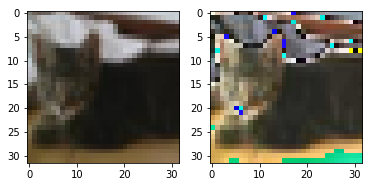

In [18]:
# plot original raw image against normalized image
plt.figure()
plt.subplot(121)
plt.imshow(np.asarray(raw_dataset[img_id][0]))
plt.subplot(122)
plt.imshow(test_sample[0].numpy()[0].transpose(1,2,0))

In [19]:
# single pass though networks
netD.zero_grad()
real_cpu, _ = test_sample
batch_size = real_cpu.size(0)
if torch.cuda.is_available():
    real_cpu = real_cpu.cuda()
input.resize_as_(real_cpu).copy_(real_cpu)
label.resize_(batch_size).fill_(real_label)
inputv = Variable(input)
labelv = Variable(label)

In [20]:
output = netD(inputv)
errD_real = criterion(output, labelv)
errD_real.backward()
D_x = output.data.mean()

In [21]:
fake = netG(fixed_noise)
fake.size()

torch.Size([64, 3, 32, 32])

In [22]:
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################                                                                                                                                                                                                              
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))                                                                                                                                                                             
        ###########################                                                                                                                                                                                                               
        # train with real                                                                                                                                                                                                                         
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        if torch.cuda.is_available():
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake                                                                                                                                                                                                                         
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################                                                                                                                                                                                                              
        # (2) Update G network: maximize log(D(G(z)))                                                                                                                                                                                             
        ###########################                                                                                                                                                                                                               
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost                                                                                                                                                     
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)

    # do checkpointing                                                                                                                                                                                                                            
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/25][0/782] Loss_D: 1.6087 Loss_G: 1.2223 D(x): 0.3672 D(G(z)): 0.4178 / 0.3094
[0/25][1/782] Loss_D: 1.4286 Loss_G: 1.1957 D(x): 0.4532 D(G(z)): 0.4403 / 0.3217
[0/25][2/782] Loss_D: 1.3795 Loss_G: 1.1549 D(x): 0.5220 D(G(z)): 0.4846 / 0.3345
[0/25][3/782] Loss_D: 1.2460 Loss_G: 1.2281 D(x): 0.5647 D(G(z)): 0.4614 / 0.3081
[0/25][4/782] Loss_D: 1.2596 Loss_G: 1.2388 D(x): 0.5792 D(G(z)): 0.4780 / 0.3098
[0/25][5/782] Loss_D: 1.2881 Loss_G: 1.1897 D(x): 0.6211 D(G(z)): 0.5208 / 0.3254
[0/25][6/782] Loss_D: 1.1775 Loss_G: 1.3588 D(x): 0.6202 D(G(z)): 0.4717 / 0.2771
[0/25][7/782] Loss_D: 1.0645 Loss_G: 1.4926 D(x): 0.6340 D(G(z)): 0.4287 / 0.2432
[0/25][8/782] Loss_D: 1.1019 Loss_G: 1.4827 D(x): 0.6194 D(G(z)): 0.4369 / 0.2409
[0/25][9/782] Loss_D: 0.9458 Loss_G: 1.6488 D(x): 0.6551 D(G(z)): 0.3741 / 0.2059
[0/25][10/782] Loss_D: 0.9842 Loss_G: 1.6081 D(x): 0.6321 D(G(z)): 0.3798 / 0.2144
[0/25][11/782] Loss_D: 0.9485 Loss_G: 1.5586 D(x): 0.7061 D(G(z)): 0.4238 / 0.2283
[0/25][12/782]

[0/25][101/782] Loss_D: 0.2715 Loss_G: 3.5415 D(x): 0.9142 D(G(z)): 0.1591 / 0.0348
[0/25][102/782] Loss_D: 0.3643 Loss_G: 3.2486 D(x): 0.8192 D(G(z)): 0.0952 / 0.0483
[0/25][103/782] Loss_D: 0.3778 Loss_G: 3.0543 D(x): 0.8507 D(G(z)): 0.1645 / 0.0601
[0/25][104/782] Loss_D: 0.4100 Loss_G: 3.6641 D(x): 0.8875 D(G(z)): 0.2193 / 0.0324
[0/25][105/782] Loss_D: 0.3240 Loss_G: 3.4058 D(x): 0.8357 D(G(z)): 0.1148 / 0.0398
[0/25][106/782] Loss_D: 0.2823 Loss_G: 3.4169 D(x): 0.8791 D(G(z)): 0.1291 / 0.0387
[0/25][107/782] Loss_D: 0.3412 Loss_G: 3.8903 D(x): 0.8921 D(G(z)): 0.1866 / 0.0266
[0/25][108/782] Loss_D: 0.3412 Loss_G: 3.1582 D(x): 0.7954 D(G(z)): 0.0803 / 0.0522
[0/25][109/782] Loss_D: 0.3375 Loss_G: 3.4223 D(x): 0.8984 D(G(z)): 0.1900 / 0.0436
[0/25][110/782] Loss_D: 0.4232 Loss_G: 3.2800 D(x): 0.8082 D(G(z)): 0.1567 / 0.0467
[0/25][111/782] Loss_D: 0.3921 Loss_G: 3.5236 D(x): 0.8315 D(G(z)): 0.1584 / 0.0386
[0/25][112/782] Loss_D: 0.3567 Loss_G: 3.2266 D(x): 0.8491 D(G(z)): 0.1538 /

[0/25][200/782] Loss_D: 0.1723 Loss_G: 5.2563 D(x): 0.9409 D(G(z)): 0.0998 / 0.0062
[0/25][201/782] Loss_D: 0.1486 Loss_G: 4.9166 D(x): 0.9155 D(G(z)): 0.0540 / 0.0085
[0/25][202/782] Loss_D: 0.1621 Loss_G: 4.6272 D(x): 0.9144 D(G(z)): 0.0639 / 0.0124
[0/25][203/782] Loss_D: 0.2034 Loss_G: 5.3880 D(x): 0.9302 D(G(z)): 0.1131 / 0.0057
[0/25][204/782] Loss_D: 0.1945 Loss_G: 5.3000 D(x): 0.8908 D(G(z)): 0.0631 / 0.0062
[0/25][205/782] Loss_D: 0.2923 Loss_G: 5.6900 D(x): 0.8797 D(G(z)): 0.1243 / 0.0048
[0/25][206/782] Loss_D: 0.3222 Loss_G: 6.5208 D(x): 0.8789 D(G(z)): 0.1506 / 0.0018
[0/25][207/782] Loss_D: 0.1744 Loss_G: 5.7559 D(x): 0.8950 D(G(z)): 0.0506 / 0.0040
[0/25][208/782] Loss_D: 0.2873 Loss_G: 5.1711 D(x): 0.8591 D(G(z)): 0.0916 / 0.0068
[0/25][209/782] Loss_D: 0.1952 Loss_G: 6.1168 D(x): 0.9250 D(G(z)): 0.0991 / 0.0029
[0/25][210/782] Loss_D: 0.2146 Loss_G: 5.2369 D(x): 0.8556 D(G(z)): 0.0273 / 0.0063
[0/25][211/782] Loss_D: 0.0854 Loss_G: 5.2806 D(x): 0.9648 D(G(z)): 0.0466 /

[0/25][304/782] Loss_D: 0.6812 Loss_G: 2.7182 D(x): 0.7983 D(G(z)): 0.3398 / 0.0874
[0/25][305/782] Loss_D: 0.5629 Loss_G: 3.0989 D(x): 0.7872 D(G(z)): 0.2468 / 0.0566
[0/25][306/782] Loss_D: 0.3617 Loss_G: 3.5392 D(x): 0.8675 D(G(z)): 0.1785 / 0.0361
[0/25][307/782] Loss_D: 0.6934 Loss_G: 1.7051 D(x): 0.6011 D(G(z)): 0.1053 / 0.2146
[0/25][308/782] Loss_D: 0.8061 Loss_G: 4.1694 D(x): 0.8966 D(G(z)): 0.4581 / 0.0202
[0/25][309/782] Loss_D: 0.4233 Loss_G: 3.4837 D(x): 0.7515 D(G(z)): 0.0938 / 0.0402
[0/25][310/782] Loss_D: 0.6200 Loss_G: 1.8123 D(x): 0.6638 D(G(z)): 0.1343 / 0.1925
[0/25][311/782] Loss_D: 0.9035 Loss_G: 4.3147 D(x): 0.9076 D(G(z)): 0.5070 / 0.0181
[0/25][312/782] Loss_D: 1.0655 Loss_G: 2.0615 D(x): 0.4494 D(G(z)): 0.0638 / 0.1597
[0/25][313/782] Loss_D: 0.6928 Loss_G: 3.0476 D(x): 0.8701 D(G(z)): 0.3891 / 0.0603
[0/25][314/782] Loss_D: 0.4963 Loss_G: 3.6397 D(x): 0.8123 D(G(z)): 0.2229 / 0.0362
[0/25][315/782] Loss_D: 0.5987 Loss_G: 2.8628 D(x): 0.7163 D(G(z)): 0.1640 /

[0/25][410/782] Loss_D: 0.5207 Loss_G: 5.0319 D(x): 0.8438 D(G(z)): 0.2695 / 0.0094
[0/25][411/782] Loss_D: 0.4726 Loss_G: 3.9269 D(x): 0.7356 D(G(z)): 0.0646 / 0.0252
[0/25][412/782] Loss_D: 0.3818 Loss_G: 3.6020 D(x): 0.8490 D(G(z)): 0.1681 / 0.0342
[0/25][413/782] Loss_D: 0.4208 Loss_G: 4.1023 D(x): 0.8377 D(G(z)): 0.1894 / 0.0202
[0/25][414/782] Loss_D: 0.3237 Loss_G: 4.4548 D(x): 0.8780 D(G(z)): 0.1417 / 0.0185
[0/25][415/782] Loss_D: 0.3621 Loss_G: 3.6774 D(x): 0.8141 D(G(z)): 0.1124 / 0.0321
[0/25][416/782] Loss_D: 0.4593 Loss_G: 3.9465 D(x): 0.8294 D(G(z)): 0.1964 / 0.0241
[0/25][417/782] Loss_D: 0.4234 Loss_G: 4.2448 D(x): 0.8306 D(G(z)): 0.1884 / 0.0220
[0/25][418/782] Loss_D: 0.4363 Loss_G: 4.6542 D(x): 0.8516 D(G(z)): 0.1922 / 0.0152
[0/25][419/782] Loss_D: 0.7626 Loss_G: 3.3774 D(x): 0.6664 D(G(z)): 0.1931 / 0.0438
[0/25][420/782] Loss_D: 1.0329 Loss_G: 6.4554 D(x): 0.7851 D(G(z)): 0.4796 / 0.0023
[0/25][421/782] Loss_D: 0.8939 Loss_G: 4.3461 D(x): 0.5056 D(G(z)): 0.0289 /

[0/25][516/782] Loss_D: 0.5708 Loss_G: 2.3293 D(x): 0.6544 D(G(z)): 0.0807 / 0.1279
[0/25][517/782] Loss_D: 0.6753 Loss_G: 3.6480 D(x): 0.8744 D(G(z)): 0.3797 / 0.0308
[0/25][518/782] Loss_D: 0.3655 Loss_G: 3.4827 D(x): 0.7776 D(G(z)): 0.0901 / 0.0394
[0/25][519/782] Loss_D: 0.3369 Loss_G: 3.0419 D(x): 0.8411 D(G(z)): 0.1340 / 0.0574
[0/25][520/782] Loss_D: 0.3615 Loss_G: 2.8797 D(x): 0.8310 D(G(z)): 0.1408 / 0.0726
[0/25][521/782] Loss_D: 0.3314 Loss_G: 3.3692 D(x): 0.9032 D(G(z)): 0.1936 / 0.0426
[0/25][522/782] Loss_D: 0.3703 Loss_G: 3.0801 D(x): 0.8088 D(G(z)): 0.1209 / 0.0549
[0/25][523/782] Loss_D: 0.4199 Loss_G: 2.7522 D(x): 0.8196 D(G(z)): 0.1758 / 0.0782
[0/25][524/782] Loss_D: 0.3694 Loss_G: 3.1977 D(x): 0.8620 D(G(z)): 0.1776 / 0.0509
[0/25][525/782] Loss_D: 0.4164 Loss_G: 2.9425 D(x): 0.7856 D(G(z)): 0.1349 / 0.0707
[0/25][526/782] Loss_D: 0.4212 Loss_G: 2.8952 D(x): 0.8272 D(G(z)): 0.1791 / 0.0712
[0/25][527/782] Loss_D: 0.4142 Loss_G: 2.7148 D(x): 0.7810 D(G(z)): 0.1254 /

[0/25][622/782] Loss_D: 0.6389 Loss_G: 4.0450 D(x): 0.8623 D(G(z)): 0.3559 / 0.0230
[0/25][623/782] Loss_D: 0.4502 Loss_G: 3.3924 D(x): 0.7377 D(G(z)): 0.0992 / 0.0491
[0/25][624/782] Loss_D: 0.6128 Loss_G: 3.4297 D(x): 0.7857 D(G(z)): 0.2628 / 0.0609
[0/25][625/782] Loss_D: 0.6663 Loss_G: 3.1550 D(x): 0.7256 D(G(z)): 0.2115 / 0.0616
[0/25][626/782] Loss_D: 0.7978 Loss_G: 4.3402 D(x): 0.7744 D(G(z)): 0.3440 / 0.0196
[0/25][627/782] Loss_D: 0.4945 Loss_G: 3.3493 D(x): 0.6980 D(G(z)): 0.0771 / 0.0506
[0/25][628/782] Loss_D: 0.5185 Loss_G: 3.8462 D(x): 0.8487 D(G(z)): 0.2678 / 0.0295
[0/25][629/782] Loss_D: 0.4924 Loss_G: 3.5242 D(x): 0.7729 D(G(z)): 0.1613 / 0.0455
[0/25][630/782] Loss_D: 0.3890 Loss_G: 4.2487 D(x): 0.8802 D(G(z)): 0.1980 / 0.0203
[0/25][631/782] Loss_D: 0.3305 Loss_G: 3.6663 D(x): 0.7947 D(G(z)): 0.0683 / 0.0390
[0/25][632/782] Loss_D: 0.4406 Loss_G: 3.3413 D(x): 0.8115 D(G(z)): 0.1647 / 0.0514
[0/25][633/782] Loss_D: 0.4139 Loss_G: 4.4227 D(x): 0.8974 D(G(z)): 0.2330 /

[0/25][728/782] Loss_D: 0.9296 Loss_G: 4.7984 D(x): 0.8301 D(G(z)): 0.4740 / 0.0140
[0/25][729/782] Loss_D: 1.1748 Loss_G: 0.4724 D(x): 0.4359 D(G(z)): 0.0498 / 0.6922
[0/25][730/782] Loss_D: 1.6743 Loss_G: 4.9931 D(x): 0.9342 D(G(z)): 0.6856 / 0.0162
[0/25][731/782] Loss_D: 0.8649 Loss_G: 1.0388 D(x): 0.5314 D(G(z)): 0.0354 / 0.4497
[0/25][732/782] Loss_D: 1.2892 Loss_G: 2.4462 D(x): 0.8725 D(G(z)): 0.5852 / 0.1432
[0/25][733/782] Loss_D: 1.3756 Loss_G: 1.9523 D(x): 0.5019 D(G(z)): 0.2770 / 0.2002
[0/25][734/782] Loss_D: 0.9506 Loss_G: 2.7913 D(x): 0.7618 D(G(z)): 0.4174 / 0.0893
[0/25][735/782] Loss_D: 0.9359 Loss_G: 2.1280 D(x): 0.5472 D(G(z)): 0.1619 / 0.1782
[0/25][736/782] Loss_D: 0.6631 Loss_G: 3.1433 D(x): 0.8934 D(G(z)): 0.3610 / 0.0747
[0/25][737/782] Loss_D: 0.7399 Loss_G: 2.6945 D(x): 0.6863 D(G(z)): 0.2103 / 0.1091
[0/25][738/782] Loss_D: 0.5455 Loss_G: 2.3751 D(x): 0.7564 D(G(z)): 0.1807 / 0.1280
[0/25][739/782] Loss_D: 0.8390 Loss_G: 2.8623 D(x): 0.7411 D(G(z)): 0.3434 /

[1/25][52/782] Loss_D: 0.5545 Loss_G: 2.5489 D(x): 0.7786 D(G(z)): 0.2274 / 0.0982
[1/25][53/782] Loss_D: 0.5857 Loss_G: 3.1834 D(x): 0.7795 D(G(z)): 0.2438 / 0.0573
[1/25][54/782] Loss_D: 0.3556 Loss_G: 3.0208 D(x): 0.8306 D(G(z)): 0.1248 / 0.0758
[1/25][55/782] Loss_D: 0.4613 Loss_G: 3.2138 D(x): 0.8364 D(G(z)): 0.1949 / 0.0589
[1/25][56/782] Loss_D: 0.4993 Loss_G: 2.4143 D(x): 0.7531 D(G(z)): 0.1493 / 0.1127
[1/25][57/782] Loss_D: 0.4357 Loss_G: 2.6809 D(x): 0.8482 D(G(z)): 0.2035 / 0.0958
[1/25][58/782] Loss_D: 0.5443 Loss_G: 3.0828 D(x): 0.8208 D(G(z)): 0.2337 / 0.0713
[1/25][59/782] Loss_D: 0.4675 Loss_G: 2.9869 D(x): 0.7716 D(G(z)): 0.1601 / 0.0842
[1/25][60/782] Loss_D: 0.3913 Loss_G: 3.1251 D(x): 0.8567 D(G(z)): 0.1791 / 0.0653
[1/25][61/782] Loss_D: 0.4529 Loss_G: 2.6090 D(x): 0.7656 D(G(z)): 0.1294 / 0.1279
[1/25][62/782] Loss_D: 0.4502 Loss_G: 2.8961 D(x): 0.8543 D(G(z)): 0.2055 / 0.0848
[1/25][63/782] Loss_D: 0.6637 Loss_G: 2.4247 D(x): 0.7308 D(G(z)): 0.1999 / 0.1353
[1/2

[1/25][158/782] Loss_D: 0.5703 Loss_G: 3.2636 D(x): 0.8442 D(G(z)): 0.2844 / 0.0527
[1/25][159/782] Loss_D: 0.6404 Loss_G: 3.0091 D(x): 0.7274 D(G(z)): 0.2280 / 0.0644
[1/25][160/782] Loss_D: 0.5406 Loss_G: 2.6496 D(x): 0.7462 D(G(z)): 0.1539 / 0.0916
[1/25][161/782] Loss_D: 0.5011 Loss_G: 3.4705 D(x): 0.8601 D(G(z)): 0.2718 / 0.0441
[1/25][162/782] Loss_D: 0.4372 Loss_G: 3.2863 D(x): 0.8008 D(G(z)): 0.1559 / 0.0556
[1/25][163/782] Loss_D: 0.3868 Loss_G: 3.3745 D(x): 0.8569 D(G(z)): 0.1826 / 0.0483
[1/25][164/782] Loss_D: 0.4323 Loss_G: 2.9566 D(x): 0.7781 D(G(z)): 0.1333 / 0.0743
[1/25][165/782] Loss_D: 0.5730 Loss_G: 3.0080 D(x): 0.8044 D(G(z)): 0.2587 / 0.0698
[1/25][166/782] Loss_D: 0.6051 Loss_G: 2.6420 D(x): 0.7191 D(G(z)): 0.1848 / 0.0996
[1/25][167/782] Loss_D: 0.5354 Loss_G: 2.4595 D(x): 0.7574 D(G(z)): 0.1594 / 0.1194
[1/25][168/782] Loss_D: 0.8652 Loss_G: 4.0950 D(x): 0.8236 D(G(z)): 0.4436 / 0.0248
[1/25][169/782] Loss_D: 0.5674 Loss_G: 3.3000 D(x): 0.6616 D(G(z)): 0.0705 /

[1/25][264/782] Loss_D: 0.5718 Loss_G: 1.9143 D(x): 0.7090 D(G(z)): 0.1572 / 0.1854
[1/25][265/782] Loss_D: 0.6302 Loss_G: 2.9564 D(x): 0.8109 D(G(z)): 0.2892 / 0.0752
[1/25][266/782] Loss_D: 0.4066 Loss_G: 2.7451 D(x): 0.8549 D(G(z)): 0.1950 / 0.0967
[1/25][267/782] Loss_D: 0.4354 Loss_G: 2.4905 D(x): 0.7943 D(G(z)): 0.1585 / 0.1133
[1/25][268/782] Loss_D: 0.5955 Loss_G: 2.9195 D(x): 0.7573 D(G(z)): 0.2316 / 0.0645
[1/25][269/782] Loss_D: 0.4703 Loss_G: 2.3008 D(x): 0.7321 D(G(z)): 0.1074 / 0.1222
[1/25][270/782] Loss_D: 0.3681 Loss_G: 2.5547 D(x): 0.8944 D(G(z)): 0.2080 / 0.0983
[1/25][271/782] Loss_D: 0.3939 Loss_G: 2.9654 D(x): 0.8365 D(G(z)): 0.1689 / 0.0625
[1/25][272/782] Loss_D: 0.3351 Loss_G: 2.4779 D(x): 0.8063 D(G(z)): 0.0905 / 0.1076
[1/25][273/782] Loss_D: 0.3870 Loss_G: 2.8449 D(x): 0.8914 D(G(z)): 0.2133 / 0.0770
[1/25][274/782] Loss_D: 0.3663 Loss_G: 2.5210 D(x): 0.8139 D(G(z)): 0.1287 / 0.0979
[1/25][275/782] Loss_D: 0.3339 Loss_G: 2.9215 D(x): 0.9131 D(G(z)): 0.2023 /

[1/25][370/782] Loss_D: 0.3748 Loss_G: 2.7179 D(x): 0.8131 D(G(z)): 0.1347 / 0.0837
[1/25][371/782] Loss_D: 0.4015 Loss_G: 2.5946 D(x): 0.8205 D(G(z)): 0.1555 / 0.0918
[1/25][372/782] Loss_D: 0.5820 Loss_G: 2.0257 D(x): 0.7239 D(G(z)): 0.1654 / 0.1666
[1/25][373/782] Loss_D: 0.5519 Loss_G: 3.0267 D(x): 0.8892 D(G(z)): 0.2997 / 0.0686
[1/25][374/782] Loss_D: 0.3390 Loss_G: 3.3218 D(x): 0.8341 D(G(z)): 0.1275 / 0.0503
[1/25][375/782] Loss_D: 0.5849 Loss_G: 2.0127 D(x): 0.6757 D(G(z)): 0.1157 / 0.1753
[1/25][376/782] Loss_D: 0.4939 Loss_G: 3.0926 D(x): 0.9170 D(G(z)): 0.3019 / 0.0683
[1/25][377/782] Loss_D: 0.4215 Loss_G: 3.4390 D(x): 0.8502 D(G(z)): 0.1944 / 0.0460
[1/25][378/782] Loss_D: 0.5105 Loss_G: 2.3523 D(x): 0.7035 D(G(z)): 0.0766 / 0.1243
[1/25][379/782] Loss_D: 0.4596 Loss_G: 2.7143 D(x): 0.8656 D(G(z)): 0.2406 / 0.0866
[1/25][380/782] Loss_D: 0.5149 Loss_G: 3.0300 D(x): 0.8002 D(G(z)): 0.2021 / 0.0653
[1/25][381/782] Loss_D: 0.5810 Loss_G: 2.1879 D(x): 0.7164 D(G(z)): 0.1649 /

[1/25][476/782] Loss_D: 0.3297 Loss_G: 3.3718 D(x): 0.9000 D(G(z)): 0.1788 / 0.0524
[1/25][477/782] Loss_D: 0.3828 Loss_G: 2.8304 D(x): 0.8087 D(G(z)): 0.1291 / 0.0888
[1/25][478/782] Loss_D: 0.5637 Loss_G: 2.6154 D(x): 0.7869 D(G(z)): 0.2227 / 0.1111
[1/25][479/782] Loss_D: 0.6873 Loss_G: 1.9046 D(x): 0.6588 D(G(z)): 0.1719 / 0.1875
[1/25][480/782] Loss_D: 0.7872 Loss_G: 3.2029 D(x): 0.8518 D(G(z)): 0.4013 / 0.0582
[1/25][481/782] Loss_D: 0.5074 Loss_G: 2.3702 D(x): 0.7143 D(G(z)): 0.1044 / 0.1148
[1/25][482/782] Loss_D: 0.6973 Loss_G: 2.1892 D(x): 0.7038 D(G(z)): 0.2410 / 0.1524
[1/25][483/782] Loss_D: 0.5114 Loss_G: 3.3554 D(x): 0.9316 D(G(z)): 0.3035 / 0.0455
[1/25][484/782] Loss_D: 0.4189 Loss_G: 2.8147 D(x): 0.7688 D(G(z)): 0.1006 / 0.0779
[1/25][485/782] Loss_D: 0.6721 Loss_G: 1.7122 D(x): 0.6590 D(G(z)): 0.1534 / 0.2177
[1/25][486/782] Loss_D: 0.7088 Loss_G: 3.1683 D(x): 0.8817 D(G(z)): 0.3937 / 0.0635
[1/25][487/782] Loss_D: 0.5699 Loss_G: 2.6112 D(x): 0.7196 D(G(z)): 0.1376 /

[1/25][582/782] Loss_D: 0.4223 Loss_G: 2.9046 D(x): 0.8301 D(G(z)): 0.1804 / 0.0792
[1/25][583/782] Loss_D: 0.6354 Loss_G: 2.0699 D(x): 0.7123 D(G(z)): 0.1978 / 0.1637
[1/25][584/782] Loss_D: 0.4437 Loss_G: 3.0521 D(x): 0.8975 D(G(z)): 0.2550 / 0.0673
[1/25][585/782] Loss_D: 0.4684 Loss_G: 2.4543 D(x): 0.7474 D(G(z)): 0.1171 / 0.1145
[1/25][586/782] Loss_D: 0.5930 Loss_G: 2.6643 D(x): 0.8029 D(G(z)): 0.2628 / 0.1018
[1/25][587/782] Loss_D: 0.5012 Loss_G: 2.9543 D(x): 0.8189 D(G(z)): 0.2100 / 0.0792
[1/25][588/782] Loss_D: 0.6033 Loss_G: 2.3431 D(x): 0.7362 D(G(z)): 0.2043 / 0.1316
[1/25][589/782] Loss_D: 0.4971 Loss_G: 1.9606 D(x): 0.7672 D(G(z)): 0.1508 / 0.1852
[1/25][590/782] Loss_D: 0.6177 Loss_G: 3.8151 D(x): 0.9040 D(G(z)): 0.3368 / 0.0364
[1/25][591/782] Loss_D: 0.4763 Loss_G: 2.5320 D(x): 0.6954 D(G(z)): 0.0607 / 0.1172
[1/25][592/782] Loss_D: 0.4165 Loss_G: 2.3868 D(x): 0.8616 D(G(z)): 0.2066 / 0.1220
[1/25][593/782] Loss_D: 0.3461 Loss_G: 3.2503 D(x): 0.8837 D(G(z)): 0.1815 /

[1/25][688/782] Loss_D: 0.7302 Loss_G: 1.6981 D(x): 0.5873 D(G(z)): 0.1020 / 0.2613
[1/25][689/782] Loss_D: 0.8193 Loss_G: 3.0069 D(x): 0.8649 D(G(z)): 0.4098 / 0.0823
[1/25][690/782] Loss_D: 0.5980 Loss_G: 2.8634 D(x): 0.7485 D(G(z)): 0.1734 / 0.0963
[1/25][691/782] Loss_D: 0.4250 Loss_G: 2.8382 D(x): 0.8510 D(G(z)): 0.2002 / 0.0874
[1/25][692/782] Loss_D: 0.3064 Loss_G: 2.8657 D(x): 0.8583 D(G(z)): 0.1206 / 0.0774
[1/25][693/782] Loss_D: 0.4037 Loss_G: 2.5836 D(x): 0.8428 D(G(z)): 0.1722 / 0.1002
[1/25][694/782] Loss_D: 0.4391 Loss_G: 2.5988 D(x): 0.8111 D(G(z)): 0.1706 / 0.1118
[1/25][695/782] Loss_D: 0.4382 Loss_G: 2.8778 D(x): 0.8645 D(G(z)): 0.2302 / 0.0733
[1/25][696/782] Loss_D: 0.5288 Loss_G: 2.2305 D(x): 0.7128 D(G(z)): 0.0958 / 0.1466
[1/25][697/782] Loss_D: 0.6174 Loss_G: 2.7108 D(x): 0.8421 D(G(z)): 0.3044 / 0.0967
[1/25][698/782] Loss_D: 0.4471 Loss_G: 2.6426 D(x): 0.7877 D(G(z)): 0.1581 / 0.0918
[1/25][699/782] Loss_D: 0.4065 Loss_G: 2.6164 D(x): 0.8198 D(G(z)): 0.1523 /

[2/25][7/782] Loss_D: 0.4646 Loss_G: 2.2068 D(x): 0.8082 D(G(z)): 0.1950 / 0.1421
[2/25][8/782] Loss_D: 0.3935 Loss_G: 2.6491 D(x): 0.8535 D(G(z)): 0.1889 / 0.0887
[2/25][9/782] Loss_D: 0.3031 Loss_G: 2.9998 D(x): 0.8719 D(G(z)): 0.1408 / 0.0631
[2/25][10/782] Loss_D: 0.5043 Loss_G: 1.9722 D(x): 0.7246 D(G(z)): 0.1229 / 0.1860
[2/25][11/782] Loss_D: 0.5071 Loss_G: 2.5853 D(x): 0.8736 D(G(z)): 0.2731 / 0.0945
[2/25][12/782] Loss_D: 0.4268 Loss_G: 3.1145 D(x): 0.8508 D(G(z)): 0.2052 / 0.0674
[2/25][13/782] Loss_D: 0.5537 Loss_G: 2.1249 D(x): 0.6761 D(G(z)): 0.0997 / 0.1543
[2/25][14/782] Loss_D: 0.4513 Loss_G: 2.3685 D(x): 0.8623 D(G(z)): 0.2316 / 0.1234
[2/25][15/782] Loss_D: 0.5741 Loss_G: 2.6350 D(x): 0.7872 D(G(z)): 0.2483 / 0.0973
[2/25][16/782] Loss_D: 0.4925 Loss_G: 1.9433 D(x): 0.7666 D(G(z)): 0.1507 / 0.1916
[2/25][17/782] Loss_D: 0.5995 Loss_G: 2.7707 D(x): 0.7707 D(G(z)): 0.2404 / 0.0941
[2/25][18/782] Loss_D: 0.4161 Loss_G: 2.3267 D(x): 0.8309 D(G(z)): 0.1691 / 0.1337
[2/25][

[2/25][113/782] Loss_D: 0.6693 Loss_G: 2.3710 D(x): 0.7044 D(G(z)): 0.2195 / 0.1224
[2/25][114/782] Loss_D: 0.7011 Loss_G: 2.4843 D(x): 0.7349 D(G(z)): 0.2696 / 0.1133
[2/25][115/782] Loss_D: 0.5348 Loss_G: 2.3461 D(x): 0.7385 D(G(z)): 0.1656 / 0.1241
[2/25][116/782] Loss_D: 0.5957 Loss_G: 2.2479 D(x): 0.7773 D(G(z)): 0.2454 / 0.1425
[2/25][117/782] Loss_D: 0.4621 Loss_G: 2.8098 D(x): 0.8478 D(G(z)): 0.2255 / 0.0793
[2/25][118/782] Loss_D: 0.5053 Loss_G: 2.4358 D(x): 0.7703 D(G(z)): 0.1761 / 0.1115
[2/25][119/782] Loss_D: 0.6522 Loss_G: 2.4713 D(x): 0.7564 D(G(z)): 0.2701 / 0.1185
[2/25][120/782] Loss_D: 0.7362 Loss_G: 1.7708 D(x): 0.6518 D(G(z)): 0.2012 / 0.2215
[2/25][121/782] Loss_D: 0.5401 Loss_G: 2.3709 D(x): 0.8409 D(G(z)): 0.2755 / 0.1169
[2/25][122/782] Loss_D: 0.6444 Loss_G: 2.9405 D(x): 0.8067 D(G(z)): 0.2969 / 0.0786
[2/25][123/782] Loss_D: 0.5892 Loss_G: 2.3110 D(x): 0.6723 D(G(z)): 0.1207 / 0.1418
[2/25][124/782] Loss_D: 0.5016 Loss_G: 2.4336 D(x): 0.8463 D(G(z)): 0.2464 /

[2/25][219/782] Loss_D: 0.5829 Loss_G: 2.2484 D(x): 0.7752 D(G(z)): 0.2239 / 0.1338
[2/25][220/782] Loss_D: 0.4976 Loss_G: 2.5902 D(x): 0.8225 D(G(z)): 0.2257 / 0.0957
[2/25][221/782] Loss_D: 0.5307 Loss_G: 1.8384 D(x): 0.7037 D(G(z)): 0.1235 / 0.1936
[2/25][222/782] Loss_D: 0.3602 Loss_G: 2.4976 D(x): 0.9000 D(G(z)): 0.2080 / 0.1003
[2/25][223/782] Loss_D: 0.4340 Loss_G: 3.0172 D(x): 0.8975 D(G(z)): 0.2469 / 0.0642
[2/25][224/782] Loss_D: 0.4022 Loss_G: 2.6233 D(x): 0.7484 D(G(z)): 0.0731 / 0.0991
[2/25][225/782] Loss_D: 0.3472 Loss_G: 2.3174 D(x): 0.8371 D(G(z)): 0.1391 / 0.1254
[2/25][226/782] Loss_D: 0.4026 Loss_G: 2.4525 D(x): 0.8492 D(G(z)): 0.1851 / 0.1107
[2/25][227/782] Loss_D: 0.2330 Loss_G: 2.9743 D(x): 0.9093 D(G(z)): 0.1212 / 0.0634
[2/25][228/782] Loss_D: 0.4415 Loss_G: 2.2190 D(x): 0.7644 D(G(z)): 0.1264 / 0.1354
[2/25][229/782] Loss_D: 0.3745 Loss_G: 2.2964 D(x): 0.8342 D(G(z)): 0.1582 / 0.1256
[2/25][230/782] Loss_D: 0.4546 Loss_G: 3.3394 D(x): 0.9421 D(G(z)): 0.2936 /

[2/25][325/782] Loss_D: 0.5171 Loss_G: 2.9082 D(x): 0.7508 D(G(z)): 0.1404 / 0.0771
[2/25][326/782] Loss_D: 0.4262 Loss_G: 3.5323 D(x): 0.8599 D(G(z)): 0.2037 / 0.0450
[2/25][327/782] Loss_D: 0.3884 Loss_G: 3.1702 D(x): 0.8026 D(G(z)): 0.1177 / 0.0678
[2/25][328/782] Loss_D: 0.4102 Loss_G: 3.3903 D(x): 0.8949 D(G(z)): 0.2147 / 0.0578
[2/25][329/782] Loss_D: 0.3938 Loss_G: 4.1050 D(x): 0.8738 D(G(z)): 0.2002 / 0.0249
[2/25][330/782] Loss_D: 0.4645 Loss_G: 2.8342 D(x): 0.7008 D(G(z)): 0.0714 / 0.0877
[2/25][331/782] Loss_D: 0.5090 Loss_G: 3.2264 D(x): 0.8782 D(G(z)): 0.2740 / 0.0591
[2/25][332/782] Loss_D: 0.3676 Loss_G: 3.8325 D(x): 0.8722 D(G(z)): 0.1720 / 0.0338
[2/25][333/782] Loss_D: 0.2469 Loss_G: 3.5474 D(x): 0.8571 D(G(z)): 0.0675 / 0.0455
[2/25][334/782] Loss_D: 0.3617 Loss_G: 3.2258 D(x): 0.8901 D(G(z)): 0.1814 / 0.0590
[2/25][335/782] Loss_D: 0.2969 Loss_G: 2.9912 D(x): 0.8284 D(G(z)): 0.0841 / 0.0628
[2/25][336/782] Loss_D: 0.6070 Loss_G: 3.3781 D(x): 0.8622 D(G(z)): 0.3229 /

[2/25][431/782] Loss_D: 0.3806 Loss_G: 2.5174 D(x): 0.7955 D(G(z)): 0.1054 / 0.1039
[2/25][432/782] Loss_D: 0.3619 Loss_G: 2.4056 D(x): 0.8593 D(G(z)): 0.1725 / 0.1130
[2/25][433/782] Loss_D: 0.3436 Loss_G: 2.9998 D(x): 0.9047 D(G(z)): 0.1983 / 0.0642
[2/25][434/782] Loss_D: 0.4222 Loss_G: 2.6054 D(x): 0.8020 D(G(z)): 0.1541 / 0.0920
[2/25][435/782] Loss_D: 0.5560 Loss_G: 2.6461 D(x): 0.8084 D(G(z)): 0.2508 / 0.0945
[2/25][436/782] Loss_D: 0.2784 Loss_G: 3.0985 D(x): 0.8593 D(G(z)): 0.1097 / 0.0610
[2/25][437/782] Loss_D: 0.2993 Loss_G: 2.9794 D(x): 0.8971 D(G(z)): 0.1609 / 0.0656
[2/25][438/782] Loss_D: 0.4893 Loss_G: 2.2683 D(x): 0.7369 D(G(z)): 0.1275 / 0.1254
[2/25][439/782] Loss_D: 0.5090 Loss_G: 3.1185 D(x): 0.9059 D(G(z)): 0.2910 / 0.0644
[2/25][440/782] Loss_D: 0.5058 Loss_G: 2.4607 D(x): 0.7356 D(G(z)): 0.1468 / 0.1041
[2/25][441/782] Loss_D: 0.4013 Loss_G: 3.0443 D(x): 0.8861 D(G(z)): 0.2086 / 0.0653
[2/25][442/782] Loss_D: 0.4039 Loss_G: 2.9192 D(x): 0.8163 D(G(z)): 0.1616 /

[2/25][537/782] Loss_D: 0.5050 Loss_G: 2.5928 D(x): 0.8436 D(G(z)): 0.2465 / 0.1055
[2/25][538/782] Loss_D: 0.5526 Loss_G: 2.6519 D(x): 0.7572 D(G(z)): 0.1946 / 0.0960
[2/25][539/782] Loss_D: 0.6312 Loss_G: 2.1617 D(x): 0.6871 D(G(z)): 0.1691 / 0.1563
[2/25][540/782] Loss_D: 0.5565 Loss_G: 2.7152 D(x): 0.8188 D(G(z)): 0.2655 / 0.0838
[2/25][541/782] Loss_D: 0.3903 Loss_G: 3.6034 D(x): 0.8703 D(G(z)): 0.2016 / 0.0371
[2/25][542/782] Loss_D: 0.6648 Loss_G: 1.4130 D(x): 0.6025 D(G(z)): 0.0663 / 0.2931
[2/25][543/782] Loss_D: 0.4630 Loss_G: 2.9706 D(x): 0.9374 D(G(z)): 0.3030 / 0.0675
[2/25][544/782] Loss_D: 0.3360 Loss_G: 4.4678 D(x): 0.9442 D(G(z)): 0.2228 / 0.0161
[2/25][545/782] Loss_D: 0.7190 Loss_G: 2.6403 D(x): 0.5527 D(G(z)): 0.0278 / 0.1093
[2/25][546/782] Loss_D: 0.3329 Loss_G: 2.6355 D(x): 0.9491 D(G(z)): 0.2286 / 0.0901
[2/25][547/782] Loss_D: 0.3380 Loss_G: 3.5560 D(x): 0.9242 D(G(z)): 0.1988 / 0.0449
[2/25][548/782] Loss_D: 0.4455 Loss_G: 2.4451 D(x): 0.7264 D(G(z)): 0.0734 /

[2/25][643/782] Loss_D: 0.5463 Loss_G: 1.8885 D(x): 0.7449 D(G(z)): 0.1742 / 0.1919
[2/25][644/782] Loss_D: 0.4688 Loss_G: 2.9766 D(x): 0.8950 D(G(z)): 0.2753 / 0.0654
[2/25][645/782] Loss_D: 0.8797 Loss_G: 1.3197 D(x): 0.5120 D(G(z)): 0.1091 / 0.3470
[2/25][646/782] Loss_D: 0.9567 Loss_G: 2.9992 D(x): 0.8992 D(G(z)): 0.5190 / 0.0695
[2/25][647/782] Loss_D: 0.6072 Loss_G: 2.4357 D(x): 0.6863 D(G(z)): 0.1513 / 0.1171
[2/25][648/782] Loss_D: 0.4643 Loss_G: 1.9029 D(x): 0.7573 D(G(z)): 0.1351 / 0.1854
[2/25][649/782] Loss_D: 0.5816 Loss_G: 2.8297 D(x): 0.8822 D(G(z)): 0.3244 / 0.0808
[2/25][650/782] Loss_D: 0.7111 Loss_G: 1.7998 D(x): 0.6396 D(G(z)): 0.1532 / 0.2035
[2/25][651/782] Loss_D: 0.5136 Loss_G: 1.8745 D(x): 0.8114 D(G(z)): 0.2332 / 0.1866
[2/25][652/782] Loss_D: 0.4916 Loss_G: 2.9197 D(x): 0.8577 D(G(z)): 0.2654 / 0.0713
[2/25][653/782] Loss_D: 0.5348 Loss_G: 2.4543 D(x): 0.7395 D(G(z)): 0.1579 / 0.1207
[2/25][654/782] Loss_D: 0.5511 Loss_G: 2.1817 D(x): 0.7882 D(G(z)): 0.2158 /

[2/25][749/782] Loss_D: 0.7124 Loss_G: 1.7087 D(x): 0.6571 D(G(z)): 0.1749 / 0.2268
[2/25][750/782] Loss_D: 0.6138 Loss_G: 2.5327 D(x): 0.8185 D(G(z)): 0.2941 / 0.1031
[2/25][751/782] Loss_D: 0.6715 Loss_G: 3.1656 D(x): 0.7998 D(G(z)): 0.2962 / 0.0702
[2/25][752/782] Loss_D: 0.5404 Loss_G: 2.0815 D(x): 0.6749 D(G(z)): 0.0936 / 0.1925
[2/25][753/782] Loss_D: 0.5574 Loss_G: 3.2777 D(x): 0.9212 D(G(z)): 0.3343 / 0.0617
[2/25][754/782] Loss_D: 0.6855 Loss_G: 2.2788 D(x): 0.6783 D(G(z)): 0.1868 / 0.1392
[2/25][755/782] Loss_D: 0.5535 Loss_G: 2.0209 D(x): 0.7393 D(G(z)): 0.1741 / 0.1803
[2/25][756/782] Loss_D: 0.5656 Loss_G: 3.3879 D(x): 0.9039 D(G(z)): 0.3229 / 0.0539
[2/25][757/782] Loss_D: 0.5903 Loss_G: 2.5258 D(x): 0.7121 D(G(z)): 0.1612 / 0.1045
[2/25][758/782] Loss_D: 0.5277 Loss_G: 2.0121 D(x): 0.7786 D(G(z)): 0.1983 / 0.1864
[2/25][759/782] Loss_D: 0.6674 Loss_G: 2.9646 D(x): 0.8585 D(G(z)): 0.3486 / 0.0726
[2/25][760/782] Loss_D: 0.6758 Loss_G: 2.0344 D(x): 0.6602 D(G(z)): 0.1421 /

[3/25][70/782] Loss_D: 0.5298 Loss_G: 2.1922 D(x): 0.7839 D(G(z)): 0.2106 / 0.1339
[3/25][71/782] Loss_D: 0.4773 Loss_G: 2.9370 D(x): 0.8684 D(G(z)): 0.2628 / 0.0691
[3/25][72/782] Loss_D: 0.3478 Loss_G: 2.6159 D(x): 0.7867 D(G(z)): 0.0815 / 0.0934
[3/25][73/782] Loss_D: 0.5871 Loss_G: 0.9887 D(x): 0.6901 D(G(z)): 0.1540 / 0.4076
[3/25][74/782] Loss_D: 0.9446 Loss_G: 4.3191 D(x): 0.9365 D(G(z)): 0.5477 / 0.0218
[3/25][75/782] Loss_D: 1.2407 Loss_G: 1.3151 D(x): 0.3765 D(G(z)): 0.0397 / 0.3177
[3/25][76/782] Loss_D: 0.5194 Loss_G: 2.4144 D(x): 0.9260 D(G(z)): 0.3149 / 0.1217
[3/25][77/782] Loss_D: 0.5074 Loss_G: 2.5754 D(x): 0.7846 D(G(z)): 0.1950 / 0.0957
[3/25][78/782] Loss_D: 0.5465 Loss_G: 1.7151 D(x): 0.7001 D(G(z)): 0.1203 / 0.2204
[3/25][79/782] Loss_D: 0.7958 Loss_G: 2.7250 D(x): 0.8652 D(G(z)): 0.4233 / 0.0893
[3/25][80/782] Loss_D: 0.6832 Loss_G: 1.6287 D(x): 0.6121 D(G(z)): 0.1114 / 0.2562
[3/25][81/782] Loss_D: 0.5863 Loss_G: 3.1893 D(x): 0.9211 D(G(z)): 0.3556 / 0.0558
[3/2

[3/25][176/782] Loss_D: 0.8394 Loss_G: 2.6991 D(x): 0.8094 D(G(z)): 0.4110 / 0.0854
[3/25][177/782] Loss_D: 0.6381 Loss_G: 1.7251 D(x): 0.6515 D(G(z)): 0.1333 / 0.2148
[3/25][178/782] Loss_D: 0.7574 Loss_G: 2.2999 D(x): 0.8165 D(G(z)): 0.3777 / 0.1309
[3/25][179/782] Loss_D: 0.6913 Loss_G: 2.1764 D(x): 0.7075 D(G(z)): 0.2213 / 0.1449
[3/25][180/782] Loss_D: 0.4989 Loss_G: 1.6720 D(x): 0.7450 D(G(z)): 0.1515 / 0.2237
[3/25][181/782] Loss_D: 0.6381 Loss_G: 3.1914 D(x): 0.8816 D(G(z)): 0.3575 / 0.0652
[3/25][182/782] Loss_D: 0.8228 Loss_G: 1.0974 D(x): 0.5507 D(G(z)): 0.1057 / 0.3927
[3/25][183/782] Loss_D: 0.8353 Loss_G: 2.3037 D(x): 0.8648 D(G(z)): 0.4466 / 0.1209
[3/25][184/782] Loss_D: 0.7845 Loss_G: 1.8140 D(x): 0.6063 D(G(z)): 0.1711 / 0.2355
[3/25][185/782] Loss_D: 0.6411 Loss_G: 2.3543 D(x): 0.7950 D(G(z)): 0.2846 / 0.1199
[3/25][186/782] Loss_D: 0.4544 Loss_G: 2.4018 D(x): 0.8328 D(G(z)): 0.2080 / 0.1217
[3/25][187/782] Loss_D: 0.7066 Loss_G: 1.3040 D(x): 0.6362 D(G(z)): 0.1648 /

[3/25][282/782] Loss_D: 0.6094 Loss_G: 2.0722 D(x): 0.7770 D(G(z)): 0.2598 / 0.1552
[3/25][283/782] Loss_D: 0.6488 Loss_G: 1.7688 D(x): 0.6993 D(G(z)): 0.1955 / 0.2049
[3/25][284/782] Loss_D: 0.4987 Loss_G: 2.6073 D(x): 0.8594 D(G(z)): 0.2634 / 0.0895
[3/25][285/782] Loss_D: 0.4861 Loss_G: 2.0504 D(x): 0.7501 D(G(z)): 0.1453 / 0.1619
[3/25][286/782] Loss_D: 0.4715 Loss_G: 3.3289 D(x): 0.9103 D(G(z)): 0.2919 / 0.0464
[3/25][287/782] Loss_D: 0.8411 Loss_G: 1.4980 D(x): 0.5190 D(G(z)): 0.0696 / 0.2856
[3/25][288/782] Loss_D: 0.8275 Loss_G: 2.9756 D(x): 0.8479 D(G(z)): 0.4228 / 0.0701
[3/25][289/782] Loss_D: 0.7648 Loss_G: 1.0844 D(x): 0.5733 D(G(z)): 0.1072 / 0.3914
[3/25][290/782] Loss_D: 0.9188 Loss_G: 3.2269 D(x): 0.9092 D(G(z)): 0.4999 / 0.0551
[3/25][291/782] Loss_D: 0.7850 Loss_G: 1.0115 D(x): 0.5767 D(G(z)): 0.1254 / 0.4231
[3/25][292/782] Loss_D: 1.1376 Loss_G: 3.8510 D(x): 0.7996 D(G(z)): 0.5446 / 0.0375
[3/25][293/782] Loss_D: 0.7242 Loss_G: 0.6403 D(x): 0.5870 D(G(z)): 0.1005 /

[3/25][388/782] Loss_D: 0.6687 Loss_G: 1.9199 D(x): 0.6308 D(G(z)): 0.1132 / 0.1792
[3/25][389/782] Loss_D: 0.6981 Loss_G: 1.6739 D(x): 0.7616 D(G(z)): 0.3030 / 0.2286
[3/25][390/782] Loss_D: 0.6735 Loss_G: 1.7839 D(x): 0.7091 D(G(z)): 0.2298 / 0.2046
[3/25][391/782] Loss_D: 0.6711 Loss_G: 2.8833 D(x): 0.8651 D(G(z)): 0.3700 / 0.0732
[3/25][392/782] Loss_D: 0.6004 Loss_G: 1.6827 D(x): 0.6578 D(G(z)): 0.1059 / 0.2291
[3/25][393/782] Loss_D: 0.6417 Loss_G: 2.2899 D(x): 0.8407 D(G(z)): 0.3176 / 0.1338
[3/25][394/782] Loss_D: 0.5867 Loss_G: 2.8178 D(x): 0.7963 D(G(z)): 0.2696 / 0.0769
[3/25][395/782] Loss_D: 0.5900 Loss_G: 1.6258 D(x): 0.6654 D(G(z)): 0.1181 / 0.2477
[3/25][396/782] Loss_D: 0.6435 Loss_G: 2.1921 D(x): 0.8307 D(G(z)): 0.3232 / 0.1388
[3/25][397/782] Loss_D: 0.7224 Loss_G: 2.1646 D(x): 0.7195 D(G(z)): 0.2671 / 0.1557
[3/25][398/782] Loss_D: 0.5013 Loss_G: 1.8697 D(x): 0.7457 D(G(z)): 0.1572 / 0.1830
[3/25][399/782] Loss_D: 0.5712 Loss_G: 1.9191 D(x): 0.7982 D(G(z)): 0.2606 /

[3/25][494/782] Loss_D: 0.4885 Loss_G: 2.3095 D(x): 0.7319 D(G(z)): 0.1248 / 0.1241
[3/25][495/782] Loss_D: 0.6299 Loss_G: 1.2729 D(x): 0.6718 D(G(z)): 0.1450 / 0.3442
[3/25][496/782] Loss_D: 0.6456 Loss_G: 2.7185 D(x): 0.8733 D(G(z)): 0.3665 / 0.0815
[3/25][497/782] Loss_D: 0.4015 Loss_G: 2.5464 D(x): 0.7987 D(G(z)): 0.1383 / 0.1027
[3/25][498/782] Loss_D: 0.5389 Loss_G: 1.8756 D(x): 0.7412 D(G(z)): 0.1744 / 0.1854
[3/25][499/782] Loss_D: 0.4272 Loss_G: 2.2680 D(x): 0.8539 D(G(z)): 0.2136 / 0.1296
[3/25][500/782] Loss_D: 0.5147 Loss_G: 2.1095 D(x): 0.7691 D(G(z)): 0.1902 / 0.1522
[3/25][501/782] Loss_D: 0.4946 Loss_G: 1.6117 D(x): 0.7687 D(G(z)): 0.1698 / 0.2398
[3/25][502/782] Loss_D: 0.6041 Loss_G: 2.9640 D(x): 0.8927 D(G(z)): 0.3518 / 0.0694
[3/25][503/782] Loss_D: 0.7382 Loss_G: 1.6349 D(x): 0.5746 D(G(z)): 0.1043 / 0.2342
[3/25][504/782] Loss_D: 0.5770 Loss_G: 2.1000 D(x): 0.8437 D(G(z)): 0.3013 / 0.1528
[3/25][505/782] Loss_D: 0.6611 Loss_G: 1.7211 D(x): 0.7064 D(G(z)): 0.2323 /

[3/25][600/782] Loss_D: 0.8884 Loss_G: 1.8188 D(x): 0.6391 D(G(z)): 0.2974 / 0.1920
[3/25][601/782] Loss_D: 0.5643 Loss_G: 2.0873 D(x): 0.7846 D(G(z)): 0.2457 / 0.1512
[3/25][602/782] Loss_D: 0.4939 Loss_G: 2.4624 D(x): 0.8377 D(G(z)): 0.2453 / 0.1079
[3/25][603/782] Loss_D: 0.5302 Loss_G: 2.4983 D(x): 0.8127 D(G(z)): 0.2402 / 0.1080
[3/25][604/782] Loss_D: 0.6770 Loss_G: 2.1554 D(x): 0.7468 D(G(z)): 0.2885 / 0.1393
[3/25][605/782] Loss_D: 0.8054 Loss_G: 1.5131 D(x): 0.5836 D(G(z)): 0.1723 / 0.2627
[3/25][606/782] Loss_D: 0.8160 Loss_G: 2.2498 D(x): 0.8092 D(G(z)): 0.4166 / 0.1272
[3/25][607/782] Loss_D: 0.7549 Loss_G: 2.4379 D(x): 0.6775 D(G(z)): 0.2505 / 0.1193
[3/25][608/782] Loss_D: 0.3992 Loss_G: 2.3783 D(x): 0.7783 D(G(z)): 0.1135 / 0.1215
[3/25][609/782] Loss_D: 0.5810 Loss_G: 2.0684 D(x): 0.7707 D(G(z)): 0.2339 / 0.1744
[3/25][610/782] Loss_D: 0.5553 Loss_G: 2.3454 D(x): 0.8368 D(G(z)): 0.2809 / 0.1190
[3/25][611/782] Loss_D: 0.5546 Loss_G: 2.2471 D(x): 0.7591 D(G(z)): 0.2138 /

[3/25][704/782] Loss_D: 0.5144 Loss_G: 1.9937 D(x): 0.8067 D(G(z)): 0.2301 / 0.1708
[3/25][705/782] Loss_D: 0.5872 Loss_G: 2.5804 D(x): 0.8612 D(G(z)): 0.3165 / 0.1013
[3/25][706/782] Loss_D: 0.6557 Loss_G: 1.7125 D(x): 0.6314 D(G(z)): 0.1219 / 0.2286
[3/25][707/782] Loss_D: 0.8636 Loss_G: 1.1895 D(x): 0.6718 D(G(z)): 0.3012 / 0.3365
[3/25][708/782] Loss_D: 1.0202 Loss_G: 2.9584 D(x): 0.8186 D(G(z)): 0.4959 / 0.0707
[3/25][709/782] Loss_D: 0.7703 Loss_G: 1.6275 D(x): 0.5546 D(G(z)): 0.0867 / 0.2244
[3/25][710/782] Loss_D: 0.5151 Loss_G: 2.2825 D(x): 0.8716 D(G(z)): 0.2820 / 0.1374
[3/25][711/782] Loss_D: 0.6694 Loss_G: 1.7207 D(x): 0.6938 D(G(z)): 0.2041 / 0.2280
[3/25][712/782] Loss_D: 0.5390 Loss_G: 2.3528 D(x): 0.8631 D(G(z)): 0.2859 / 0.1288
[3/25][713/782] Loss_D: 0.5674 Loss_G: 1.9051 D(x): 0.7427 D(G(z)): 0.1937 / 0.1808
[3/25][714/782] Loss_D: 0.5372 Loss_G: 1.9979 D(x): 0.7813 D(G(z)): 0.2208 / 0.1731
[3/25][715/782] Loss_D: 0.5810 Loss_G: 2.4171 D(x): 0.8142 D(G(z)): 0.2811 /

[4/25][25/782] Loss_D: 0.6185 Loss_G: 1.6440 D(x): 0.7582 D(G(z)): 0.2476 / 0.2322
[4/25][26/782] Loss_D: 0.6091 Loss_G: 3.0619 D(x): 0.9122 D(G(z)): 0.3736 / 0.0588
[4/25][27/782] Loss_D: 1.1593 Loss_G: 1.3308 D(x): 0.4124 D(G(z)): 0.1001 / 0.3282
[4/25][28/782] Loss_D: 0.8563 Loss_G: 1.8797 D(x): 0.7694 D(G(z)): 0.3994 / 0.1816
[4/25][29/782] Loss_D: 0.4905 Loss_G: 2.5454 D(x): 0.8237 D(G(z)): 0.2300 / 0.0975
[4/25][30/782] Loss_D: 0.4989 Loss_G: 2.0391 D(x): 0.7423 D(G(z)): 0.1473 / 0.1684
[4/25][31/782] Loss_D: 0.4696 Loss_G: 1.7769 D(x): 0.8114 D(G(z)): 0.2031 / 0.2091
[4/25][32/782] Loss_D: 0.7829 Loss_G: 1.9077 D(x): 0.7416 D(G(z)): 0.3274 / 0.1765
[4/25][33/782] Loss_D: 0.5906 Loss_G: 1.9087 D(x): 0.7329 D(G(z)): 0.2087 / 0.1794
[4/25][34/782] Loss_D: 0.5628 Loss_G: 2.7244 D(x): 0.8145 D(G(z)): 0.2643 / 0.0922
[4/25][35/782] Loss_D: 0.7689 Loss_G: 1.4879 D(x): 0.6518 D(G(z)): 0.2251 / 0.2643
[4/25][36/782] Loss_D: 0.5236 Loss_G: 2.3439 D(x): 0.8401 D(G(z)): 0.2609 / 0.1198
[4/2

[4/25][131/782] Loss_D: 0.9689 Loss_G: 2.5204 D(x): 0.8602 D(G(z)): 0.5135 / 0.1029
[4/25][132/782] Loss_D: 0.5404 Loss_G: 1.8802 D(x): 0.7163 D(G(z)): 0.1503 / 0.1852
[4/25][133/782] Loss_D: 0.9039 Loss_G: 1.5755 D(x): 0.6400 D(G(z)): 0.3140 / 0.2510
[4/25][134/782] Loss_D: 0.5579 Loss_G: 2.7093 D(x): 0.7984 D(G(z)): 0.2516 / 0.0903
[4/25][135/782] Loss_D: 0.5251 Loss_G: 1.8052 D(x): 0.7653 D(G(z)): 0.1988 / 0.1985
[4/25][136/782] Loss_D: 0.6910 Loss_G: 1.7170 D(x): 0.7113 D(G(z)): 0.2468 / 0.2116
[4/25][137/782] Loss_D: 0.8344 Loss_G: 2.8843 D(x): 0.7383 D(G(z)): 0.3700 / 0.0704
[4/25][138/782] Loss_D: 0.4832 Loss_G: 2.1242 D(x): 0.7180 D(G(z)): 0.0861 / 0.1522
[4/25][139/782] Loss_D: 0.7753 Loss_G: 1.7189 D(x): 0.6931 D(G(z)): 0.2889 / 0.2202
[4/25][140/782] Loss_D: 0.6279 Loss_G: 3.2127 D(x): 0.8976 D(G(z)): 0.3617 / 0.0548
[4/25][141/782] Loss_D: 0.6474 Loss_G: 2.0971 D(x): 0.6478 D(G(z)): 0.1375 / 0.1680
[4/25][142/782] Loss_D: 0.4268 Loss_G: 2.0881 D(x): 0.8157 D(G(z)): 0.1719 /

[4/25][237/782] Loss_D: 0.5965 Loss_G: 2.2460 D(x): 0.8221 D(G(z)): 0.2947 / 0.1283
[4/25][238/782] Loss_D: 1.1452 Loss_G: 1.2179 D(x): 0.4738 D(G(z)): 0.2392 / 0.3468
[4/25][239/782] Loss_D: 0.7230 Loss_G: 1.9187 D(x): 0.7886 D(G(z)): 0.3445 / 0.1771
[4/25][240/782] Loss_D: 0.6418 Loss_G: 2.0702 D(x): 0.7196 D(G(z)): 0.2325 / 0.1483
[4/25][241/782] Loss_D: 0.7167 Loss_G: 2.0455 D(x): 0.7504 D(G(z)): 0.2989 / 0.1643
[4/25][242/782] Loss_D: 0.7222 Loss_G: 1.5830 D(x): 0.6633 D(G(z)): 0.2186 / 0.2412
[4/25][243/782] Loss_D: 0.4243 Loss_G: 2.3430 D(x): 0.9018 D(G(z)): 0.2570 / 0.1186
[4/25][244/782] Loss_D: 0.6430 Loss_G: 1.8890 D(x): 0.6863 D(G(z)): 0.1938 / 0.1766
[4/25][245/782] Loss_D: 0.5582 Loss_G: 2.2170 D(x): 0.8440 D(G(z)): 0.3000 / 0.1241
[4/25][246/782] Loss_D: 0.2813 Loss_G: 2.8667 D(x): 0.8768 D(G(z)): 0.1253 / 0.0798
[4/25][247/782] Loss_D: 0.7322 Loss_G: 1.3224 D(x): 0.5986 D(G(z)): 0.1440 / 0.3165
[4/25][248/782] Loss_D: 0.8161 Loss_G: 2.7222 D(x): 0.9357 D(G(z)): 0.4952 /

[4/25][343/782] Loss_D: 0.7019 Loss_G: 0.7892 D(x): 0.5876 D(G(z)): 0.0867 / 0.4904
[4/25][344/782] Loss_D: 1.1523 Loss_G: 3.6496 D(x): 0.8514 D(G(z)): 0.5794 / 0.0344
[4/25][345/782] Loss_D: 1.1724 Loss_G: 1.1933 D(x): 0.4002 D(G(z)): 0.0632 / 0.3603
[4/25][346/782] Loss_D: 0.7322 Loss_G: 2.3020 D(x): 0.8240 D(G(z)): 0.3797 / 0.1245
[4/25][347/782] Loss_D: 0.7299 Loss_G: 2.1292 D(x): 0.7014 D(G(z)): 0.2687 / 0.1500
[4/25][348/782] Loss_D: 0.5486 Loss_G: 2.4042 D(x): 0.8234 D(G(z)): 0.2579 / 0.1195
[4/25][349/782] Loss_D: 0.6824 Loss_G: 1.5626 D(x): 0.6514 D(G(z)): 0.1698 / 0.2435
[4/25][350/782] Loss_D: 0.9199 Loss_G: 1.6986 D(x): 0.6742 D(G(z)): 0.3514 / 0.2190
[4/25][351/782] Loss_D: 0.5729 Loss_G: 2.2063 D(x): 0.7634 D(G(z)): 0.2287 / 0.1451
[4/25][352/782] Loss_D: 0.5279 Loss_G: 2.2970 D(x): 0.7940 D(G(z)): 0.2261 / 0.1367
[4/25][353/782] Loss_D: 0.4259 Loss_G: 2.5286 D(x): 0.8195 D(G(z)): 0.1835 / 0.0999
[4/25][354/782] Loss_D: 0.6091 Loss_G: 1.7152 D(x): 0.6867 D(G(z)): 0.1720 /

[4/25][449/782] Loss_D: 0.6145 Loss_G: 1.7575 D(x): 0.6720 D(G(z)): 0.1443 / 0.2037
[4/25][450/782] Loss_D: 0.5895 Loss_G: 2.5151 D(x): 0.8767 D(G(z)): 0.3323 / 0.1007
[4/25][451/782] Loss_D: 0.7047 Loss_G: 1.8145 D(x): 0.6853 D(G(z)): 0.2355 / 0.1961
[4/25][452/782] Loss_D: 0.7228 Loss_G: 0.9795 D(x): 0.6220 D(G(z)): 0.1741 / 0.4035
[4/25][453/782] Loss_D: 1.3747 Loss_G: 2.9457 D(x): 0.8517 D(G(z)): 0.6504 / 0.0748
[4/25][454/782] Loss_D: 0.9996 Loss_G: 0.6388 D(x): 0.4680 D(G(z)): 0.0803 / 0.5794
[4/25][455/782] Loss_D: 1.2214 Loss_G: 3.3073 D(x): 0.9090 D(G(z)): 0.6212 / 0.0491
[4/25][456/782] Loss_D: 1.1268 Loss_G: 1.3187 D(x): 0.4493 D(G(z)): 0.1764 / 0.3267
[4/25][457/782] Loss_D: 1.1925 Loss_G: 2.1025 D(x): 0.6736 D(G(z)): 0.4938 / 0.1473
[4/25][458/782] Loss_D: 0.6877 Loss_G: 2.0012 D(x): 0.6724 D(G(z)): 0.2073 / 0.1679
[4/25][459/782] Loss_D: 0.6224 Loss_G: 1.7386 D(x): 0.6880 D(G(z)): 0.1752 / 0.2155
[4/25][460/782] Loss_D: 0.5850 Loss_G: 2.3962 D(x): 0.8118 D(G(z)): 0.2687 /

[4/25][555/782] Loss_D: 0.5041 Loss_G: 2.7302 D(x): 0.7994 D(G(z)): 0.2067 / 0.0850
[4/25][556/782] Loss_D: 0.6221 Loss_G: 1.7185 D(x): 0.6828 D(G(z)): 0.1591 / 0.2223
[4/25][557/782] Loss_D: 0.6971 Loss_G: 1.8964 D(x): 0.7744 D(G(z)): 0.3154 / 0.1864
[4/25][558/782] Loss_D: 0.4484 Loss_G: 2.7032 D(x): 0.8386 D(G(z)): 0.2078 / 0.0866
[4/25][559/782] Loss_D: 0.6514 Loss_G: 1.8216 D(x): 0.6644 D(G(z)): 0.1642 / 0.2021
[4/25][560/782] Loss_D: 0.8142 Loss_G: 1.9898 D(x): 0.7951 D(G(z)): 0.4092 / 0.1616
[4/25][561/782] Loss_D: 0.8141 Loss_G: 1.4792 D(x): 0.5599 D(G(z)): 0.1506 / 0.2600
[4/25][562/782] Loss_D: 0.7192 Loss_G: 1.4496 D(x): 0.7394 D(G(z)): 0.3053 / 0.2815
[4/25][563/782] Loss_D: 0.8875 Loss_G: 2.3765 D(x): 0.8012 D(G(z)): 0.4390 / 0.1144
[4/25][564/782] Loss_D: 0.6747 Loss_G: 2.0941 D(x): 0.6800 D(G(z)): 0.1854 / 0.1506
[4/25][565/782] Loss_D: 0.6854 Loss_G: 1.2621 D(x): 0.6416 D(G(z)): 0.1702 / 0.3275
[4/25][566/782] Loss_D: 0.8834 Loss_G: 2.6650 D(x): 0.8943 D(G(z)): 0.4912 /

[4/25][661/782] Loss_D: 0.6666 Loss_G: 2.4407 D(x): 0.7712 D(G(z)): 0.2966 / 0.1099
[4/25][662/782] Loss_D: 0.5079 Loss_G: 2.1284 D(x): 0.7227 D(G(z)): 0.1410 / 0.1422
[4/25][663/782] Loss_D: 0.5946 Loss_G: 1.5377 D(x): 0.7155 D(G(z)): 0.1952 / 0.2528
[4/25][664/782] Loss_D: 0.3691 Loss_G: 2.2067 D(x): 0.8957 D(G(z)): 0.2125 / 0.1331
[4/25][665/782] Loss_D: 0.4917 Loss_G: 2.2860 D(x): 0.8222 D(G(z)): 0.2263 / 0.1192
[4/25][666/782] Loss_D: 0.5352 Loss_G: 1.9399 D(x): 0.7588 D(G(z)): 0.2020 / 0.1721
[4/25][667/782] Loss_D: 0.7968 Loss_G: 1.1633 D(x): 0.6095 D(G(z)): 0.2033 / 0.3482
[4/25][668/782] Loss_D: 0.7252 Loss_G: 2.5297 D(x): 0.8740 D(G(z)): 0.4182 / 0.0931
[4/25][669/782] Loss_D: 0.5094 Loss_G: 2.6045 D(x): 0.7647 D(G(z)): 0.1810 / 0.0941
[4/25][670/782] Loss_D: 0.4543 Loss_G: 1.5236 D(x): 0.7286 D(G(z)): 0.1057 / 0.2530
[4/25][671/782] Loss_D: 0.7802 Loss_G: 2.7116 D(x): 0.8858 D(G(z)): 0.4320 / 0.0861
[4/25][672/782] Loss_D: 0.5010 Loss_G: 2.3786 D(x): 0.6992 D(G(z)): 0.1018 /

[4/25][767/782] Loss_D: 0.5495 Loss_G: 2.2512 D(x): 0.7997 D(G(z)): 0.2472 / 0.1274
[4/25][768/782] Loss_D: 0.5727 Loss_G: 1.9072 D(x): 0.6780 D(G(z)): 0.1302 / 0.1824
[4/25][769/782] Loss_D: 0.6291 Loss_G: 2.4996 D(x): 0.9006 D(G(z)): 0.3725 / 0.1048
[4/25][770/782] Loss_D: 0.5480 Loss_G: 2.3682 D(x): 0.7409 D(G(z)): 0.1794 / 0.1204
[4/25][771/782] Loss_D: 0.5455 Loss_G: 1.9706 D(x): 0.7683 D(G(z)): 0.2049 / 0.1698
[4/25][772/782] Loss_D: 0.7528 Loss_G: 1.8791 D(x): 0.6902 D(G(z)): 0.2597 / 0.1889
[4/25][773/782] Loss_D: 0.4817 Loss_G: 2.4122 D(x): 0.8761 D(G(z)): 0.2778 / 0.1098
[4/25][774/782] Loss_D: 0.6965 Loss_G: 2.1301 D(x): 0.6666 D(G(z)): 0.2025 / 0.1479
[4/25][775/782] Loss_D: 0.5954 Loss_G: 1.9713 D(x): 0.7671 D(G(z)): 0.2515 / 0.1721
[4/25][776/782] Loss_D: 0.5961 Loss_G: 1.8636 D(x): 0.7626 D(G(z)): 0.2495 / 0.1854
[4/25][777/782] Loss_D: 0.5255 Loss_G: 2.2719 D(x): 0.8308 D(G(z)): 0.2618 / 0.1308
[4/25][778/782] Loss_D: 0.5096 Loss_G: 2.1281 D(x): 0.7359 D(G(z)): 0.1524 /

[5/25][88/782] Loss_D: 0.6371 Loss_G: 1.9911 D(x): 0.7808 D(G(z)): 0.2884 / 0.1618
[5/25][89/782] Loss_D: 0.3639 Loss_G: 2.4806 D(x): 0.8629 D(G(z)): 0.1769 / 0.1057
[5/25][90/782] Loss_D: 0.3686 Loss_G: 2.3086 D(x): 0.8148 D(G(z)): 0.1361 / 0.1187
[5/25][91/782] Loss_D: 0.5729 Loss_G: 1.7361 D(x): 0.7370 D(G(z)): 0.2038 / 0.2069
[5/25][92/782] Loss_D: 0.4412 Loss_G: 2.2695 D(x): 0.8740 D(G(z)): 0.2446 / 0.1273
[5/25][93/782] Loss_D: 0.5707 Loss_G: 2.3654 D(x): 0.8166 D(G(z)): 0.2875 / 0.1098
[5/25][94/782] Loss_D: 0.6555 Loss_G: 1.8147 D(x): 0.6834 D(G(z)): 0.2003 / 0.1979
[5/25][95/782] Loss_D: 0.5436 Loss_G: 2.0199 D(x): 0.8061 D(G(z)): 0.2469 / 0.1588
[5/25][96/782] Loss_D: 0.5910 Loss_G: 2.2770 D(x): 0.7963 D(G(z)): 0.2750 / 0.1318
[5/25][97/782] Loss_D: 0.8697 Loss_G: 1.3869 D(x): 0.5614 D(G(z)): 0.1999 / 0.2890
[5/25][98/782] Loss_D: 0.9859 Loss_G: 2.1685 D(x): 0.7527 D(G(z)): 0.4679 / 0.1293
[5/25][99/782] Loss_D: 0.6004 Loss_G: 2.0315 D(x): 0.6791 D(G(z)): 0.1469 / 0.1652
[5/2

[5/25][194/782] Loss_D: 0.7941 Loss_G: 2.2514 D(x): 0.7360 D(G(z)): 0.3333 / 0.1315
[5/25][195/782] Loss_D: 0.9850 Loss_G: 1.3232 D(x): 0.5362 D(G(z)): 0.2048 / 0.3077
[5/25][196/782] Loss_D: 0.6856 Loss_G: 2.2806 D(x): 0.8655 D(G(z)): 0.3862 / 0.1218
[5/25][197/782] Loss_D: 0.5224 Loss_G: 2.2912 D(x): 0.7360 D(G(z)): 0.1612 / 0.1306
[5/25][198/782] Loss_D: 0.8316 Loss_G: 1.4549 D(x): 0.6712 D(G(z)): 0.2968 / 0.2717
[5/25][199/782] Loss_D: 0.6708 Loss_G: 1.9669 D(x): 0.7668 D(G(z)): 0.3026 / 0.1678
[5/25][200/782] Loss_D: 0.7227 Loss_G: 1.9141 D(x): 0.7012 D(G(z)): 0.2683 / 0.1826
[5/25][201/782] Loss_D: 0.4953 Loss_G: 1.9007 D(x): 0.7681 D(G(z)): 0.1860 / 0.1752
[5/25][202/782] Loss_D: 0.7352 Loss_G: 1.5294 D(x): 0.7052 D(G(z)): 0.2761 / 0.2448
[5/25][203/782] Loss_D: 0.5981 Loss_G: 2.9004 D(x): 0.9492 D(G(z)): 0.3924 / 0.0681
[5/25][204/782] Loss_D: 1.1666 Loss_G: 1.1780 D(x): 0.4120 D(G(z)): 0.1364 / 0.3636
[5/25][205/782] Loss_D: 0.7881 Loss_G: 1.9827 D(x): 0.8177 D(G(z)): 0.3945 /

[5/25][300/782] Loss_D: 0.6068 Loss_G: 1.8489 D(x): 0.7239 D(G(z)): 0.2159 / 0.1839
[5/25][301/782] Loss_D: 0.5993 Loss_G: 2.1461 D(x): 0.7928 D(G(z)): 0.2766 / 0.1416
[5/25][302/782] Loss_D: 0.5575 Loss_G: 2.0791 D(x): 0.7410 D(G(z)): 0.1976 / 0.1612
[5/25][303/782] Loss_D: 0.6752 Loss_G: 1.7230 D(x): 0.7281 D(G(z)): 0.2609 / 0.2103
[5/25][304/782] Loss_D: 0.5787 Loss_G: 2.0103 D(x): 0.8010 D(G(z)): 0.2522 / 0.1666
[5/25][305/782] Loss_D: 0.5694 Loss_G: 2.1237 D(x): 0.7777 D(G(z)): 0.2378 / 0.1486
[5/25][306/782] Loss_D: 0.8139 Loss_G: 1.6367 D(x): 0.6323 D(G(z)): 0.2467 / 0.2315
[5/25][307/782] Loss_D: 0.6217 Loss_G: 2.0104 D(x): 0.7949 D(G(z)): 0.2911 / 0.1623
[5/25][308/782] Loss_D: 0.6420 Loss_G: 1.9479 D(x): 0.6800 D(G(z)): 0.1736 / 0.1761
[5/25][309/782] Loss_D: 0.3619 Loss_G: 2.4467 D(x): 0.9248 D(G(z)): 0.2334 / 0.1079
[5/25][310/782] Loss_D: 0.4712 Loss_G: 2.4244 D(x): 0.7806 D(G(z)): 0.1808 / 0.1139
[5/25][311/782] Loss_D: 0.4552 Loss_G: 2.0473 D(x): 0.7575 D(G(z)): 0.1406 /

[5/25][404/782] Loss_D: 0.6930 Loss_G: 1.8773 D(x): 0.6932 D(G(z)): 0.2283 / 0.1946
[5/25][405/782] Loss_D: 0.5397 Loss_G: 2.1909 D(x): 0.7954 D(G(z)): 0.2350 / 0.1372
[5/25][406/782] Loss_D: 0.4880 Loss_G: 2.3632 D(x): 0.8012 D(G(z)): 0.2104 / 0.1155
[5/25][407/782] Loss_D: 0.6729 Loss_G: 1.9701 D(x): 0.6832 D(G(z)): 0.2050 / 0.1872
[5/25][408/782] Loss_D: 0.5022 Loss_G: 2.0266 D(x): 0.8173 D(G(z)): 0.2342 / 0.1595
[5/25][409/782] Loss_D: 0.6697 Loss_G: 1.6129 D(x): 0.6778 D(G(z)): 0.1896 / 0.2404
[5/25][410/782] Loss_D: 0.6771 Loss_G: 2.2113 D(x): 0.8266 D(G(z)): 0.3498 / 0.1282
[5/25][411/782] Loss_D: 0.5888 Loss_G: 2.2661 D(x): 0.7483 D(G(z)): 0.2222 / 0.1326
[5/25][412/782] Loss_D: 0.6430 Loss_G: 1.6795 D(x): 0.6529 D(G(z)): 0.1494 / 0.2171
[5/25][413/782] Loss_D: 0.5080 Loss_G: 1.8358 D(x): 0.7914 D(G(z)): 0.2015 / 0.1953
[5/25][414/782] Loss_D: 0.6324 Loss_G: 1.8870 D(x): 0.7888 D(G(z)): 0.2987 / 0.1853
[5/25][415/782] Loss_D: 0.7263 Loss_G: 2.2425 D(x): 0.8103 D(G(z)): 0.3511 /

[5/25][510/782] Loss_D: 0.9251 Loss_G: 2.0278 D(x): 0.7006 D(G(z)): 0.3863 / 0.1628
[5/25][511/782] Loss_D: 0.6622 Loss_G: 2.3586 D(x): 0.7642 D(G(z)): 0.2869 / 0.1225
[5/25][512/782] Loss_D: 0.6832 Loss_G: 1.8642 D(x): 0.6905 D(G(z)): 0.2250 / 0.1855
[5/25][513/782] Loss_D: 0.8189 Loss_G: 1.7481 D(x): 0.6878 D(G(z)): 0.3093 / 0.2081
[5/25][514/782] Loss_D: 0.6716 Loss_G: 2.2165 D(x): 0.7732 D(G(z)): 0.2924 / 0.1392
[5/25][515/782] Loss_D: 0.6131 Loss_G: 1.9859 D(x): 0.6885 D(G(z)): 0.1804 / 0.1656
[5/25][516/782] Loss_D: 0.8309 Loss_G: 1.8268 D(x): 0.7050 D(G(z)): 0.3268 / 0.1998
[5/25][517/782] Loss_D: 0.4832 Loss_G: 2.8127 D(x): 0.8903 D(G(z)): 0.2869 / 0.0733
[5/25][518/782] Loss_D: 0.6280 Loss_G: 2.1221 D(x): 0.6615 D(G(z)): 0.1346 / 0.1525
[5/25][519/782] Loss_D: 0.6629 Loss_G: 1.9226 D(x): 0.7687 D(G(z)): 0.2882 / 0.1863
[5/25][520/782] Loss_D: 0.6485 Loss_G: 2.1263 D(x): 0.7261 D(G(z)): 0.2352 / 0.1550
[5/25][521/782] Loss_D: 0.6692 Loss_G: 2.3057 D(x): 0.7520 D(G(z)): 0.2805 /

[5/25][616/782] Loss_D: 0.7186 Loss_G: 2.2496 D(x): 0.8218 D(G(z)): 0.3641 / 0.1349
[5/25][617/782] Loss_D: 0.4795 Loss_G: 2.5605 D(x): 0.8358 D(G(z)): 0.2360 / 0.0954
[5/25][618/782] Loss_D: 0.5800 Loss_G: 1.8443 D(x): 0.6721 D(G(z)): 0.1094 / 0.1877
[5/25][619/782] Loss_D: 0.4298 Loss_G: 2.0634 D(x): 0.8389 D(G(z)): 0.2023 / 0.1590
[5/25][620/782] Loss_D: 0.6244 Loss_G: 1.9147 D(x): 0.7456 D(G(z)): 0.2464 / 0.1744
[5/25][621/782] Loss_D: 0.4703 Loss_G: 2.1350 D(x): 0.8356 D(G(z)): 0.2262 / 0.1450
[5/25][622/782] Loss_D: 0.5488 Loss_G: 1.7696 D(x): 0.6996 D(G(z)): 0.1465 / 0.2051
[5/25][623/782] Loss_D: 0.5330 Loss_G: 2.0458 D(x): 0.8230 D(G(z)): 0.2626 / 0.1530
[5/25][624/782] Loss_D: 0.4529 Loss_G: 2.2900 D(x): 0.8389 D(G(z)): 0.2182 / 0.1244
[5/25][625/782] Loss_D: 0.4274 Loss_G: 2.3357 D(x): 0.8120 D(G(z)): 0.1723 / 0.1267
[5/25][626/782] Loss_D: 0.5320 Loss_G: 2.1067 D(x): 0.7867 D(G(z)): 0.2208 / 0.1539
[5/25][627/782] Loss_D: 0.4124 Loss_G: 2.2617 D(x): 0.8655 D(G(z)): 0.2184 /

[5/25][722/782] Loss_D: 0.5977 Loss_G: 1.9858 D(x): 0.7423 D(G(z)): 0.2309 / 0.1566
[5/25][723/782] Loss_D: 0.4645 Loss_G: 2.2224 D(x): 0.8209 D(G(z)): 0.2135 / 0.1327
[5/25][724/782] Loss_D: 0.5307 Loss_G: 1.8847 D(x): 0.7383 D(G(z)): 0.1744 / 0.1839
[5/25][725/782] Loss_D: 0.5997 Loss_G: 1.6577 D(x): 0.7414 D(G(z)): 0.2134 / 0.2190
[5/25][726/782] Loss_D: 0.5946 Loss_G: 2.3683 D(x): 0.9036 D(G(z)): 0.3574 / 0.1173
[5/25][727/782] Loss_D: 0.5004 Loss_G: 2.4398 D(x): 0.7548 D(G(z)): 0.1700 / 0.1203
[5/25][728/782] Loss_D: 0.4362 Loss_G: 2.1343 D(x): 0.8006 D(G(z)): 0.1701 / 0.1522
[5/25][729/782] Loss_D: 0.4854 Loss_G: 1.8677 D(x): 0.7636 D(G(z)): 0.1719 / 0.1967
[5/25][730/782] Loss_D: 0.8454 Loss_G: 1.6629 D(x): 0.6871 D(G(z)): 0.3279 / 0.2188
[5/25][731/782] Loss_D: 0.7160 Loss_G: 2.2253 D(x): 0.8055 D(G(z)): 0.3541 / 0.1306
[5/25][732/782] Loss_D: 0.4939 Loss_G: 2.4592 D(x): 0.8153 D(G(z)): 0.2194 / 0.1093
[5/25][733/782] Loss_D: 0.5683 Loss_G: 1.6092 D(x): 0.7067 D(G(z)): 0.1539 /

[6/25][43/782] Loss_D: 0.6806 Loss_G: 2.1012 D(x): 0.7815 D(G(z)): 0.3082 / 0.1584
[6/25][44/782] Loss_D: 0.7316 Loss_G: 1.6123 D(x): 0.6995 D(G(z)): 0.2644 / 0.2281
[6/25][45/782] Loss_D: 0.6016 Loss_G: 2.4913 D(x): 0.8507 D(G(z)): 0.3170 / 0.1069
[6/25][46/782] Loss_D: 0.8605 Loss_G: 1.8116 D(x): 0.6129 D(G(z)): 0.2262 / 0.2030
[6/25][47/782] Loss_D: 0.6312 Loss_G: 2.3092 D(x): 0.8401 D(G(z)): 0.3328 / 0.1322
[6/25][48/782] Loss_D: 0.8673 Loss_G: 1.4428 D(x): 0.5949 D(G(z)): 0.1952 / 0.2977
[6/25][49/782] Loss_D: 0.6479 Loss_G: 3.0583 D(x): 0.9342 D(G(z)): 0.4063 / 0.0599
[6/25][50/782] Loss_D: 0.6486 Loss_G: 2.4814 D(x): 0.6282 D(G(z)): 0.1122 / 0.1200
[6/25][51/782] Loss_D: 0.4803 Loss_G: 2.0205 D(x): 0.7690 D(G(z)): 0.1491 / 0.1760
[6/25][52/782] Loss_D: 0.4973 Loss_G: 1.8534 D(x): 0.7995 D(G(z)): 0.2111 / 0.1887
[6/25][53/782] Loss_D: 0.6499 Loss_G: 2.4222 D(x): 0.7888 D(G(z)): 0.3079 / 0.1126
[6/25][54/782] Loss_D: 0.4858 Loss_G: 2.5022 D(x): 0.7872 D(G(z)): 0.1842 / 0.1139
[6/2

[6/25][149/782] Loss_D: 0.5557 Loss_G: 2.2073 D(x): 0.6843 D(G(z)): 0.1122 / 0.1481
[6/25][150/782] Loss_D: 0.5085 Loss_G: 2.0478 D(x): 0.8460 D(G(z)): 0.2576 / 0.1669
[6/25][151/782] Loss_D: 0.5701 Loss_G: 2.1798 D(x): 0.7816 D(G(z)): 0.2385 / 0.1472
[6/25][152/782] Loss_D: 0.4482 Loss_G: 2.4052 D(x): 0.8072 D(G(z)): 0.1806 / 0.1135
[6/25][153/782] Loss_D: 0.5262 Loss_G: 1.6070 D(x): 0.7006 D(G(z)): 0.1080 / 0.2429
[6/25][154/782] Loss_D: 0.7627 Loss_G: 2.5247 D(x): 0.8529 D(G(z)): 0.4038 / 0.1024
[6/25][155/782] Loss_D: 0.5454 Loss_G: 2.4788 D(x): 0.7630 D(G(z)): 0.1916 / 0.1111
[6/25][156/782] Loss_D: 0.6967 Loss_G: 1.5370 D(x): 0.6159 D(G(z)): 0.1273 / 0.2655
[6/25][157/782] Loss_D: 1.0699 Loss_G: 1.9405 D(x): 0.6991 D(G(z)): 0.4396 / 0.1836
[6/25][158/782] Loss_D: 0.5078 Loss_G: 2.3336 D(x): 0.7875 D(G(z)): 0.2049 / 0.1183
[6/25][159/782] Loss_D: 0.5734 Loss_G: 1.8970 D(x): 0.7595 D(G(z)): 0.2344 / 0.1769
[6/25][160/782] Loss_D: 0.5264 Loss_G: 2.1887 D(x): 0.7850 D(G(z)): 0.2193 /

[6/25][255/782] Loss_D: 0.7186 Loss_G: 1.7468 D(x): 0.7603 D(G(z)): 0.3109 / 0.2223
[6/25][256/782] Loss_D: 0.9424 Loss_G: 2.3637 D(x): 0.6933 D(G(z)): 0.3757 / 0.1260
[6/25][257/782] Loss_D: 0.5168 Loss_G: 2.3933 D(x): 0.7768 D(G(z)): 0.1901 / 0.1198
[6/25][258/782] Loss_D: 0.8075 Loss_G: 1.5075 D(x): 0.6418 D(G(z)): 0.2461 / 0.2811
[6/25][259/782] Loss_D: 0.3617 Loss_G: 2.3339 D(x): 0.8760 D(G(z)): 0.1835 / 0.1347
[6/25][260/782] Loss_D: 0.4426 Loss_G: 2.3941 D(x): 0.8292 D(G(z)): 0.2057 / 0.1106
[6/25][261/782] Loss_D: 0.5996 Loss_G: 2.0548 D(x): 0.7457 D(G(z)): 0.2284 / 0.1636
[6/25][262/782] Loss_D: 0.5598 Loss_G: 1.8929 D(x): 0.7391 D(G(z)): 0.1916 / 0.1975
[6/25][263/782] Loss_D: 0.5047 Loss_G: 2.1271 D(x): 0.8347 D(G(z)): 0.2481 / 0.1477
[6/25][264/782] Loss_D: 0.6156 Loss_G: 2.0743 D(x): 0.7639 D(G(z)): 0.2545 / 0.1584
[6/25][265/782] Loss_D: 0.5117 Loss_G: 2.0025 D(x): 0.7547 D(G(z)): 0.1751 / 0.1705
[6/25][266/782] Loss_D: 0.7545 Loss_G: 1.5459 D(x): 0.6833 D(G(z)): 0.2552 /

[6/25][361/782] Loss_D: 0.7645 Loss_G: 2.4747 D(x): 0.7036 D(G(z)): 0.2732 / 0.1135
[6/25][362/782] Loss_D: 0.5489 Loss_G: 1.2519 D(x): 0.7055 D(G(z)): 0.1333 / 0.3555
[6/25][363/782] Loss_D: 0.8395 Loss_G: 2.9356 D(x): 0.9018 D(G(z)): 0.4744 / 0.0719
[6/25][364/782] Loss_D: 0.7998 Loss_G: 1.8077 D(x): 0.5406 D(G(z)): 0.0822 / 0.1958
[6/25][365/782] Loss_D: 0.5289 Loss_G: 2.1329 D(x): 0.8717 D(G(z)): 0.3005 / 0.1438
[6/25][366/782] Loss_D: 0.5776 Loss_G: 2.1174 D(x): 0.7384 D(G(z)): 0.2106 / 0.1481
[6/25][367/782] Loss_D: 0.4997 Loss_G: 2.5982 D(x): 0.7991 D(G(z)): 0.2176 / 0.1023
[6/25][368/782] Loss_D: 0.3800 Loss_G: 2.3440 D(x): 0.8479 D(G(z)): 0.1824 / 0.1166
[6/25][369/782] Loss_D: 0.5850 Loss_G: 1.6583 D(x): 0.6907 D(G(z)): 0.1438 / 0.2303
[6/25][370/782] Loss_D: 0.5142 Loss_G: 2.3589 D(x): 0.8832 D(G(z)): 0.2963 / 0.1223
[6/25][371/782] Loss_D: 0.4993 Loss_G: 2.4435 D(x): 0.7661 D(G(z)): 0.1646 / 0.1068
[6/25][372/782] Loss_D: 0.5241 Loss_G: 2.1356 D(x): 0.7886 D(G(z)): 0.2124 /

[6/25][467/782] Loss_D: 1.7898 Loss_G: 4.1112 D(x): 0.9576 D(G(z)): 0.7726 / 0.0278
[6/25][468/782] Loss_D: 1.2706 Loss_G: 0.4496 D(x): 0.3523 D(G(z)): 0.0369 / 0.6755
[6/25][469/782] Loss_D: 1.2491 Loss_G: 3.1824 D(x): 0.9367 D(G(z)): 0.6215 / 0.0590
[6/25][470/782] Loss_D: 0.9137 Loss_G: 1.8598 D(x): 0.5442 D(G(z)): 0.1595 / 0.2132
[6/25][471/782] Loss_D: 0.8179 Loss_G: 2.3403 D(x): 0.7942 D(G(z)): 0.3869 / 0.1296
[6/25][472/782] Loss_D: 1.1831 Loss_G: 0.8738 D(x): 0.4505 D(G(z)): 0.1787 / 0.4561
[6/25][473/782] Loss_D: 0.9054 Loss_G: 3.6451 D(x): 0.8748 D(G(z)): 0.4615 / 0.0417
[6/25][474/782] Loss_D: 0.9069 Loss_G: 1.3229 D(x): 0.5424 D(G(z)): 0.1403 / 0.3334
[6/25][475/782] Loss_D: 0.9454 Loss_G: 1.4400 D(x): 0.7175 D(G(z)): 0.4010 / 0.2810
[6/25][476/782] Loss_D: 1.3248 Loss_G: 2.3797 D(x): 0.6875 D(G(z)): 0.5304 / 0.1235
[6/25][477/782] Loss_D: 0.9921 Loss_G: 1.3439 D(x): 0.5029 D(G(z)): 0.1264 / 0.3190
[6/25][478/782] Loss_D: 0.8036 Loss_G: 2.0447 D(x): 0.8031 D(G(z)): 0.3884 /

[6/25][573/782] Loss_D: 0.7459 Loss_G: 2.2567 D(x): 0.8652 D(G(z)): 0.4070 / 0.1319
[6/25][574/782] Loss_D: 0.6125 Loss_G: 2.4162 D(x): 0.7319 D(G(z)): 0.1922 / 0.1246
[6/25][575/782] Loss_D: 0.7497 Loss_G: 1.4706 D(x): 0.6434 D(G(z)): 0.2068 / 0.2795
[6/25][576/782] Loss_D: 0.6959 Loss_G: 2.6576 D(x): 0.8754 D(G(z)): 0.3836 / 0.0984
[6/25][577/782] Loss_D: 0.3926 Loss_G: 2.9377 D(x): 0.8372 D(G(z)): 0.1690 / 0.0742
[6/25][578/782] Loss_D: 0.9382 Loss_G: 1.0078 D(x): 0.5346 D(G(z)): 0.1860 / 0.4017
[6/25][579/782] Loss_D: 0.9265 Loss_G: 2.3997 D(x): 0.8695 D(G(z)): 0.4900 / 0.1258
[6/25][580/782] Loss_D: 0.9226 Loss_G: 2.2705 D(x): 0.6564 D(G(z)): 0.3050 / 0.1321
[6/25][581/782] Loss_D: 1.3816 Loss_G: 0.6503 D(x): 0.3696 D(G(z)): 0.1499 / 0.5725
[6/25][582/782] Loss_D: 1.9983 Loss_G: 2.7481 D(x): 0.8815 D(G(z)): 0.7888 / 0.1015
[6/25][583/782] Loss_D: 0.5735 Loss_G: 3.1516 D(x): 0.6624 D(G(z)): 0.0902 / 0.0631
[6/25][584/782] Loss_D: 0.7145 Loss_G: 1.6202 D(x): 0.6459 D(G(z)): 0.1780 /

[6/25][679/782] Loss_D: 0.8525 Loss_G: 1.3398 D(x): 0.5490 D(G(z)): 0.1388 / 0.3191
[6/25][680/782] Loss_D: 0.6468 Loss_G: 2.3369 D(x): 0.8608 D(G(z)): 0.3390 / 0.1239
[6/25][681/782] Loss_D: 0.6480 Loss_G: 1.9552 D(x): 0.7139 D(G(z)): 0.2222 / 0.1745
[6/25][682/782] Loss_D: 0.6820 Loss_G: 1.9077 D(x): 0.7361 D(G(z)): 0.2614 / 0.1905
[6/25][683/782] Loss_D: 0.6692 Loss_G: 1.7685 D(x): 0.7347 D(G(z)): 0.2650 / 0.2059
[6/25][684/782] Loss_D: 0.7192 Loss_G: 1.6923 D(x): 0.6983 D(G(z)): 0.2535 / 0.2318
[6/25][685/782] Loss_D: 0.6696 Loss_G: 1.7291 D(x): 0.7502 D(G(z)): 0.2647 / 0.2165
[6/25][686/782] Loss_D: 0.8762 Loss_G: 1.9714 D(x): 0.7386 D(G(z)): 0.3886 / 0.1734
[6/25][687/782] Loss_D: 0.6073 Loss_G: 2.2325 D(x): 0.7483 D(G(z)): 0.2377 / 0.1417
[6/25][688/782] Loss_D: 0.8494 Loss_G: 1.2404 D(x): 0.5565 D(G(z)): 0.1454 / 0.3387
[6/25][689/782] Loss_D: 0.8808 Loss_G: 2.3804 D(x): 0.8771 D(G(z)): 0.4862 / 0.1236
[6/25][690/782] Loss_D: 0.5168 Loss_G: 2.2141 D(x): 0.7272 D(G(z)): 0.1500 /

[7/25][0/782] Loss_D: 0.9238 Loss_G: 3.2473 D(x): 0.8290 D(G(z)): 0.4677 / 0.0540
[7/25][1/782] Loss_D: 0.6905 Loss_G: 1.9631 D(x): 0.5733 D(G(z)): 0.0687 / 0.1724
[7/25][2/782] Loss_D: 0.8255 Loss_G: 0.8561 D(x): 0.6401 D(G(z)): 0.2604 / 0.4713
[7/25][3/782] Loss_D: 1.0634 Loss_G: 3.2685 D(x): 0.9407 D(G(z)): 0.5851 / 0.0556
[7/25][4/782] Loss_D: 1.0722 Loss_G: 1.5692 D(x): 0.4512 D(G(z)): 0.1396 / 0.2705
[7/25][5/782] Loss_D: 0.7249 Loss_G: 2.1405 D(x): 0.7768 D(G(z)): 0.3256 / 0.1501
[7/25][6/782] Loss_D: 0.6236 Loss_G: 1.8596 D(x): 0.6910 D(G(z)): 0.1819 / 0.1975
[7/25][7/782] Loss_D: 0.7881 Loss_G: 2.2752 D(x): 0.7640 D(G(z)): 0.3660 / 0.1349
[7/25][8/782] Loss_D: 0.5246 Loss_G: 2.4752 D(x): 0.7985 D(G(z)): 0.2240 / 0.1085
[7/25][9/782] Loss_D: 0.8391 Loss_G: 1.5925 D(x): 0.5891 D(G(z)): 0.1701 / 0.2591
[7/25][10/782] Loss_D: 0.8131 Loss_G: 2.1286 D(x): 0.8416 D(G(z)): 0.3994 / 0.1646
[7/25][11/782] Loss_D: 0.7410 Loss_G: 1.6441 D(x): 0.6961 D(G(z)): 0.2765 / 0.2333
[7/25][12/782]

[7/25][104/782] Loss_D: 0.7841 Loss_G: 1.4346 D(x): 0.6593 D(G(z)): 0.2559 / 0.2833
[7/25][105/782] Loss_D: 0.6070 Loss_G: 2.5248 D(x): 0.8679 D(G(z)): 0.3367 / 0.1019
[7/25][106/782] Loss_D: 0.4475 Loss_G: 2.2775 D(x): 0.7821 D(G(z)): 0.1616 / 0.1229
[7/25][107/782] Loss_D: 0.9540 Loss_G: 1.2990 D(x): 0.5971 D(G(z)): 0.2764 / 0.3161
[7/25][108/782] Loss_D: 0.7994 Loss_G: 1.9793 D(x): 0.7587 D(G(z)): 0.3487 / 0.1769
[7/25][109/782] Loss_D: 0.7582 Loss_G: 1.8284 D(x): 0.6879 D(G(z)): 0.2635 / 0.1959
[7/25][110/782] Loss_D: 0.7898 Loss_G: 1.4315 D(x): 0.6460 D(G(z)): 0.2378 / 0.2790
[7/25][111/782] Loss_D: 1.1939 Loss_G: 3.0046 D(x): 0.8247 D(G(z)): 0.5722 / 0.0670
[7/25][112/782] Loss_D: 1.0079 Loss_G: 1.8036 D(x): 0.4523 D(G(z)): 0.0775 / 0.2275
[7/25][113/782] Loss_D: 0.6484 Loss_G: 2.4726 D(x): 0.8944 D(G(z)): 0.3781 / 0.1045
[7/25][114/782] Loss_D: 0.3976 Loss_G: 2.5828 D(x): 0.7994 D(G(z)): 0.1272 / 0.1032
[7/25][115/782] Loss_D: 0.6509 Loss_G: 1.4423 D(x): 0.6706 D(G(z)): 0.1686 /

[7/25][210/782] Loss_D: 0.7617 Loss_G: 1.6773 D(x): 0.6722 D(G(z)): 0.2413 / 0.2227
[7/25][211/782] Loss_D: 0.6390 Loss_G: 2.8952 D(x): 0.8821 D(G(z)): 0.3727 / 0.0738
[7/25][212/782] Loss_D: 1.1915 Loss_G: 0.9369 D(x): 0.4212 D(G(z)): 0.1556 / 0.4206
[7/25][213/782] Loss_D: 0.7259 Loss_G: 2.1100 D(x): 0.8287 D(G(z)): 0.3782 / 0.1491
[7/25][214/782] Loss_D: 0.5312 Loss_G: 2.5275 D(x): 0.8511 D(G(z)): 0.2832 / 0.1016
[7/25][215/782] Loss_D: 0.8690 Loss_G: 1.1901 D(x): 0.6002 D(G(z)): 0.2409 / 0.3386
[7/25][216/782] Loss_D: 0.5690 Loss_G: 2.7790 D(x): 0.8718 D(G(z)): 0.3203 / 0.0785
[7/25][217/782] Loss_D: 0.7474 Loss_G: 1.4606 D(x): 0.6001 D(G(z)): 0.1449 / 0.2693
[7/25][218/782] Loss_D: 0.6101 Loss_G: 2.6182 D(x): 0.8631 D(G(z)): 0.3345 / 0.0955
[7/25][219/782] Loss_D: 0.7039 Loss_G: 1.6582 D(x): 0.6428 D(G(z)): 0.1769 / 0.2256
[7/25][220/782] Loss_D: 0.7024 Loss_G: 2.2825 D(x): 0.7958 D(G(z)): 0.3497 / 0.1200
[7/25][221/782] Loss_D: 0.6009 Loss_G: 1.9631 D(x): 0.7112 D(G(z)): 0.1850 /

[7/25][316/782] Loss_D: 1.0511 Loss_G: 2.0548 D(x): 0.6167 D(G(z)): 0.3428 / 0.1802
[7/25][317/782] Loss_D: 1.1422 Loss_G: 0.7058 D(x): 0.4793 D(G(z)): 0.2259 / 0.5265
[7/25][318/782] Loss_D: 1.5441 Loss_G: 4.5325 D(x): 0.8892 D(G(z)): 0.6972 / 0.0226
[7/25][319/782] Loss_D: 1.5493 Loss_G: 1.6611 D(x): 0.2972 D(G(z)): 0.0518 / 0.2678
[7/25][320/782] Loss_D: 1.4318 Loss_G: 1.4867 D(x): 0.6024 D(G(z)): 0.4987 / 0.2811
[7/25][321/782] Loss_D: 0.9589 Loss_G: 2.5118 D(x): 0.7042 D(G(z)): 0.3826 / 0.1050
[7/25][322/782] Loss_D: 1.3992 Loss_G: 0.6559 D(x): 0.3849 D(G(z)): 0.2139 / 0.5571
[7/25][323/782] Loss_D: 1.2585 Loss_G: 3.6920 D(x): 0.9034 D(G(z)): 0.6359 / 0.0366
[7/25][324/782] Loss_D: 1.8082 Loss_G: 0.9770 D(x): 0.2272 D(G(z)): 0.0546 / 0.4466
[7/25][325/782] Loss_D: 1.2328 Loss_G: 2.9816 D(x): 0.9185 D(G(z)): 0.6064 / 0.0744
[7/25][326/782] Loss_D: 0.6099 Loss_G: 3.0002 D(x): 0.7970 D(G(z)): 0.2573 / 0.0755
[7/25][327/782] Loss_D: 1.3398 Loss_G: 0.6675 D(x): 0.3588 D(G(z)): 0.0791 /

[7/25][422/782] Loss_D: 0.7099 Loss_G: 2.0775 D(x): 0.7854 D(G(z)): 0.3427 / 0.1471
[7/25][423/782] Loss_D: 0.7153 Loss_G: 2.0051 D(x): 0.7448 D(G(z)): 0.3031 / 0.1619
[7/25][424/782] Loss_D: 0.5733 Loss_G: 1.3445 D(x): 0.6902 D(G(z)): 0.1352 / 0.2963
[7/25][425/782] Loss_D: 0.8251 Loss_G: 2.0347 D(x): 0.7759 D(G(z)): 0.3849 / 0.1620
[7/25][426/782] Loss_D: 0.6206 Loss_G: 2.0268 D(x): 0.7220 D(G(z)): 0.2220 / 0.1631
[7/25][427/782] Loss_D: 0.5607 Loss_G: 1.9144 D(x): 0.7601 D(G(z)): 0.2184 / 0.1827
[7/25][428/782] Loss_D: 0.6136 Loss_G: 1.8681 D(x): 0.7429 D(G(z)): 0.2341 / 0.1898
[7/25][429/782] Loss_D: 0.5392 Loss_G: 2.0228 D(x): 0.8067 D(G(z)): 0.2496 / 0.1535
[7/25][430/782] Loss_D: 0.5796 Loss_G: 2.2194 D(x): 0.8088 D(G(z)): 0.2817 / 0.1292
[7/25][431/782] Loss_D: 0.5787 Loss_G: 1.8905 D(x): 0.7095 D(G(z)): 0.1827 / 0.1810
[7/25][432/782] Loss_D: 0.5700 Loss_G: 1.6023 D(x): 0.7193 D(G(z)): 0.1825 / 0.2330
[7/25][433/782] Loss_D: 0.8730 Loss_G: 1.3610 D(x): 0.6581 D(G(z)): 0.3151 /

[7/25][528/782] Loss_D: 1.0554 Loss_G: 1.0763 D(x): 0.4561 D(G(z)): 0.1335 / 0.3922
[7/25][529/782] Loss_D: 0.7646 Loss_G: 2.5824 D(x): 0.8822 D(G(z)): 0.4354 / 0.0998
[7/25][530/782] Loss_D: 0.6775 Loss_G: 1.9039 D(x): 0.6547 D(G(z)): 0.1650 / 0.1838
[7/25][531/782] Loss_D: 0.5980 Loss_G: 1.8790 D(x): 0.7843 D(G(z)): 0.2604 / 0.1756
[7/25][532/782] Loss_D: 0.6252 Loss_G: 1.8420 D(x): 0.7826 D(G(z)): 0.2800 / 0.1959
[7/25][533/782] Loss_D: 0.6828 Loss_G: 1.8604 D(x): 0.6739 D(G(z)): 0.2126 / 0.1955
[7/25][534/782] Loss_D: 0.7111 Loss_G: 2.3421 D(x): 0.8122 D(G(z)): 0.3518 / 0.1239
[7/25][535/782] Loss_D: 0.8339 Loss_G: 1.2181 D(x): 0.5750 D(G(z)): 0.1686 / 0.3290
[7/25][536/782] Loss_D: 0.5318 Loss_G: 2.5289 D(x): 0.9332 D(G(z)): 0.3399 / 0.1057
[7/25][537/782] Loss_D: 0.4572 Loss_G: 2.5311 D(x): 0.8287 D(G(z)): 0.2094 / 0.0997
[7/25][538/782] Loss_D: 0.5724 Loss_G: 1.8130 D(x): 0.6706 D(G(z)): 0.1152 / 0.1909
[7/25][539/782] Loss_D: 0.9167 Loss_G: 1.4535 D(x): 0.6797 D(G(z)): 0.3618 /

[7/25][634/782] Loss_D: 0.6387 Loss_G: 2.4839 D(x): 0.8203 D(G(z)): 0.3136 / 0.1068
[7/25][635/782] Loss_D: 0.6721 Loss_G: 1.7399 D(x): 0.6074 D(G(z)): 0.1117 / 0.2155
[7/25][636/782] Loss_D: 0.6207 Loss_G: 2.0904 D(x): 0.8577 D(G(z)): 0.3400 / 0.1490
[7/25][637/782] Loss_D: 0.9945 Loss_G: 1.2852 D(x): 0.5742 D(G(z)): 0.2840 / 0.3198
[7/25][638/782] Loss_D: 0.9458 Loss_G: 2.3756 D(x): 0.7540 D(G(z)): 0.4293 / 0.1142
[7/25][639/782] Loss_D: 0.8722 Loss_G: 1.4183 D(x): 0.5379 D(G(z)): 0.1507 / 0.2852
[7/25][640/782] Loss_D: 1.1054 Loss_G: 2.7160 D(x): 0.8336 D(G(z)): 0.5467 / 0.0894
[7/25][641/782] Loss_D: 0.6645 Loss_G: 1.4781 D(x): 0.6057 D(G(z)): 0.1116 / 0.2770
[7/25][642/782] Loss_D: 0.7345 Loss_G: 1.1421 D(x): 0.6496 D(G(z)): 0.2033 / 0.3532
[7/25][643/782] Loss_D: 0.9141 Loss_G: 3.1545 D(x): 0.9245 D(G(z)): 0.5174 / 0.0615
[7/25][644/782] Loss_D: 0.9481 Loss_G: 1.7291 D(x): 0.4744 D(G(z)): 0.0808 / 0.2135
[7/25][645/782] Loss_D: 0.7806 Loss_G: 1.6932 D(x): 0.7684 D(G(z)): 0.3555 /

[7/25][740/782] Loss_D: 0.6631 Loss_G: 1.3599 D(x): 0.6867 D(G(z)): 0.2138 / 0.2948
[7/25][741/782] Loss_D: 1.6379 Loss_G: 3.4154 D(x): 0.8615 D(G(z)): 0.7209 / 0.0485
[7/25][742/782] Loss_D: 1.3480 Loss_G: 1.0615 D(x): 0.3194 D(G(z)): 0.0446 / 0.3974
[7/25][743/782] Loss_D: 0.8533 Loss_G: 1.8043 D(x): 0.7749 D(G(z)): 0.4026 / 0.2020
[7/25][744/782] Loss_D: 0.8231 Loss_G: 2.1823 D(x): 0.6779 D(G(z)): 0.2935 / 0.1417
[7/25][745/782] Loss_D: 0.6917 Loss_G: 1.4888 D(x): 0.6789 D(G(z)): 0.2041 / 0.2607
[7/25][746/782] Loss_D: 0.5836 Loss_G: 1.7891 D(x): 0.7837 D(G(z)): 0.2561 / 0.1925
[7/25][747/782] Loss_D: 0.6783 Loss_G: 2.0212 D(x): 0.7599 D(G(z)): 0.2962 / 0.1686
[7/25][748/782] Loss_D: 0.8009 Loss_G: 2.8135 D(x): 0.7583 D(G(z)): 0.3654 / 0.0813
[7/25][749/782] Loss_D: 0.8592 Loss_G: 1.2041 D(x): 0.5154 D(G(z)): 0.0976 / 0.3453
[7/25][750/782] Loss_D: 0.7195 Loss_G: 2.4165 D(x): 0.9211 D(G(z)): 0.4321 / 0.1165
[7/25][751/782] Loss_D: 0.7688 Loss_G: 1.4891 D(x): 0.5951 D(G(z)): 0.1656 /

[8/25][61/782] Loss_D: 0.6540 Loss_G: 1.8354 D(x): 0.6646 D(G(z)): 0.1744 / 0.1970
[8/25][62/782] Loss_D: 0.7922 Loss_G: 0.9642 D(x): 0.6390 D(G(z)): 0.2373 / 0.4279
[8/25][63/782] Loss_D: 0.8503 Loss_G: 3.8155 D(x): 0.9332 D(G(z)): 0.4977 / 0.0288
[8/25][64/782] Loss_D: 1.4036 Loss_G: 1.0207 D(x): 0.3266 D(G(z)): 0.0587 / 0.4040
[8/25][65/782] Loss_D: 0.8723 Loss_G: 2.5360 D(x): 0.8821 D(G(z)): 0.4783 / 0.0988
[8/25][66/782] Loss_D: 0.4680 Loss_G: 2.5821 D(x): 0.7971 D(G(z)): 0.1903 / 0.0972
[8/25][67/782] Loss_D: 0.9572 Loss_G: 0.8045 D(x): 0.5113 D(G(z)): 0.1825 / 0.5015
[8/25][68/782] Loss_D: 1.2585 Loss_G: 2.5309 D(x): 0.8164 D(G(z)): 0.5709 / 0.1112
[8/25][69/782] Loss_D: 0.9705 Loss_G: 1.4599 D(x): 0.5129 D(G(z)): 0.1697 / 0.2758
[8/25][70/782] Loss_D: 0.6861 Loss_G: 2.1069 D(x): 0.8303 D(G(z)): 0.3560 / 0.1491
[8/25][71/782] Loss_D: 0.7735 Loss_G: 2.0905 D(x): 0.7067 D(G(z)): 0.2984 / 0.1503
[8/25][72/782] Loss_D: 0.7356 Loss_G: 1.3390 D(x): 0.6018 D(G(z)): 0.1607 / 0.3083
[8/2

[8/25][167/782] Loss_D: 0.3597 Loss_G: 2.3093 D(x): 0.8223 D(G(z)): 0.1345 / 0.1253
[8/25][168/782] Loss_D: 0.4239 Loss_G: 2.1013 D(x): 0.8159 D(G(z)): 0.1773 / 0.1496
[8/25][169/782] Loss_D: 0.6622 Loss_G: 1.9553 D(x): 0.7517 D(G(z)): 0.2759 / 0.1764
[8/25][170/782] Loss_D: 0.5723 Loss_G: 1.5990 D(x): 0.7370 D(G(z)): 0.2054 / 0.2352
[8/25][171/782] Loss_D: 0.8968 Loss_G: 2.2657 D(x): 0.7702 D(G(z)): 0.4184 / 0.1284
[8/25][172/782] Loss_D: 1.1880 Loss_G: 1.1563 D(x): 0.4434 D(G(z)): 0.2089 / 0.3534
[8/25][173/782] Loss_D: 0.8075 Loss_G: 2.7474 D(x): 0.8143 D(G(z)): 0.4069 / 0.0891
[8/25][174/782] Loss_D: 0.5654 Loss_G: 2.0004 D(x): 0.7287 D(G(z)): 0.1953 / 0.1585
[8/25][175/782] Loss_D: 0.5310 Loss_G: 1.7832 D(x): 0.7620 D(G(z)): 0.2013 / 0.1998
[8/25][176/782] Loss_D: 0.5633 Loss_G: 1.5060 D(x): 0.7233 D(G(z)): 0.1866 / 0.2639
[8/25][177/782] Loss_D: 0.8333 Loss_G: 2.5000 D(x): 0.8113 D(G(z)): 0.4151 / 0.0999
[8/25][178/782] Loss_D: 0.5189 Loss_G: 2.3758 D(x): 0.7557 D(G(z)): 0.1839 /

[8/25][273/782] Loss_D: 0.6341 Loss_G: 1.5638 D(x): 0.7246 D(G(z)): 0.2318 / 0.2402
[8/25][274/782] Loss_D: 0.4747 Loss_G: 2.1531 D(x): 0.8488 D(G(z)): 0.2422 / 0.1441
[8/25][275/782] Loss_D: 0.4906 Loss_G: 2.3618 D(x): 0.8123 D(G(z)): 0.2219 / 0.1199
[8/25][276/782] Loss_D: 0.6178 Loss_G: 1.9978 D(x): 0.7046 D(G(z)): 0.1959 / 0.1626
[8/25][277/782] Loss_D: 0.4310 Loss_G: 1.9812 D(x): 0.7950 D(G(z)): 0.1614 / 0.1716
[8/25][278/782] Loss_D: 0.5020 Loss_G: 2.2451 D(x): 0.8558 D(G(z)): 0.2705 / 0.1234
[8/25][279/782] Loss_D: 0.5694 Loss_G: 2.2227 D(x): 0.7847 D(G(z)): 0.2493 / 0.1336
[8/25][280/782] Loss_D: 0.4978 Loss_G: 1.7073 D(x): 0.7467 D(G(z)): 0.1634 / 0.2157
[8/25][281/782] Loss_D: 0.6302 Loss_G: 1.6683 D(x): 0.7528 D(G(z)): 0.2539 / 0.2254
[8/25][282/782] Loss_D: 1.0189 Loss_G: 2.6343 D(x): 0.7550 D(G(z)): 0.4731 / 0.0968
[8/25][283/782] Loss_D: 1.1033 Loss_G: 0.9976 D(x): 0.4141 D(G(z)): 0.1017 / 0.4210
[8/25][284/782] Loss_D: 0.9026 Loss_G: 2.6352 D(x): 0.8958 D(G(z)): 0.5105 /

[8/25][379/782] Loss_D: 0.4319 Loss_G: 2.5909 D(x): 0.9393 D(G(z)): 0.2851 / 0.0936
[8/25][380/782] Loss_D: 0.5785 Loss_G: 2.0056 D(x): 0.7184 D(G(z)): 0.1577 / 0.1643
[8/25][381/782] Loss_D: 0.7462 Loss_G: 2.3319 D(x): 0.8363 D(G(z)): 0.3956 / 0.1242
[8/25][382/782] Loss_D: 1.0370 Loss_G: 1.1883 D(x): 0.5150 D(G(z)): 0.2298 / 0.3417
[8/25][383/782] Loss_D: 0.8072 Loss_G: 2.1534 D(x): 0.8098 D(G(z)): 0.4057 / 0.1437
[8/25][384/782] Loss_D: 0.5414 Loss_G: 2.2066 D(x): 0.7225 D(G(z)): 0.1607 / 0.1389
[8/25][385/782] Loss_D: 0.9481 Loss_G: 1.0885 D(x): 0.5716 D(G(z)): 0.2340 / 0.3846
[8/25][386/782] Loss_D: 1.0669 Loss_G: 2.3843 D(x): 0.7546 D(G(z)): 0.4891 / 0.1101
[8/25][387/782] Loss_D: 0.6190 Loss_G: 1.8940 D(x): 0.6829 D(G(z)): 0.1732 / 0.1844
[8/25][388/782] Loss_D: 0.6808 Loss_G: 1.6022 D(x): 0.6967 D(G(z)): 0.2348 / 0.2416
[8/25][389/782] Loss_D: 0.6396 Loss_G: 2.4691 D(x): 0.8463 D(G(z)): 0.3486 / 0.1039
[8/25][390/782] Loss_D: 0.5896 Loss_G: 2.3591 D(x): 0.7606 D(G(z)): 0.2238 /

[8/25][485/782] Loss_D: 1.1018 Loss_G: 3.0496 D(x): 0.8592 D(G(z)): 0.5347 / 0.0670
[8/25][486/782] Loss_D: 0.9978 Loss_G: 1.3166 D(x): 0.4956 D(G(z)): 0.1882 / 0.3087
[8/25][487/782] Loss_D: 0.7704 Loss_G: 0.8383 D(x): 0.6065 D(G(z)): 0.1790 / 0.4804
[8/25][488/782] Loss_D: 1.5382 Loss_G: 3.5518 D(x): 0.9353 D(G(z)): 0.7206 / 0.0496
[8/25][489/782] Loss_D: 0.7023 Loss_G: 0.9931 D(x): 0.6004 D(G(z)): 0.1059 / 0.4422
[8/25][490/782] Loss_D: 1.1152 Loss_G: 3.8258 D(x): 0.7929 D(G(z)): 0.5254 / 0.0322
[8/25][491/782] Loss_D: 0.9790 Loss_G: 0.7912 D(x): 0.4377 D(G(z)): 0.0347 / 0.4909
[8/25][492/782] Loss_D: 1.7201 Loss_G: 4.7719 D(x): 0.9179 D(G(z)): 0.7418 / 0.0168
[8/25][493/782] Loss_D: 1.4492 Loss_G: 1.2681 D(x): 0.3088 D(G(z)): 0.0255 / 0.3360
[8/25][494/782] Loss_D: 1.0177 Loss_G: 1.3219 D(x): 0.7135 D(G(z)): 0.4229 / 0.3103
[8/25][495/782] Loss_D: 0.8515 Loss_G: 4.0088 D(x): 0.8368 D(G(z)): 0.4474 / 0.0249
[8/25][496/782] Loss_D: 1.9214 Loss_G: 0.7120 D(x): 0.1997 D(G(z)): 0.0463 /

[8/25][591/782] Loss_D: 0.5160 Loss_G: 1.7415 D(x): 0.7554 D(G(z)): 0.1702 / 0.2188
[8/25][592/782] Loss_D: 0.7924 Loss_G: 2.9390 D(x): 0.8464 D(G(z)): 0.4263 / 0.0714
[8/25][593/782] Loss_D: 0.9602 Loss_G: 1.4073 D(x): 0.4601 D(G(z)): 0.0842 / 0.2894
[8/25][594/782] Loss_D: 0.7590 Loss_G: 1.1404 D(x): 0.6968 D(G(z)): 0.2730 / 0.3633
[8/25][595/782] Loss_D: 0.9573 Loss_G: 3.3839 D(x): 0.9318 D(G(z)): 0.5484 / 0.0473
[8/25][596/782] Loss_D: 0.8813 Loss_G: 1.2724 D(x): 0.5110 D(G(z)): 0.0773 / 0.3656
[8/25][597/782] Loss_D: 0.8354 Loss_G: 2.9279 D(x): 0.9065 D(G(z)): 0.4635 / 0.0780
[8/25][598/782] Loss_D: 1.1970 Loss_G: 1.5221 D(x): 0.4249 D(G(z)): 0.1070 / 0.2640
[8/25][599/782] Loss_D: 0.8751 Loss_G: 1.6930 D(x): 0.7500 D(G(z)): 0.3945 / 0.2202
[8/25][600/782] Loss_D: 0.7380 Loss_G: 2.2438 D(x): 0.7717 D(G(z)): 0.3326 / 0.1362
[8/25][601/782] Loss_D: 0.5925 Loss_G: 1.9868 D(x): 0.7142 D(G(z)): 0.1890 / 0.1714
[8/25][602/782] Loss_D: 0.8007 Loss_G: 1.5256 D(x): 0.6733 D(G(z)): 0.2864 /

[8/25][697/782] Loss_D: 0.8038 Loss_G: 1.5543 D(x): 0.7220 D(G(z)): 0.3384 / 0.2419
[8/25][698/782] Loss_D: 0.5620 Loss_G: 1.8069 D(x): 0.7357 D(G(z)): 0.1865 / 0.1862
[8/25][699/782] Loss_D: 0.8278 Loss_G: 2.7324 D(x): 0.8759 D(G(z)): 0.4374 / 0.0867
[8/25][700/782] Loss_D: 0.5942 Loss_G: 2.1989 D(x): 0.6585 D(G(z)): 0.1138 / 0.1537
[8/25][701/782] Loss_D: 0.7928 Loss_G: 1.0831 D(x): 0.6089 D(G(z)): 0.1976 / 0.3792
[8/25][702/782] Loss_D: 0.9763 Loss_G: 2.3602 D(x): 0.8951 D(G(z)): 0.5293 / 0.1251
[8/25][703/782] Loss_D: 0.4812 Loss_G: 2.5805 D(x): 0.7431 D(G(z)): 0.1396 / 0.1067
[8/25][704/782] Loss_D: 0.7177 Loss_G: 1.5466 D(x): 0.6410 D(G(z)): 0.1768 / 0.2540
[8/25][705/782] Loss_D: 0.7215 Loss_G: 1.9750 D(x): 0.7849 D(G(z)): 0.3434 / 0.1729
[8/25][706/782] Loss_D: 0.7347 Loss_G: 1.9081 D(x): 0.7061 D(G(z)): 0.2833 / 0.1785
[8/25][707/782] Loss_D: 0.4880 Loss_G: 2.2007 D(x): 0.8051 D(G(z)): 0.2152 / 0.1466
[8/25][708/782] Loss_D: 0.4901 Loss_G: 2.1165 D(x): 0.7601 D(G(z)): 0.1600 /

[9/25][16/782] Loss_D: 0.5674 Loss_G: 1.7084 D(x): 0.6829 D(G(z)): 0.1293 / 0.2234
[9/25][17/782] Loss_D: 0.7714 Loss_G: 2.3451 D(x): 0.8797 D(G(z)): 0.4348 / 0.1190
[9/25][18/782] Loss_D: 0.8353 Loss_G: 1.4962 D(x): 0.6111 D(G(z)): 0.2339 / 0.2631
[9/25][19/782] Loss_D: 0.7439 Loss_G: 1.4979 D(x): 0.7185 D(G(z)): 0.2859 / 0.2704
[9/25][20/782] Loss_D: 0.9943 Loss_G: 2.1266 D(x): 0.6829 D(G(z)): 0.4027 / 0.1492
[9/25][21/782] Loss_D: 0.6817 Loss_G: 1.6877 D(x): 0.6631 D(G(z)): 0.2002 / 0.2132
[9/25][22/782] Loss_D: 0.6553 Loss_G: 1.6169 D(x): 0.7157 D(G(z)): 0.2373 / 0.2362
[9/25][23/782] Loss_D: 0.7689 Loss_G: 2.4370 D(x): 0.8497 D(G(z)): 0.4146 / 0.1071
[9/25][24/782] Loss_D: 0.8043 Loss_G: 1.6718 D(x): 0.5902 D(G(z)): 0.1814 / 0.2175
[9/25][25/782] Loss_D: 0.5324 Loss_G: 1.8485 D(x): 0.8342 D(G(z)): 0.2738 / 0.1838
[9/25][26/782] Loss_D: 0.6271 Loss_G: 1.7978 D(x): 0.7218 D(G(z)): 0.2230 / 0.2008
[9/25][27/782] Loss_D: 0.5868 Loss_G: 2.3678 D(x): 0.8089 D(G(z)): 0.2805 / 0.1144
[9/2

[9/25][122/782] Loss_D: 0.7622 Loss_G: 1.3284 D(x): 0.6126 D(G(z)): 0.1963 / 0.2999
[9/25][123/782] Loss_D: 0.9234 Loss_G: 2.2136 D(x): 0.8286 D(G(z)): 0.4795 / 0.1334
[9/25][124/782] Loss_D: 0.7244 Loss_G: 1.8039 D(x): 0.6036 D(G(z)): 0.1411 / 0.2127
[9/25][125/782] Loss_D: 0.5347 Loss_G: 2.0489 D(x): 0.8488 D(G(z)): 0.2836 / 0.1592
[9/25][126/782] Loss_D: 0.3690 Loss_G: 2.6810 D(x): 0.8680 D(G(z)): 0.1842 / 0.0953
[9/25][127/782] Loss_D: 0.5794 Loss_G: 1.8456 D(x): 0.6840 D(G(z)): 0.1521 / 0.2006
[9/25][128/782] Loss_D: 0.7514 Loss_G: 1.2165 D(x): 0.6505 D(G(z)): 0.2133 / 0.3377
[9/25][129/782] Loss_D: 0.6697 Loss_G: 2.9872 D(x): 0.9353 D(G(z)): 0.4203 / 0.0656
[9/25][130/782] Loss_D: 0.4844 Loss_G: 2.4750 D(x): 0.7438 D(G(z)): 0.1344 / 0.1226
[9/25][131/782] Loss_D: 0.7613 Loss_G: 1.0779 D(x): 0.5886 D(G(z)): 0.1438 / 0.3873
[9/25][132/782] Loss_D: 1.1001 Loss_G: 2.0528 D(x): 0.7716 D(G(z)): 0.5042 / 0.1660
[9/25][133/782] Loss_D: 0.7538 Loss_G: 1.7912 D(x): 0.6450 D(G(z)): 0.2047 /

[9/25][228/782] Loss_D: 0.5872 Loss_G: 2.1352 D(x): 0.8172 D(G(z)): 0.2858 / 0.1443
[9/25][229/782] Loss_D: 0.6090 Loss_G: 2.2084 D(x): 0.7824 D(G(z)): 0.2755 / 0.1310
[9/25][230/782] Loss_D: 0.5044 Loss_G: 1.9894 D(x): 0.7352 D(G(z)): 0.1575 / 0.1578
[9/25][231/782] Loss_D: 0.7661 Loss_G: 1.2385 D(x): 0.6547 D(G(z)): 0.2413 / 0.3240
[9/25][232/782] Loss_D: 0.6005 Loss_G: 2.5915 D(x): 0.8732 D(G(z)): 0.3330 / 0.1048
[9/25][233/782] Loss_D: 0.7559 Loss_G: 1.7011 D(x): 0.6322 D(G(z)): 0.2147 / 0.2188
[9/25][234/782] Loss_D: 0.7802 Loss_G: 1.6233 D(x): 0.7132 D(G(z)): 0.3166 / 0.2243
[9/25][235/782] Loss_D: 0.8571 Loss_G: 1.9190 D(x): 0.7002 D(G(z)): 0.3515 / 0.1807
[9/25][236/782] Loss_D: 0.6793 Loss_G: 1.8200 D(x): 0.6828 D(G(z)): 0.2159 / 0.2003
[9/25][237/782] Loss_D: 0.7215 Loss_G: 1.8315 D(x): 0.7692 D(G(z)): 0.3077 / 0.1996
[9/25][238/782] Loss_D: 0.6349 Loss_G: 1.9509 D(x): 0.7540 D(G(z)): 0.2567 / 0.1686
[9/25][239/782] Loss_D: 0.3736 Loss_G: 2.3733 D(x): 0.8359 D(G(z)): 0.1645 /

[9/25][334/782] Loss_D: 0.6281 Loss_G: 2.1293 D(x): 0.8278 D(G(z)): 0.3222 / 0.1494
[9/25][335/782] Loss_D: 0.6276 Loss_G: 2.1214 D(x): 0.7272 D(G(z)): 0.2301 / 0.1507
[9/25][336/782] Loss_D: 0.8316 Loss_G: 1.2142 D(x): 0.5773 D(G(z)): 0.1907 / 0.3437
[9/25][337/782] Loss_D: 0.7654 Loss_G: 2.2227 D(x): 0.8181 D(G(z)): 0.3940 / 0.1362
[9/25][338/782] Loss_D: 0.6417 Loss_G: 2.0672 D(x): 0.7040 D(G(z)): 0.2109 / 0.1574
[9/25][339/782] Loss_D: 0.7001 Loss_G: 1.6595 D(x): 0.7066 D(G(z)): 0.2586 / 0.2278
[9/25][340/782] Loss_D: 0.7040 Loss_G: 1.9621 D(x): 0.7781 D(G(z)): 0.3246 / 0.1782
[9/25][341/782] Loss_D: 0.5180 Loss_G: 2.1196 D(x): 0.7717 D(G(z)): 0.1987 / 0.1485
[9/25][342/782] Loss_D: 0.6979 Loss_G: 1.5762 D(x): 0.6868 D(G(z)): 0.2434 / 0.2441
[9/25][343/782] Loss_D: 0.6638 Loss_G: 2.0957 D(x): 0.8301 D(G(z)): 0.3476 / 0.1447
[9/25][344/782] Loss_D: 0.7465 Loss_G: 1.6106 D(x): 0.6327 D(G(z)): 0.2111 / 0.2356
[9/25][345/782] Loss_D: 0.4476 Loss_G: 2.2633 D(x): 0.8663 D(G(z)): 0.2393 /

[9/25][440/782] Loss_D: 0.5703 Loss_G: 1.8296 D(x): 0.7556 D(G(z)): 0.1996 / 0.1907
[9/25][441/782] Loss_D: 0.6328 Loss_G: 1.9432 D(x): 0.7764 D(G(z)): 0.2792 / 0.1653
[9/25][442/782] Loss_D: 1.0837 Loss_G: 3.6981 D(x): 0.8644 D(G(z)): 0.5537 / 0.0333
[9/25][443/782] Loss_D: 1.1348 Loss_G: 1.7782 D(x): 0.4022 D(G(z)): 0.0913 / 0.2092
[9/25][444/782] Loss_D: 0.9144 Loss_G: 0.8707 D(x): 0.6131 D(G(z)): 0.2591 / 0.4593
[9/25][445/782] Loss_D: 1.3914 Loss_G: 3.8411 D(x): 0.8044 D(G(z)): 0.6424 / 0.0362
[9/25][446/782] Loss_D: 0.8215 Loss_G: 2.0006 D(x): 0.5190 D(G(z)): 0.0762 / 0.2025
[9/25][447/782] Loss_D: 0.7522 Loss_G: 1.8338 D(x): 0.7699 D(G(z)): 0.3254 / 0.2040
[9/25][448/782] Loss_D: 0.5601 Loss_G: 2.8556 D(x): 0.8602 D(G(z)): 0.2969 / 0.0762
[9/25][449/782] Loss_D: 0.5917 Loss_G: 2.0586 D(x): 0.6805 D(G(z)): 0.1424 / 0.1720
[9/25][450/782] Loss_D: 0.7783 Loss_G: 1.5745 D(x): 0.7148 D(G(z)): 0.2975 / 0.2435
[9/25][451/782] Loss_D: 0.4878 Loss_G: 2.8629 D(x): 0.9638 D(G(z)): 0.3277 /

[9/25][546/782] Loss_D: 0.7489 Loss_G: 1.2527 D(x): 0.6665 D(G(z)): 0.2355 / 0.3199
[9/25][547/782] Loss_D: 0.9656 Loss_G: 2.4516 D(x): 0.7869 D(G(z)): 0.4694 / 0.1009
[9/25][548/782] Loss_D: 0.8003 Loss_G: 1.6823 D(x): 0.5650 D(G(z)): 0.1505 / 0.2292
[9/25][549/782] Loss_D: 0.5999 Loss_G: 1.4708 D(x): 0.7450 D(G(z)): 0.2301 / 0.2712
[9/25][550/782] Loss_D: 0.7640 Loss_G: 2.3581 D(x): 0.8894 D(G(z)): 0.4315 / 0.1205
[9/25][551/782] Loss_D: 0.6117 Loss_G: 2.4500 D(x): 0.7514 D(G(z)): 0.2432 / 0.1145
[9/25][552/782] Loss_D: 0.6361 Loss_G: 1.6791 D(x): 0.6529 D(G(z)): 0.1503 / 0.2279
[9/25][553/782] Loss_D: 0.8068 Loss_G: 1.2561 D(x): 0.6593 D(G(z)): 0.2735 / 0.3188
[9/25][554/782] Loss_D: 0.7409 Loss_G: 2.2295 D(x): 0.8237 D(G(z)): 0.3742 / 0.1379
[9/25][555/782] Loss_D: 0.5670 Loss_G: 1.9642 D(x): 0.7151 D(G(z)): 0.1695 / 0.1704
[9/25][556/782] Loss_D: 0.5966 Loss_G: 2.0965 D(x): 0.8047 D(G(z)): 0.2813 / 0.1502
[9/25][557/782] Loss_D: 0.8156 Loss_G: 1.4061 D(x): 0.6315 D(G(z)): 0.2466 /

[9/25][652/782] Loss_D: 0.5341 Loss_G: 2.4221 D(x): 0.7361 D(G(z)): 0.1672 / 0.1223
[9/25][653/782] Loss_D: 0.7794 Loss_G: 1.2229 D(x): 0.5841 D(G(z)): 0.1609 / 0.3285
[9/25][654/782] Loss_D: 0.8867 Loss_G: 2.4740 D(x): 0.8547 D(G(z)): 0.4776 / 0.1058
[9/25][655/782] Loss_D: 0.8777 Loss_G: 1.6236 D(x): 0.6092 D(G(z)): 0.2554 / 0.2352
[9/25][656/782] Loss_D: 0.5087 Loss_G: 2.1563 D(x): 0.8421 D(G(z)): 0.2662 / 0.1428
[9/25][657/782] Loss_D: 0.8390 Loss_G: 1.2671 D(x): 0.5687 D(G(z)): 0.1695 / 0.3249
[9/25][658/782] Loss_D: 0.9285 Loss_G: 2.4608 D(x): 0.8392 D(G(z)): 0.4886 / 0.1078
[9/25][659/782] Loss_D: 0.5980 Loss_G: 2.1701 D(x): 0.6763 D(G(z)): 0.1505 / 0.1448
[9/25][660/782] Loss_D: 0.5934 Loss_G: 1.9080 D(x): 0.7861 D(G(z)): 0.2698 / 0.1834
[9/25][661/782] Loss_D: 0.5080 Loss_G: 2.1027 D(x): 0.7734 D(G(z)): 0.1895 / 0.1521
[9/25][662/782] Loss_D: 0.4538 Loss_G: 1.8546 D(x): 0.7632 D(G(z)): 0.1500 / 0.1835
[9/25][663/782] Loss_D: 0.5633 Loss_G: 2.4992 D(x): 0.8749 D(G(z)): 0.3141 /

[9/25][758/782] Loss_D: 0.7632 Loss_G: 1.6350 D(x): 0.6328 D(G(z)): 0.2090 / 0.2298
[9/25][759/782] Loss_D: 0.5584 Loss_G: 2.0294 D(x): 0.8353 D(G(z)): 0.2879 / 0.1547
[9/25][760/782] Loss_D: 0.9363 Loss_G: 2.0052 D(x): 0.6725 D(G(z)): 0.3547 / 0.1679
[9/25][761/782] Loss_D: 0.9686 Loss_G: 0.7634 D(x): 0.4915 D(G(z)): 0.1419 / 0.4978
[9/25][762/782] Loss_D: 1.1491 Loss_G: 2.9275 D(x): 0.9374 D(G(z)): 0.6159 / 0.0764
[9/25][763/782] Loss_D: 0.8403 Loss_G: 1.9911 D(x): 0.5531 D(G(z)): 0.1550 / 0.1692
[9/25][764/782] Loss_D: 0.7459 Loss_G: 1.0589 D(x): 0.6126 D(G(z)): 0.1602 / 0.3884
[9/25][765/782] Loss_D: 0.9133 Loss_G: 2.6663 D(x): 0.8666 D(G(z)): 0.4970 / 0.0925
[9/25][766/782] Loss_D: 0.6897 Loss_G: 1.7356 D(x): 0.6312 D(G(z)): 0.1428 / 0.2044
[9/25][767/782] Loss_D: 0.6629 Loss_G: 1.5351 D(x): 0.7715 D(G(z)): 0.2902 / 0.2527
[9/25][768/782] Loss_D: 0.6232 Loss_G: 2.7857 D(x): 0.8785 D(G(z)): 0.3575 / 0.0763
[9/25][769/782] Loss_D: 0.8087 Loss_G: 1.4523 D(x): 0.5543 D(G(z)): 0.1213 /

[10/25][79/782] Loss_D: 1.1223 Loss_G: 0.9225 D(x): 0.4881 D(G(z)): 0.2297 / 0.4637
[10/25][80/782] Loss_D: 1.0575 Loss_G: 3.3210 D(x): 0.8408 D(G(z)): 0.5319 / 0.0493
[10/25][81/782] Loss_D: 1.0731 Loss_G: 0.6910 D(x): 0.4260 D(G(z)): 0.0956 / 0.5294
[10/25][82/782] Loss_D: 0.8200 Loss_G: 2.7447 D(x): 0.9187 D(G(z)): 0.4814 / 0.0823
[10/25][83/782] Loss_D: 0.6741 Loss_G: 1.4359 D(x): 0.6498 D(G(z)): 0.1708 / 0.2780
[10/25][84/782] Loss_D: 0.8873 Loss_G: 2.5376 D(x): 0.8091 D(G(z)): 0.4324 / 0.1035
[10/25][85/782] Loss_D: 0.7909 Loss_G: 1.6073 D(x): 0.6111 D(G(z)): 0.1766 / 0.2443
[10/25][86/782] Loss_D: 0.6494 Loss_G: 1.7875 D(x): 0.7682 D(G(z)): 0.2866 / 0.2014
[10/25][87/782] Loss_D: 0.5409 Loss_G: 2.5799 D(x): 0.8475 D(G(z)): 0.2902 / 0.0907
[10/25][88/782] Loss_D: 0.6287 Loss_G: 1.6187 D(x): 0.6489 D(G(z)): 0.1081 / 0.2422
[10/25][89/782] Loss_D: 0.8678 Loss_G: 1.4278 D(x): 0.7165 D(G(z)): 0.3638 / 0.2748
[10/25][90/782] Loss_D: 1.0225 Loss_G: 3.6142 D(x): 0.8656 D(G(z)): 0.5331 /

[10/25][176/782] Loss_D: 0.7027 Loss_G: 2.5029 D(x): 0.8626 D(G(z)): 0.3905 / 0.1025
[10/25][177/782] Loss_D: 0.8378 Loss_G: 1.4828 D(x): 0.5625 D(G(z)): 0.1689 / 0.2644
[10/25][178/782] Loss_D: 0.8045 Loss_G: 2.2770 D(x): 0.8364 D(G(z)): 0.4085 / 0.1283
[10/25][179/782] Loss_D: 0.6849 Loss_G: 1.7937 D(x): 0.6284 D(G(z)): 0.1454 / 0.2106
[10/25][180/782] Loss_D: 0.4695 Loss_G: 2.0245 D(x): 0.8465 D(G(z)): 0.2320 / 0.1591
[10/25][181/782] Loss_D: 0.6358 Loss_G: 2.2139 D(x): 0.7691 D(G(z)): 0.2793 / 0.1337
[10/25][182/782] Loss_D: 0.6523 Loss_G: 1.6982 D(x): 0.6781 D(G(z)): 0.1874 / 0.2090
[10/25][183/782] Loss_D: 0.5993 Loss_G: 1.7282 D(x): 0.7531 D(G(z)): 0.2420 / 0.2100
[10/25][184/782] Loss_D: 0.6158 Loss_G: 1.8779 D(x): 0.7720 D(G(z)): 0.2687 / 0.1799
[10/25][185/782] Loss_D: 0.6861 Loss_G: 2.3896 D(x): 0.7631 D(G(z)): 0.3063 / 0.1135
[10/25][186/782] Loss_D: 0.8201 Loss_G: 1.2368 D(x): 0.5832 D(G(z)): 0.1694 / 0.3213
[10/25][187/782] Loss_D: 1.0056 Loss_G: 2.7838 D(x): 0.8480 D(G(z

[10/25][273/782] Loss_D: 0.8095 Loss_G: 4.2411 D(x): 0.9487 D(G(z)): 0.4860 / 0.0196
[10/25][274/782] Loss_D: 1.1868 Loss_G: 1.5012 D(x): 0.3815 D(G(z)): 0.0414 / 0.2635
[10/25][275/782] Loss_D: 1.0509 Loss_G: 2.1717 D(x): 0.8153 D(G(z)): 0.5150 / 0.1398
[10/25][276/782] Loss_D: 0.5908 Loss_G: 2.0707 D(x): 0.6667 D(G(z)): 0.1317 / 0.1682
[10/25][277/782] Loss_D: 0.6495 Loss_G: 1.4305 D(x): 0.7331 D(G(z)): 0.2430 / 0.2792
[10/25][278/782] Loss_D: 0.8032 Loss_G: 2.2373 D(x): 0.7883 D(G(z)): 0.3793 / 0.1376
[10/25][279/782] Loss_D: 0.9713 Loss_G: 1.1622 D(x): 0.4986 D(G(z)): 0.1632 / 0.3546
[10/25][280/782] Loss_D: 0.8976 Loss_G: 2.7734 D(x): 0.9453 D(G(z)): 0.5091 / 0.0869
[10/25][281/782] Loss_D: 0.8094 Loss_G: 1.5038 D(x): 0.5761 D(G(z)): 0.1862 / 0.2571
[10/25][282/782] Loss_D: 0.5779 Loss_G: 2.2016 D(x): 0.8391 D(G(z)): 0.2968 / 0.1421
[10/25][283/782] Loss_D: 0.6430 Loss_G: 1.9929 D(x): 0.7141 D(G(z)): 0.2184 / 0.1665
[10/25][284/782] Loss_D: 0.5106 Loss_G: 2.9991 D(x): 0.8834 D(G(z

[10/25][370/782] Loss_D: 0.6382 Loss_G: 1.7435 D(x): 0.7551 D(G(z)): 0.2619 / 0.2122
[10/25][371/782] Loss_D: 0.5934 Loss_G: 1.7858 D(x): 0.7713 D(G(z)): 0.2540 / 0.2016
[10/25][372/782] Loss_D: 0.5469 Loss_G: 2.2002 D(x): 0.8008 D(G(z)): 0.2397 / 0.1455
[10/25][373/782] Loss_D: 0.3763 Loss_G: 2.8608 D(x): 0.9015 D(G(z)): 0.2243 / 0.0720
[10/25][374/782] Loss_D: 0.6701 Loss_G: 1.5157 D(x): 0.6026 D(G(z)): 0.1094 / 0.2518
[10/25][375/782] Loss_D: 0.6706 Loss_G: 1.3962 D(x): 0.7463 D(G(z)): 0.2848 / 0.2830
[10/25][376/782] Loss_D: 0.8209 Loss_G: 2.0984 D(x): 0.7744 D(G(z)): 0.3905 / 0.1445
[10/25][377/782] Loss_D: 0.7952 Loss_G: 2.1443 D(x): 0.6997 D(G(z)): 0.3116 / 0.1461
[10/25][378/782] Loss_D: 0.8032 Loss_G: 1.1751 D(x): 0.5613 D(G(z)): 0.1496 / 0.3701
[10/25][379/782] Loss_D: 0.9205 Loss_G: 2.2662 D(x): 0.8026 D(G(z)): 0.4632 / 0.1219
[10/25][380/782] Loss_D: 0.6370 Loss_G: 1.9886 D(x): 0.6991 D(G(z)): 0.2001 / 0.1872
[10/25][381/782] Loss_D: 0.4440 Loss_G: 2.1544 D(x): 0.8449 D(G(z

[10/25][467/782] Loss_D: 0.5870 Loss_G: 1.5577 D(x): 0.7548 D(G(z)): 0.2335 / 0.2558
[10/25][468/782] Loss_D: 0.7423 Loss_G: 2.8138 D(x): 0.8546 D(G(z)): 0.4010 / 0.0799
[10/25][469/782] Loss_D: 0.9031 Loss_G: 1.4438 D(x): 0.5249 D(G(z)): 0.1561 / 0.2803
[10/25][470/782] Loss_D: 0.6208 Loss_G: 1.5133 D(x): 0.7435 D(G(z)): 0.2289 / 0.2640
[10/25][471/782] Loss_D: 0.7264 Loss_G: 2.4614 D(x): 0.8449 D(G(z)): 0.3959 / 0.1037
[10/25][472/782] Loss_D: 0.6848 Loss_G: 2.3331 D(x): 0.7403 D(G(z)): 0.2663 / 0.1278
[10/25][473/782] Loss_D: 0.8106 Loss_G: 1.3374 D(x): 0.5903 D(G(z)): 0.1404 / 0.3152
[10/25][474/782] Loss_D: 0.8582 Loss_G: 1.7214 D(x): 0.7726 D(G(z)): 0.3979 / 0.2155
[10/25][475/782] Loss_D: 0.5457 Loss_G: 2.8946 D(x): 0.8889 D(G(z)): 0.3255 / 0.0718
[10/25][476/782] Loss_D: 1.0994 Loss_G: 1.2658 D(x): 0.4197 D(G(z)): 0.1251 / 0.3357
[10/25][477/782] Loss_D: 0.7164 Loss_G: 1.4261 D(x): 0.7742 D(G(z)): 0.3127 / 0.2831
[10/25][478/782] Loss_D: 0.8478 Loss_G: 2.6651 D(x): 0.8557 D(G(z

[10/25][564/782] Loss_D: 0.7143 Loss_G: 1.6547 D(x): 0.5718 D(G(z)): 0.0815 / 0.2301
[10/25][565/782] Loss_D: 0.8217 Loss_G: 1.6204 D(x): 0.7047 D(G(z)): 0.3361 / 0.2381
[10/25][566/782] Loss_D: 0.5032 Loss_G: 2.9653 D(x): 0.8965 D(G(z)): 0.2942 / 0.0737
[10/25][567/782] Loss_D: 0.5027 Loss_G: 2.2602 D(x): 0.7183 D(G(z)): 0.1201 / 0.1347
[10/25][568/782] Loss_D: 0.4122 Loss_G: 1.8454 D(x): 0.7861 D(G(z)): 0.1301 / 0.1921
[10/25][569/782] Loss_D: 0.7558 Loss_G: 2.1653 D(x): 0.8373 D(G(z)): 0.4097 / 0.1307
[10/25][570/782] Loss_D: 0.5327 Loss_G: 2.1257 D(x): 0.7733 D(G(z)): 0.2172 / 0.1454
[10/25][571/782] Loss_D: 0.7604 Loss_G: 1.1640 D(x): 0.6314 D(G(z)): 0.2172 / 0.3507
[10/25][572/782] Loss_D: 0.6858 Loss_G: 2.9025 D(x): 0.9117 D(G(z)): 0.4193 / 0.0679
[10/25][573/782] Loss_D: 1.2556 Loss_G: 1.0340 D(x): 0.3945 D(G(z)): 0.1695 / 0.3948
[10/25][574/782] Loss_D: 0.7862 Loss_G: 1.9168 D(x): 0.7918 D(G(z)): 0.3855 / 0.1731
[10/25][575/782] Loss_D: 0.7265 Loss_G: 2.5120 D(x): 0.7731 D(G(z

[10/25][661/782] Loss_D: 0.7747 Loss_G: 2.1473 D(x): 0.7792 D(G(z)): 0.3677 / 0.1402
[10/25][662/782] Loss_D: 0.7178 Loss_G: 1.6820 D(x): 0.6697 D(G(z)): 0.1984 / 0.2282
[10/25][663/782] Loss_D: 0.8011 Loss_G: 2.1794 D(x): 0.7746 D(G(z)): 0.3644 / 0.1465
[10/25][664/782] Loss_D: 0.5614 Loss_G: 1.9059 D(x): 0.7131 D(G(z)): 0.1661 / 0.1855
[10/25][665/782] Loss_D: 0.6694 Loss_G: 1.7525 D(x): 0.7267 D(G(z)): 0.2558 / 0.2165
[10/25][666/782] Loss_D: 0.7374 Loss_G: 1.9612 D(x): 0.7391 D(G(z)): 0.3214 / 0.1671
[10/25][667/782] Loss_D: 0.7580 Loss_G: 1.6661 D(x): 0.6954 D(G(z)): 0.2770 / 0.2186
[10/25][668/782] Loss_D: 0.5197 Loss_G: 1.9045 D(x): 0.8019 D(G(z)): 0.2368 / 0.1835
[10/25][669/782] Loss_D: 0.6923 Loss_G: 2.8993 D(x): 0.8314 D(G(z)): 0.3674 / 0.0780
[10/25][670/782] Loss_D: 1.0292 Loss_G: 1.6408 D(x): 0.4421 D(G(z)): 0.0602 / 0.2310
[10/25][671/782] Loss_D: 0.6670 Loss_G: 1.9514 D(x): 0.8445 D(G(z)): 0.3556 / 0.1746
[10/25][672/782] Loss_D: 0.4977 Loss_G: 2.3162 D(x): 0.8047 D(G(z

[10/25][758/782] Loss_D: 0.5226 Loss_G: 2.6599 D(x): 0.6864 D(G(z)): 0.1026 / 0.0903
[10/25][759/782] Loss_D: 0.8665 Loss_G: 1.2077 D(x): 0.5198 D(G(z)): 0.1257 / 0.3480
[10/25][760/782] Loss_D: 0.8911 Loss_G: 2.4366 D(x): 0.8250 D(G(z)): 0.4440 / 0.1077
[10/25][761/782] Loss_D: 0.6197 Loss_G: 1.6340 D(x): 0.6591 D(G(z)): 0.1388 / 0.2202
[10/25][762/782] Loss_D: 0.8443 Loss_G: 1.2630 D(x): 0.6765 D(G(z)): 0.3169 / 0.3196
[10/25][763/782] Loss_D: 0.6869 Loss_G: 2.6700 D(x): 0.8482 D(G(z)): 0.3638 / 0.0903
[10/25][764/782] Loss_D: 0.5549 Loss_G: 2.1312 D(x): 0.7322 D(G(z)): 0.1751 / 0.1405
[10/25][765/782] Loss_D: 0.7800 Loss_G: 1.4394 D(x): 0.6466 D(G(z)): 0.2332 / 0.2880
[10/25][766/782] Loss_D: 0.5732 Loss_G: 2.4621 D(x): 0.8734 D(G(z)): 0.3332 / 0.1004
[10/25][767/782] Loss_D: 0.6883 Loss_G: 1.4828 D(x): 0.6487 D(G(z)): 0.1795 / 0.2629
[10/25][768/782] Loss_D: 0.5410 Loss_G: 2.0941 D(x): 0.8533 D(G(z)): 0.2881 / 0.1556
[10/25][769/782] Loss_D: 0.6593 Loss_G: 1.9260 D(x): 0.7162 D(G(z

[11/25][79/782] Loss_D: 0.6328 Loss_G: 1.5768 D(x): 0.7998 D(G(z)): 0.2951 / 0.2458
[11/25][80/782] Loss_D: 0.5833 Loss_G: 2.6383 D(x): 0.8829 D(G(z)): 0.3267 / 0.0940
[11/25][81/782] Loss_D: 0.5766 Loss_G: 2.0855 D(x): 0.7095 D(G(z)): 0.1702 / 0.1649
[11/25][82/782] Loss_D: 0.5053 Loss_G: 1.5334 D(x): 0.7160 D(G(z)): 0.1277 / 0.2425
[11/25][83/782] Loss_D: 0.5052 Loss_G: 2.4345 D(x): 0.9148 D(G(z)): 0.3173 / 0.1115
[11/25][84/782] Loss_D: 0.5769 Loss_G: 1.9080 D(x): 0.6826 D(G(z)): 0.1423 / 0.1861
[11/25][85/782] Loss_D: 0.5231 Loss_G: 2.0158 D(x): 0.8293 D(G(z)): 0.2567 / 0.1588
[11/25][86/782] Loss_D: 0.6717 Loss_G: 2.4286 D(x): 0.8012 D(G(z)): 0.3330 / 0.1128
[11/25][87/782] Loss_D: 0.5446 Loss_G: 2.0358 D(x): 0.6571 D(G(z)): 0.0704 / 0.1637
[11/25][88/782] Loss_D: 0.8616 Loss_G: 1.1384 D(x): 0.6660 D(G(z)): 0.3230 / 0.3537
[11/25][89/782] Loss_D: 0.8930 Loss_G: 2.6954 D(x): 0.8313 D(G(z)): 0.4620 / 0.0890
[11/25][90/782] Loss_D: 0.4957 Loss_G: 2.0543 D(x): 0.7146 D(G(z)): 0.1179 /

[11/25][176/782] Loss_D: 0.6730 Loss_G: 2.7168 D(x): 0.8743 D(G(z)): 0.3871 / 0.0814
[11/25][177/782] Loss_D: 0.9691 Loss_G: 1.1145 D(x): 0.4720 D(G(z)): 0.1075 / 0.3698
[11/25][178/782] Loss_D: 0.7207 Loss_G: 2.4011 D(x): 0.8888 D(G(z)): 0.4103 / 0.1187
[11/25][179/782] Loss_D: 0.6843 Loss_G: 3.0005 D(x): 0.7950 D(G(z)): 0.3257 / 0.0684
[11/25][180/782] Loss_D: 1.1482 Loss_G: 0.8207 D(x): 0.3969 D(G(z)): 0.0631 / 0.4966
[11/25][181/782] Loss_D: 1.2208 Loss_G: 3.3325 D(x): 0.9532 D(G(z)): 0.6371 / 0.0531
[11/25][182/782] Loss_D: 0.9538 Loss_G: 1.6323 D(x): 0.4782 D(G(z)): 0.0802 / 0.2466
[11/25][183/782] Loss_D: 0.7849 Loss_G: 1.6123 D(x): 0.7543 D(G(z)): 0.3489 / 0.2372
[11/25][184/782] Loss_D: 0.6285 Loss_G: 2.9540 D(x): 0.8576 D(G(z)): 0.3411 / 0.0677
[11/25][185/782] Loss_D: 0.7576 Loss_G: 1.3469 D(x): 0.6178 D(G(z)): 0.1711 / 0.3023
[11/25][186/782] Loss_D: 0.5892 Loss_G: 2.0675 D(x): 0.8046 D(G(z)): 0.2780 / 0.1589
[11/25][187/782] Loss_D: 0.7420 Loss_G: 3.3805 D(x): 0.9059 D(G(z

[11/25][273/782] Loss_D: 0.5971 Loss_G: 2.5475 D(x): 0.7422 D(G(z)): 0.2281 / 0.1040
[11/25][274/782] Loss_D: 0.8739 Loss_G: 1.1057 D(x): 0.5109 D(G(z)): 0.1089 / 0.3742
[11/25][275/782] Loss_D: 0.9970 Loss_G: 2.3956 D(x): 0.9008 D(G(z)): 0.5260 / 0.1226
[11/25][276/782] Loss_D: 0.4973 Loss_G: 2.1046 D(x): 0.7561 D(G(z)): 0.1651 / 0.1432
[11/25][277/782] Loss_D: 0.8619 Loss_G: 0.8211 D(x): 0.5717 D(G(z)): 0.2111 / 0.4736
[11/25][278/782] Loss_D: 1.2342 Loss_G: 3.3006 D(x): 0.8801 D(G(z)): 0.6272 / 0.0465
[11/25][279/782] Loss_D: 0.7307 Loss_G: 1.1103 D(x): 0.5730 D(G(z)): 0.1027 / 0.3772
[11/25][280/782] Loss_D: 0.8955 Loss_G: 3.7026 D(x): 0.8513 D(G(z)): 0.4731 / 0.0333
[11/25][281/782] Loss_D: 1.3270 Loss_G: 1.4179 D(x): 0.3518 D(G(z)): 0.0802 / 0.2812
[11/25][282/782] Loss_D: 0.8339 Loss_G: 1.2873 D(x): 0.7307 D(G(z)): 0.3569 / 0.3161
[11/25][283/782] Loss_D: 0.7779 Loss_G: 1.9494 D(x): 0.7766 D(G(z)): 0.3670 / 0.1784
[11/25][284/782] Loss_D: 0.5592 Loss_G: 1.8988 D(x): 0.6953 D(G(z

[11/25][370/782] Loss_D: 0.6663 Loss_G: 2.2093 D(x): 0.8591 D(G(z)): 0.3647 / 0.1382
[11/25][371/782] Loss_D: 0.6726 Loss_G: 1.7990 D(x): 0.6934 D(G(z)): 0.2169 / 0.1972
[11/25][372/782] Loss_D: 0.5698 Loss_G: 1.8466 D(x): 0.7531 D(G(z)): 0.2135 / 0.1930
[11/25][373/782] Loss_D: 0.8086 Loss_G: 1.7890 D(x): 0.7139 D(G(z)): 0.3338 / 0.2056
[11/25][374/782] Loss_D: 0.6049 Loss_G: 2.0440 D(x): 0.7639 D(G(z)): 0.2502 / 0.1585
[11/25][375/782] Loss_D: 0.5314 Loss_G: 2.0380 D(x): 0.7626 D(G(z)): 0.2002 / 0.1577
[11/25][376/782] Loss_D: 0.5236 Loss_G: 1.8972 D(x): 0.7616 D(G(z)): 0.1925 / 0.1896
[11/25][377/782] Loss_D: 0.4786 Loss_G: 2.2511 D(x): 0.8577 D(G(z)): 0.2538 / 0.1406
[11/25][378/782] Loss_D: 0.8677 Loss_G: 1.3525 D(x): 0.5683 D(G(z)): 0.1986 / 0.3011
[11/25][379/782] Loss_D: 0.6377 Loss_G: 2.1741 D(x): 0.8540 D(G(z)): 0.3398 / 0.1572
[11/25][380/782] Loss_D: 0.6108 Loss_G: 2.4340 D(x): 0.7961 D(G(z)): 0.2683 / 0.1151
[11/25][381/782] Loss_D: 0.5481 Loss_G: 2.1022 D(x): 0.7524 D(G(z

[11/25][467/782] Loss_D: 0.7835 Loss_G: 1.7761 D(x): 0.7015 D(G(z)): 0.3077 / 0.2039
[11/25][468/782] Loss_D: 0.5520 Loss_G: 1.7941 D(x): 0.7724 D(G(z)): 0.2328 / 0.1898
[11/25][469/782] Loss_D: 0.5203 Loss_G: 1.9317 D(x): 0.7893 D(G(z)): 0.2199 / 0.1791
[11/25][470/782] Loss_D: 0.7094 Loss_G: 2.2890 D(x): 0.7748 D(G(z)): 0.3363 / 0.1183
[11/25][471/782] Loss_D: 0.5161 Loss_G: 1.9107 D(x): 0.7200 D(G(z)): 0.1415 / 0.1755
[11/25][472/782] Loss_D: 0.6177 Loss_G: 1.7284 D(x): 0.7634 D(G(z)): 0.2654 / 0.2127
[11/25][473/782] Loss_D: 1.0491 Loss_G: 2.3968 D(x): 0.7606 D(G(z)): 0.4910 / 0.1137
[11/25][474/782] Loss_D: 0.6160 Loss_G: 1.8457 D(x): 0.6335 D(G(z)): 0.0892 / 0.1910
[11/25][475/782] Loss_D: 0.7933 Loss_G: 1.1699 D(x): 0.6667 D(G(z)): 0.2760 / 0.3420
[11/25][476/782] Loss_D: 0.6276 Loss_G: 2.7491 D(x): 0.9140 D(G(z)): 0.3858 / 0.0816
[11/25][477/782] Loss_D: 0.5701 Loss_G: 2.2280 D(x): 0.6582 D(G(z)): 0.0931 / 0.1335
[11/25][478/782] Loss_D: 0.6592 Loss_G: 1.4893 D(x): 0.7253 D(G(z

[11/25][564/782] Loss_D: 0.5562 Loss_G: 2.4610 D(x): 0.8930 D(G(z)): 0.3278 / 0.1105
[11/25][565/782] Loss_D: 0.4788 Loss_G: 2.3715 D(x): 0.7904 D(G(z)): 0.1847 / 0.1267
[11/25][566/782] Loss_D: 0.6205 Loss_G: 1.9932 D(x): 0.7705 D(G(z)): 0.2673 / 0.1713
[11/25][567/782] Loss_D: 0.8730 Loss_G: 1.3444 D(x): 0.6149 D(G(z)): 0.2591 / 0.2949
[11/25][568/782] Loss_D: 0.7230 Loss_G: 1.5641 D(x): 0.7083 D(G(z)): 0.2673 / 0.2495
[11/25][569/782] Loss_D: 0.6587 Loss_G: 2.4445 D(x): 0.8209 D(G(z)): 0.3359 / 0.1101
[11/25][570/782] Loss_D: 0.7523 Loss_G: 1.5869 D(x): 0.6248 D(G(z)): 0.2020 / 0.2440
[11/25][571/782] Loss_D: 0.7958 Loss_G: 1.7815 D(x): 0.7070 D(G(z)): 0.2951 / 0.2134
[11/25][572/782] Loss_D: 0.4765 Loss_G: 2.4546 D(x): 0.8556 D(G(z)): 0.2437 / 0.1172
[11/25][573/782] Loss_D: 0.5454 Loss_G: 2.1589 D(x): 0.7793 D(G(z)): 0.2249 / 0.1418
[11/25][574/782] Loss_D: 0.6014 Loss_G: 1.7629 D(x): 0.7125 D(G(z)): 0.1985 / 0.2141
[11/25][575/782] Loss_D: 0.8675 Loss_G: 2.5305 D(x): 0.8272 D(G(z

[11/25][661/782] Loss_D: 0.5103 Loss_G: 1.7124 D(x): 0.6957 D(G(z)): 0.1015 / 0.2114
[11/25][662/782] Loss_D: 0.7655 Loss_G: 2.9503 D(x): 0.9170 D(G(z)): 0.4550 / 0.0667
[11/25][663/782] Loss_D: 0.9932 Loss_G: 1.5120 D(x): 0.4715 D(G(z)): 0.0948 / 0.2818
[11/25][664/782] Loss_D: 0.6568 Loss_G: 2.0748 D(x): 0.8438 D(G(z)): 0.3345 / 0.1679
[11/25][665/782] Loss_D: 0.6945 Loss_G: 2.9561 D(x): 0.8350 D(G(z)): 0.3523 / 0.0775
[11/25][666/782] Loss_D: 0.8074 Loss_G: 1.4478 D(x): 0.5698 D(G(z)): 0.1222 / 0.2919
[11/25][667/782] Loss_D: 0.6251 Loss_G: 2.0138 D(x): 0.8222 D(G(z)): 0.3195 / 0.1579
[11/25][668/782] Loss_D: 0.7368 Loss_G: 1.9913 D(x): 0.7126 D(G(z)): 0.2800 / 0.1704
[11/25][669/782] Loss_D: 0.5500 Loss_G: 1.9261 D(x): 0.7375 D(G(z)): 0.1816 / 0.1846
[11/25][670/782] Loss_D: 0.5394 Loss_G: 1.8170 D(x): 0.7830 D(G(z)): 0.2253 / 0.1970
[11/25][671/782] Loss_D: 0.9508 Loss_G: 2.5082 D(x): 0.7442 D(G(z)): 0.4169 / 0.1126
[11/25][672/782] Loss_D: 0.6527 Loss_G: 1.5990 D(x): 0.6540 D(G(z

[11/25][758/782] Loss_D: 0.7093 Loss_G: 2.2081 D(x): 0.8328 D(G(z)): 0.3678 / 0.1368
[11/25][759/782] Loss_D: 0.6325 Loss_G: 2.0471 D(x): 0.7050 D(G(z)): 0.2067 / 0.1561
[11/25][760/782] Loss_D: 1.0161 Loss_G: 1.1043 D(x): 0.5708 D(G(z)): 0.2753 / 0.3752
[11/25][761/782] Loss_D: 1.0343 Loss_G: 3.5838 D(x): 0.8905 D(G(z)): 0.5373 / 0.0408
[11/25][762/782] Loss_D: 1.3020 Loss_G: 1.4761 D(x): 0.3613 D(G(z)): 0.0723 / 0.2725
[11/25][763/782] Loss_D: 0.6246 Loss_G: 2.2530 D(x): 0.9083 D(G(z)): 0.3712 / 0.1336
[11/25][764/782] Loss_D: 0.4530 Loss_G: 2.5789 D(x): 0.7743 D(G(z)): 0.1402 / 0.1031
[11/25][765/782] Loss_D: 0.6326 Loss_G: 1.6841 D(x): 0.7274 D(G(z)): 0.2320 / 0.2299
[11/25][766/782] Loss_D: 1.1593 Loss_G: 2.3722 D(x): 0.6950 D(G(z)): 0.4812 / 0.1280
[11/25][767/782] Loss_D: 0.8387 Loss_G: 1.2495 D(x): 0.5591 D(G(z)): 0.1426 / 0.3503
[11/25][768/782] Loss_D: 0.6382 Loss_G: 2.2300 D(x): 0.8900 D(G(z)): 0.3683 / 0.1334
[11/25][769/782] Loss_D: 0.6144 Loss_G: 2.3556 D(x): 0.7226 D(G(z

[12/25][79/782] Loss_D: 0.7625 Loss_G: 1.4712 D(x): 0.5659 D(G(z)): 0.1257 / 0.2772
[12/25][80/782] Loss_D: 0.7171 Loss_G: 2.3692 D(x): 0.8867 D(G(z)): 0.4156 / 0.1124
[12/25][81/782] Loss_D: 0.6717 Loss_G: 2.1362 D(x): 0.7011 D(G(z)): 0.2274 / 0.1422
[12/25][82/782] Loss_D: 1.0131 Loss_G: 0.7531 D(x): 0.5328 D(G(z)): 0.2459 / 0.5085
[12/25][83/782] Loss_D: 0.8314 Loss_G: 2.7474 D(x): 0.8857 D(G(z)): 0.4734 / 0.0882
[12/25][84/782] Loss_D: 0.6340 Loss_G: 2.2728 D(x): 0.6623 D(G(z)): 0.1461 / 0.1255
[12/25][85/782] Loss_D: 0.5508 Loss_G: 1.6568 D(x): 0.7493 D(G(z)): 0.1941 / 0.2308
[12/25][86/782] Loss_D: 0.6342 Loss_G: 1.9988 D(x): 0.7861 D(G(z)): 0.2925 / 0.1649
[12/25][87/782] Loss_D: 1.0127 Loss_G: 1.7776 D(x): 0.6317 D(G(z)): 0.3564 / 0.2032
[12/25][88/782] Loss_D: 0.4421 Loss_G: 2.1527 D(x): 0.7912 D(G(z)): 0.1655 / 0.1530
[12/25][89/782] Loss_D: 0.4945 Loss_G: 2.2642 D(x): 0.8333 D(G(z)): 0.2399 / 0.1387
[12/25][90/782] Loss_D: 0.5961 Loss_G: 1.7313 D(x): 0.6798 D(G(z)): 0.1473 /

[12/25][176/782] Loss_D: 0.6821 Loss_G: 2.3702 D(x): 0.7519 D(G(z)): 0.2888 / 0.1253
[12/25][177/782] Loss_D: 0.8894 Loss_G: 1.1579 D(x): 0.5110 D(G(z)): 0.1346 / 0.3653
[12/25][178/782] Loss_D: 0.8645 Loss_G: 2.4114 D(x): 0.8568 D(G(z)): 0.4673 / 0.1180
[12/25][179/782] Loss_D: 0.5317 Loss_G: 2.1796 D(x): 0.7202 D(G(z)): 0.1400 / 0.1408
[12/25][180/782] Loss_D: 0.7140 Loss_G: 1.3077 D(x): 0.6874 D(G(z)): 0.2468 / 0.3058
[12/25][181/782] Loss_D: 0.8540 Loss_G: 2.6404 D(x): 0.8222 D(G(z)): 0.4407 / 0.0852
[12/25][182/782] Loss_D: 0.6802 Loss_G: 2.0052 D(x): 0.6163 D(G(z)): 0.1131 / 0.1688
[12/25][183/782] Loss_D: 0.5143 Loss_G: 1.6939 D(x): 0.7728 D(G(z)): 0.2011 / 0.2160
[12/25][184/782] Loss_D: 0.4651 Loss_G: 2.4633 D(x): 0.9062 D(G(z)): 0.2756 / 0.1091
[12/25][185/782] Loss_D: 0.7398 Loss_G: 1.8607 D(x): 0.6557 D(G(z)): 0.2212 / 0.1807
[12/25][186/782] Loss_D: 0.6453 Loss_G: 2.2534 D(x): 0.8034 D(G(z)): 0.3170 / 0.1215
[12/25][187/782] Loss_D: 0.4588 Loss_G: 2.3724 D(x): 0.7774 D(G(z

[12/25][273/782] Loss_D: 1.1218 Loss_G: 2.4363 D(x): 0.7852 D(G(z)): 0.5101 / 0.1239
[12/25][274/782] Loss_D: 0.8654 Loss_G: 2.0633 D(x): 0.6316 D(G(z)): 0.2813 / 0.1533
[12/25][275/782] Loss_D: 0.5731 Loss_G: 1.8806 D(x): 0.7050 D(G(z)): 0.1757 / 0.1959
[12/25][276/782] Loss_D: 0.4531 Loss_G: 2.0317 D(x): 0.8477 D(G(z)): 0.2159 / 0.1670
[12/25][277/782] Loss_D: 0.6360 Loss_G: 1.8284 D(x): 0.6926 D(G(z)): 0.1912 / 0.1958
[12/25][278/782] Loss_D: 0.4753 Loss_G: 2.4966 D(x): 0.8846 D(G(z)): 0.2723 / 0.1047
[12/25][279/782] Loss_D: 0.8498 Loss_G: 1.7606 D(x): 0.6563 D(G(z)): 0.2892 / 0.2188
[12/25][280/782] Loss_D: 0.7522 Loss_G: 1.8907 D(x): 0.7128 D(G(z)): 0.2927 / 0.1855
[12/25][281/782] Loss_D: 0.5674 Loss_G: 2.3119 D(x): 0.8324 D(G(z)): 0.2830 / 0.1293
[12/25][282/782] Loss_D: 0.8455 Loss_G: 1.0818 D(x): 0.5858 D(G(z)): 0.1995 / 0.3890
[12/25][283/782] Loss_D: 0.8455 Loss_G: 2.5116 D(x): 0.8821 D(G(z)): 0.4696 / 0.0953
[12/25][284/782] Loss_D: 0.2648 Loss_G: 3.1759 D(x): 0.8683 D(G(z

[12/25][370/782] Loss_D: 0.6119 Loss_G: 2.3094 D(x): 0.7389 D(G(z)): 0.2338 / 0.1257
[12/25][371/782] Loss_D: 0.7153 Loss_G: 1.5388 D(x): 0.6612 D(G(z)): 0.2139 / 0.2498
[12/25][372/782] Loss_D: 0.6255 Loss_G: 2.0295 D(x): 0.8032 D(G(z)): 0.2996 / 0.1689
[12/25][373/782] Loss_D: 0.7139 Loss_G: 2.4705 D(x): 0.7943 D(G(z)): 0.3494 / 0.1086
[12/25][374/782] Loss_D: 0.6411 Loss_G: 2.0007 D(x): 0.6416 D(G(z)): 0.1140 / 0.1721
[12/25][375/782] Loss_D: 0.4891 Loss_G: 2.4196 D(x): 0.9005 D(G(z)): 0.2974 / 0.1088
[12/25][376/782] Loss_D: 0.6778 Loss_G: 2.1124 D(x): 0.6831 D(G(z)): 0.2056 / 0.1524
[12/25][377/782] Loss_D: 0.4457 Loss_G: 1.9989 D(x): 0.7505 D(G(z)): 0.1296 / 0.1752
[12/25][378/782] Loss_D: 0.6424 Loss_G: 2.3208 D(x): 0.8700 D(G(z)): 0.3549 / 0.1246
[12/25][379/782] Loss_D: 0.4830 Loss_G: 2.3477 D(x): 0.7557 D(G(z)): 0.1581 / 0.1219
[12/25][380/782] Loss_D: 0.6842 Loss_G: 1.9575 D(x): 0.7140 D(G(z)): 0.2474 / 0.1807
[12/25][381/782] Loss_D: 0.7063 Loss_G: 1.4999 D(x): 0.6364 D(G(z

[12/25][467/782] Loss_D: 0.5295 Loss_G: 2.8335 D(x): 0.8262 D(G(z)): 0.2538 / 0.0771
[12/25][468/782] Loss_D: 1.3536 Loss_G: 1.0130 D(x): 0.3280 D(G(z)): 0.0733 / 0.4112
[12/25][469/782] Loss_D: 0.8744 Loss_G: 2.5418 D(x): 0.9128 D(G(z)): 0.4870 / 0.1127
[12/25][470/782] Loss_D: 0.8760 Loss_G: 1.8459 D(x): 0.6284 D(G(z)): 0.2689 / 0.1975
[12/25][471/782] Loss_D: 0.5942 Loss_G: 2.2765 D(x): 0.8240 D(G(z)): 0.2943 / 0.1324
[12/25][472/782] Loss_D: 0.8325 Loss_G: 1.4613 D(x): 0.5873 D(G(z)): 0.1899 / 0.2701
[12/25][473/782] Loss_D: 0.7497 Loss_G: 2.0380 D(x): 0.7412 D(G(z)): 0.3151 / 0.1644
[12/25][474/782] Loss_D: 0.5927 Loss_G: 2.3911 D(x): 0.8453 D(G(z)): 0.3091 / 0.1123
[12/25][475/782] Loss_D: 0.4303 Loss_G: 2.4787 D(x): 0.8167 D(G(z)): 0.1789 / 0.1030
[12/25][476/782] Loss_D: 0.5885 Loss_G: 1.3970 D(x): 0.6901 D(G(z)): 0.1607 / 0.2832
[12/25][477/782] Loss_D: 0.5405 Loss_G: 2.0743 D(x): 0.8208 D(G(z)): 0.2671 / 0.1540
[12/25][478/782] Loss_D: 0.5913 Loss_G: 3.2419 D(x): 0.8607 D(G(z

[12/25][564/782] Loss_D: 0.4566 Loss_G: 2.2306 D(x): 0.8457 D(G(z)): 0.2369 / 0.1209
[12/25][565/782] Loss_D: 0.6570 Loss_G: 1.6685 D(x): 0.6788 D(G(z)): 0.1790 / 0.2156
[12/25][566/782] Loss_D: 0.4872 Loss_G: 2.2849 D(x): 0.8681 D(G(z)): 0.2654 / 0.1298
[12/25][567/782] Loss_D: 0.6786 Loss_G: 1.6056 D(x): 0.6495 D(G(z)): 0.1661 / 0.2395
[12/25][568/782] Loss_D: 0.6812 Loss_G: 2.5211 D(x): 0.8960 D(G(z)): 0.3875 / 0.1023
[12/25][569/782] Loss_D: 0.6990 Loss_G: 2.1971 D(x): 0.6480 D(G(z)): 0.1686 / 0.1629
[12/25][570/782] Loss_D: 0.6250 Loss_G: 1.8434 D(x): 0.7639 D(G(z)): 0.2462 / 0.1914
[12/25][571/782] Loss_D: 0.6293 Loss_G: 1.7589 D(x): 0.7336 D(G(z)): 0.2352 / 0.2101
[12/25][572/782] Loss_D: 0.5111 Loss_G: 2.4751 D(x): 0.8931 D(G(z)): 0.2877 / 0.1150
[12/25][573/782] Loss_D: 1.1684 Loss_G: 1.2400 D(x): 0.5140 D(G(z)): 0.3219 / 0.3169
[12/25][574/782] Loss_D: 0.6429 Loss_G: 1.6951 D(x): 0.7670 D(G(z)): 0.2787 / 0.2226
[12/25][575/782] Loss_D: 0.9535 Loss_G: 2.9559 D(x): 0.8360 D(G(z

[12/25][661/782] Loss_D: 0.8326 Loss_G: 2.9566 D(x): 0.9161 D(G(z)): 0.4888 / 0.0718
[12/25][662/782] Loss_D: 0.7389 Loss_G: 1.7332 D(x): 0.5862 D(G(z)): 0.1295 / 0.2106
[12/25][663/782] Loss_D: 0.7069 Loss_G: 1.5293 D(x): 0.7265 D(G(z)): 0.2765 / 0.2431
[12/25][664/782] Loss_D: 0.6420 Loss_G: 2.3013 D(x): 0.8114 D(G(z)): 0.3166 / 0.1262
[12/25][665/782] Loss_D: 0.5313 Loss_G: 2.2028 D(x): 0.7456 D(G(z)): 0.1840 / 0.1452
[12/25][666/782] Loss_D: 0.7777 Loss_G: 1.8877 D(x): 0.7269 D(G(z)): 0.3173 / 0.1899
[12/25][667/782] Loss_D: 0.9418 Loss_G: 1.5097 D(x): 0.5854 D(G(z)): 0.2586 / 0.2587
[12/25][668/782] Loss_D: 0.7312 Loss_G: 2.7432 D(x): 0.8748 D(G(z)): 0.4162 / 0.0815
[12/25][669/782] Loss_D: 1.0851 Loss_G: 1.3721 D(x): 0.4445 D(G(z)): 0.1131 / 0.2938
[12/25][670/782] Loss_D: 0.8408 Loss_G: 1.9987 D(x): 0.8704 D(G(z)): 0.4507 / 0.1687
[12/25][671/782] Loss_D: 0.6221 Loss_G: 2.0735 D(x): 0.7184 D(G(z)): 0.2015 / 0.1569
[12/25][672/782] Loss_D: 0.6858 Loss_G: 1.8260 D(x): 0.7142 D(G(z

[12/25][758/782] Loss_D: 0.7053 Loss_G: 1.9147 D(x): 0.6359 D(G(z)): 0.1768 / 0.1887
[12/25][759/782] Loss_D: 0.5984 Loss_G: 1.9150 D(x): 0.7876 D(G(z)): 0.2679 / 0.1788
[12/25][760/782] Loss_D: 0.6985 Loss_G: 1.5945 D(x): 0.7079 D(G(z)): 0.2524 / 0.2379
[12/25][761/782] Loss_D: 0.4397 Loss_G: 2.6844 D(x): 0.8962 D(G(z)): 0.2602 / 0.0874
[12/25][762/782] Loss_D: 0.6081 Loss_G: 2.1871 D(x): 0.7164 D(G(z)): 0.2079 / 0.1438
[12/25][763/782] Loss_D: 0.5105 Loss_G: 1.9584 D(x): 0.7724 D(G(z)): 0.2007 / 0.1777
[12/25][764/782] Loss_D: 0.5822 Loss_G: 2.2853 D(x): 0.8205 D(G(z)): 0.2901 / 0.1248
[12/25][765/782] Loss_D: 0.6267 Loss_G: 1.8003 D(x): 0.6648 D(G(z)): 0.1547 / 0.2046
[12/25][766/782] Loss_D: 0.8058 Loss_G: 1.4947 D(x): 0.6725 D(G(z)): 0.2821 / 0.2553
[12/25][767/782] Loss_D: 0.8016 Loss_G: 2.4944 D(x): 0.8256 D(G(z)): 0.4129 / 0.1031
[12/25][768/782] Loss_D: 0.6197 Loss_G: 2.2865 D(x): 0.7176 D(G(z)): 0.2058 / 0.1268
[12/25][769/782] Loss_D: 0.4418 Loss_G: 2.6767 D(x): 0.8555 D(G(z

[13/25][79/782] Loss_D: 0.5654 Loss_G: 2.0316 D(x): 0.8354 D(G(z)): 0.2960 / 0.1645
[13/25][80/782] Loss_D: 0.8290 Loss_G: 2.0299 D(x): 0.7232 D(G(z)): 0.3188 / 0.1780
[13/25][81/782] Loss_D: 0.4830 Loss_G: 2.1457 D(x): 0.7846 D(G(z)): 0.1909 / 0.1458
[13/25][82/782] Loss_D: 0.6412 Loss_G: 1.4365 D(x): 0.6736 D(G(z)): 0.1662 / 0.2662
[13/25][83/782] Loss_D: 0.6811 Loss_G: 2.2921 D(x): 0.8239 D(G(z)): 0.3493 / 0.1240
[13/25][84/782] Loss_D: 0.4659 Loss_G: 2.4468 D(x): 0.7869 D(G(z)): 0.1702 / 0.1132
[13/25][85/782] Loss_D: 0.7477 Loss_G: 1.3930 D(x): 0.6395 D(G(z)): 0.2141 / 0.2993
[13/25][86/782] Loss_D: 0.6535 Loss_G: 2.3869 D(x): 0.8785 D(G(z)): 0.3721 / 0.1163
[13/25][87/782] Loss_D: 0.6123 Loss_G: 2.1746 D(x): 0.7381 D(G(z)): 0.2235 / 0.1548
[13/25][88/782] Loss_D: 0.5957 Loss_G: 1.9782 D(x): 0.7524 D(G(z)): 0.2284 / 0.1789
[13/25][89/782] Loss_D: 0.8546 Loss_G: 1.1393 D(x): 0.5970 D(G(z)): 0.2258 / 0.3533
[13/25][90/782] Loss_D: 0.5454 Loss_G: 2.2839 D(x): 0.8691 D(G(z)): 0.3074 /

[13/25][176/782] Loss_D: 0.6088 Loss_G: 1.8756 D(x): 0.7273 D(G(z)): 0.2205 / 0.1792
[13/25][177/782] Loss_D: 0.5432 Loss_G: 2.4378 D(x): 0.8544 D(G(z)): 0.2931 / 0.1061
[13/25][178/782] Loss_D: 0.4908 Loss_G: 2.0635 D(x): 0.7499 D(G(z)): 0.1503 / 0.1519
[13/25][179/782] Loss_D: 0.7305 Loss_G: 1.5786 D(x): 0.6980 D(G(z)): 0.2670 / 0.2522
[13/25][180/782] Loss_D: 0.6986 Loss_G: 1.9667 D(x): 0.7742 D(G(z)): 0.3166 / 0.1635
[13/25][181/782] Loss_D: 0.6073 Loss_G: 2.1660 D(x): 0.7314 D(G(z)): 0.2135 / 0.1481
[13/25][182/782] Loss_D: 0.7329 Loss_G: 1.2814 D(x): 0.6210 D(G(z)): 0.1794 / 0.3148
[13/25][183/782] Loss_D: 0.6620 Loss_G: 2.7492 D(x): 0.9337 D(G(z)): 0.4115 / 0.0814
[13/25][184/782] Loss_D: 0.8037 Loss_G: 1.6188 D(x): 0.5791 D(G(z)): 0.1575 / 0.2526
[13/25][185/782] Loss_D: 0.6641 Loss_G: 2.3577 D(x): 0.8974 D(G(z)): 0.3953 / 0.1138
[13/25][186/782] Loss_D: 0.4823 Loss_G: 2.3779 D(x): 0.7233 D(G(z)): 0.0913 / 0.1158
[13/25][187/782] Loss_D: 0.7201 Loss_G: 1.5626 D(x): 0.6662 D(G(z

[13/25][273/782] Loss_D: 0.3869 Loss_G: 2.9008 D(x): 0.7819 D(G(z)): 0.1127 / 0.0750
[13/25][274/782] Loss_D: 0.9401 Loss_G: 1.0142 D(x): 0.5022 D(G(z)): 0.1342 / 0.4287
[13/25][275/782] Loss_D: 0.9743 Loss_G: 2.9087 D(x): 0.9182 D(G(z)): 0.5484 / 0.0808
[13/25][276/782] Loss_D: 0.7568 Loss_G: 1.8940 D(x): 0.5967 D(G(z)): 0.1388 / 0.1989
[13/25][277/782] Loss_D: 0.6342 Loss_G: 1.8112 D(x): 0.7568 D(G(z)): 0.2548 / 0.2072
[13/25][278/782] Loss_D: 0.7457 Loss_G: 2.0008 D(x): 0.7543 D(G(z)): 0.3191 / 0.1661
[13/25][279/782] Loss_D: 0.6507 Loss_G: 2.2145 D(x): 0.7720 D(G(z)): 0.2746 / 0.1374
[13/25][280/782] Loss_D: 0.6621 Loss_G: 1.7949 D(x): 0.6761 D(G(z)): 0.1956 / 0.2097
[13/25][281/782] Loss_D: 0.7850 Loss_G: 1.7545 D(x): 0.7028 D(G(z)): 0.3168 / 0.2067
[13/25][282/782] Loss_D: 0.5518 Loss_G: 2.4963 D(x): 0.8074 D(G(z)): 0.2522 / 0.1112
[13/25][283/782] Loss_D: 0.6364 Loss_G: 2.1486 D(x): 0.7367 D(G(z)): 0.2336 / 0.1515
[13/25][284/782] Loss_D: 0.5952 Loss_G: 2.0470 D(x): 0.7488 D(G(z

[13/25][370/782] Loss_D: 0.8207 Loss_G: 1.7996 D(x): 0.7355 D(G(z)): 0.3483 / 0.1973
[13/25][371/782] Loss_D: 0.6128 Loss_G: 2.0384 D(x): 0.7616 D(G(z)): 0.2566 / 0.1547
[13/25][372/782] Loss_D: 0.9058 Loss_G: 1.4222 D(x): 0.5753 D(G(z)): 0.2180 / 0.2845
[13/25][373/782] Loss_D: 0.8108 Loss_G: 1.8468 D(x): 0.7997 D(G(z)): 0.3754 / 0.2017
[13/25][374/782] Loss_D: 0.5996 Loss_G: 2.3909 D(x): 0.7858 D(G(z)): 0.2714 / 0.1151
[13/25][375/782] Loss_D: 0.4451 Loss_G: 2.2499 D(x): 0.7797 D(G(z)): 0.1581 / 0.1309
[13/25][376/782] Loss_D: 0.6398 Loss_G: 1.5735 D(x): 0.7229 D(G(z)): 0.2379 / 0.2369
[13/25][377/782] Loss_D: 0.6163 Loss_G: 2.0355 D(x): 0.7835 D(G(z)): 0.2743 / 0.1682
[13/25][378/782] Loss_D: 0.5745 Loss_G: 1.7720 D(x): 0.7114 D(G(z)): 0.1674 / 0.1962
[13/25][379/782] Loss_D: 0.6128 Loss_G: 2.2218 D(x): 0.8317 D(G(z)): 0.3145 / 0.1391
[13/25][380/782] Loss_D: 0.9656 Loss_G: 1.5878 D(x): 0.5781 D(G(z)): 0.2837 / 0.2327
[13/25][381/782] Loss_D: 0.6900 Loss_G: 1.9516 D(x): 0.7666 D(G(z

[13/25][467/782] Loss_D: 0.6262 Loss_G: 2.4200 D(x): 0.9130 D(G(z)): 0.3772 / 0.1148
[13/25][468/782] Loss_D: 0.3130 Loss_G: 2.6387 D(x): 0.8404 D(G(z)): 0.1163 / 0.0908
[13/25][469/782] Loss_D: 0.6318 Loss_G: 1.5738 D(x): 0.7158 D(G(z)): 0.2254 / 0.2345
[13/25][470/782] Loss_D: 0.5126 Loss_G: 2.5097 D(x): 0.9153 D(G(z)): 0.3241 / 0.0978
[13/25][471/782] Loss_D: 0.6145 Loss_G: 1.9121 D(x): 0.6548 D(G(z)): 0.1331 / 0.1711
[13/25][472/782] Loss_D: 0.8365 Loss_G: 1.1066 D(x): 0.6272 D(G(z)): 0.2601 / 0.3672
[13/25][473/782] Loss_D: 0.6174 Loss_G: 2.2973 D(x): 0.8810 D(G(z)): 0.3601 / 0.1244
[13/25][474/782] Loss_D: 0.7865 Loss_G: 1.7692 D(x): 0.6304 D(G(z)): 0.2290 / 0.2041
[13/25][475/782] Loss_D: 0.6629 Loss_G: 1.8600 D(x): 0.7198 D(G(z)): 0.2386 / 0.1946
[13/25][476/782] Loss_D: 0.5348 Loss_G: 2.7493 D(x): 0.9292 D(G(z)): 0.3380 / 0.0801
[13/25][477/782] Loss_D: 0.5055 Loss_G: 2.3034 D(x): 0.7155 D(G(z)): 0.1212 / 0.1243
[13/25][478/782] Loss_D: 0.5925 Loss_G: 1.5618 D(x): 0.6757 D(G(z

[13/25][564/782] Loss_D: 0.5337 Loss_G: 2.6637 D(x): 0.8149 D(G(z)): 0.2465 / 0.0876
[13/25][565/782] Loss_D: 0.6141 Loss_G: 1.9065 D(x): 0.6373 D(G(z)): 0.1014 / 0.2000
[13/25][566/782] Loss_D: 0.7804 Loss_G: 1.4661 D(x): 0.7331 D(G(z)): 0.3212 / 0.2782
[13/25][567/782] Loss_D: 0.8373 Loss_G: 2.0895 D(x): 0.7604 D(G(z)): 0.3840 / 0.1649
[13/25][568/782] Loss_D: 0.7986 Loss_G: 2.1823 D(x): 0.7174 D(G(z)): 0.3249 / 0.1420
[13/25][569/782] Loss_D: 0.7125 Loss_G: 1.1887 D(x): 0.6246 D(G(z)): 0.1722 / 0.3565
[13/25][570/782] Loss_D: 0.6600 Loss_G: 3.2308 D(x): 0.9433 D(G(z)): 0.4012 / 0.0591
[13/25][571/782] Loss_D: 0.8779 Loss_G: 1.2133 D(x): 0.5114 D(G(z)): 0.0928 / 0.3399
[13/25][572/782] Loss_D: 0.7374 Loss_G: 2.7825 D(x): 0.9300 D(G(z)): 0.4552 / 0.0819
[13/25][573/782] Loss_D: 0.7590 Loss_G: 1.6835 D(x): 0.5791 D(G(z)): 0.1068 / 0.2276
[13/25][574/782] Loss_D: 0.8206 Loss_G: 0.9809 D(x): 0.6240 D(G(z)): 0.2321 / 0.4219
[13/25][575/782] Loss_D: 1.1790 Loss_G: 3.1274 D(x): 0.9285 D(G(z

[13/25][661/782] Loss_D: 0.7314 Loss_G: 2.0393 D(x): 0.7551 D(G(z)): 0.3163 / 0.1613
[13/25][662/782] Loss_D: 0.4493 Loss_G: 2.7086 D(x): 0.8815 D(G(z)): 0.2524 / 0.0883
[13/25][663/782] Loss_D: 0.5104 Loss_G: 1.9500 D(x): 0.7006 D(G(z)): 0.1126 / 0.1753
[13/25][664/782] Loss_D: 0.4256 Loss_G: 1.9785 D(x): 0.8197 D(G(z)): 0.1801 / 0.1759
[13/25][665/782] Loss_D: 0.5902 Loss_G: 2.3859 D(x): 0.8099 D(G(z)): 0.2821 / 0.1203
[13/25][666/782] Loss_D: 0.6038 Loss_G: 1.9404 D(x): 0.7334 D(G(z)): 0.2138 / 0.1785
[13/25][667/782] Loss_D: 0.5710 Loss_G: 1.9156 D(x): 0.7654 D(G(z)): 0.2214 / 0.1770
[13/25][668/782] Loss_D: 0.4835 Loss_G: 2.6193 D(x): 0.9074 D(G(z)): 0.2949 / 0.0983
[13/25][669/782] Loss_D: 0.8989 Loss_G: 1.3896 D(x): 0.5825 D(G(z)): 0.2196 / 0.2887
[13/25][670/782] Loss_D: 0.9651 Loss_G: 1.3455 D(x): 0.6489 D(G(z)): 0.3621 / 0.2930
[13/25][671/782] Loss_D: 0.9595 Loss_G: 1.6820 D(x): 0.6782 D(G(z)): 0.3682 / 0.2383
[13/25][672/782] Loss_D: 0.7046 Loss_G: 2.3706 D(x): 0.7813 D(G(z

[13/25][758/782] Loss_D: 0.4334 Loss_G: 2.4773 D(x): 0.8942 D(G(z)): 0.2440 / 0.1160
[13/25][759/782] Loss_D: 0.7371 Loss_G: 1.7174 D(x): 0.6251 D(G(z)): 0.1752 / 0.2063
[13/25][760/782] Loss_D: 0.5918 Loss_G: 1.8937 D(x): 0.7905 D(G(z)): 0.2676 / 0.1839
[13/25][761/782] Loss_D: 0.5408 Loss_G: 2.5210 D(x): 0.8618 D(G(z)): 0.2972 / 0.1086
[13/25][762/782] Loss_D: 0.6582 Loss_G: 1.8095 D(x): 0.6342 D(G(z)): 0.1217 / 0.2117
[13/25][763/782] Loss_D: 0.5600 Loss_G: 1.7185 D(x): 0.8228 D(G(z)): 0.2730 / 0.2222
[13/25][764/782] Loss_D: 0.5463 Loss_G: 2.2190 D(x): 0.8255 D(G(z)): 0.2602 / 0.1388
[13/25][765/782] Loss_D: 0.8254 Loss_G: 1.3463 D(x): 0.6058 D(G(z)): 0.2114 / 0.3009
[13/25][766/782] Loss_D: 0.9460 Loss_G: 2.6194 D(x): 0.8363 D(G(z)): 0.4789 / 0.0951
[13/25][767/782] Loss_D: 0.6607 Loss_G: 2.2983 D(x): 0.6570 D(G(z)): 0.1583 / 0.1325
[13/25][768/782] Loss_D: 0.8469 Loss_G: 0.9739 D(x): 0.5635 D(G(z)): 0.1855 / 0.4167
[13/25][769/782] Loss_D: 0.7499 Loss_G: 1.8499 D(x): 0.8161 D(G(z

[14/25][79/782] Loss_D: 0.9027 Loss_G: 2.2024 D(x): 0.6787 D(G(z)): 0.3341 / 0.1418
[14/25][80/782] Loss_D: 0.9269 Loss_G: 1.3695 D(x): 0.6239 D(G(z)): 0.2814 / 0.2973
[14/25][81/782] Loss_D: 0.7355 Loss_G: 2.2082 D(x): 0.7808 D(G(z)): 0.3330 / 0.1476
[14/25][82/782] Loss_D: 0.5725 Loss_G: 2.7639 D(x): 0.8052 D(G(z)): 0.2464 / 0.1011
[14/25][83/782] Loss_D: 0.4124 Loss_G: 2.6177 D(x): 0.8302 D(G(z)): 0.1755 / 0.1048
[14/25][84/782] Loss_D: 0.5818 Loss_G: 2.4829 D(x): 0.7807 D(G(z)): 0.2430 / 0.1188
[14/25][85/782] Loss_D: 0.9720 Loss_G: 1.1567 D(x): 0.5123 D(G(z)): 0.1711 / 0.3691
[14/25][86/782] Loss_D: 0.9759 Loss_G: 1.1325 D(x): 0.6644 D(G(z)): 0.3801 / 0.3625
[14/25][87/782] Loss_D: 1.2946 Loss_G: 3.7102 D(x): 0.8699 D(G(z)): 0.6237 / 0.0407
[14/25][88/782] Loss_D: 1.0024 Loss_G: 2.0152 D(x): 0.4501 D(G(z)): 0.0690 / 0.1805
[14/25][89/782] Loss_D: 0.6798 Loss_G: 1.7677 D(x): 0.7601 D(G(z)): 0.2737 / 0.2385
[14/25][90/782] Loss_D: 0.8181 Loss_G: 3.1505 D(x): 0.9268 D(G(z)): 0.4476 /

[14/25][176/782] Loss_D: 0.7616 Loss_G: 2.5643 D(x): 0.8736 D(G(z)): 0.4260 / 0.0991
[14/25][177/782] Loss_D: 0.4746 Loss_G: 2.3196 D(x): 0.7398 D(G(z)): 0.1370 / 0.1230
[14/25][178/782] Loss_D: 0.6918 Loss_G: 1.3322 D(x): 0.6479 D(G(z)): 0.1847 / 0.3093
[14/25][179/782] Loss_D: 0.6383 Loss_G: 2.1538 D(x): 0.8694 D(G(z)): 0.3597 / 0.1439
[14/25][180/782] Loss_D: 0.5635 Loss_G: 2.4308 D(x): 0.7710 D(G(z)): 0.2314 / 0.1131
[14/25][181/782] Loss_D: 0.7897 Loss_G: 1.3619 D(x): 0.5955 D(G(z)): 0.1882 / 0.3007
[14/25][182/782] Loss_D: 0.5924 Loss_G: 1.8641 D(x): 0.8116 D(G(z)): 0.2865 / 0.1905
[14/25][183/782] Loss_D: 0.6695 Loss_G: 2.5196 D(x): 0.8063 D(G(z)): 0.3177 / 0.1041
[14/25][184/782] Loss_D: 0.5530 Loss_G: 2.1698 D(x): 0.6956 D(G(z)): 0.1439 / 0.1451
[14/25][185/782] Loss_D: 0.3553 Loss_G: 2.4946 D(x): 0.9003 D(G(z)): 0.2032 / 0.1152
[14/25][186/782] Loss_D: 0.8892 Loss_G: 1.1890 D(x): 0.5712 D(G(z)): 0.1914 / 0.3541
[14/25][187/782] Loss_D: 0.9288 Loss_G: 2.1944 D(x): 0.8400 D(G(z

[14/25][273/782] Loss_D: 0.4289 Loss_G: 2.1588 D(x): 0.7661 D(G(z)): 0.1289 / 0.1396
[14/25][274/782] Loss_D: 0.5319 Loss_G: 1.9259 D(x): 0.7925 D(G(z)): 0.2308 / 0.1744
[14/25][275/782] Loss_D: 0.5769 Loss_G: 1.8511 D(x): 0.7456 D(G(z)): 0.2085 / 0.1999
[14/25][276/782] Loss_D: 0.7518 Loss_G: 1.6999 D(x): 0.7002 D(G(z)): 0.2806 / 0.2157
[14/25][277/782] Loss_D: 0.6526 Loss_G: 2.2720 D(x): 0.8016 D(G(z)): 0.3168 / 0.1325
[14/25][278/782] Loss_D: 0.6454 Loss_G: 1.9141 D(x): 0.6617 D(G(z)): 0.1571 / 0.1791
[14/25][279/782] Loss_D: 0.5652 Loss_G: 1.7954 D(x): 0.7950 D(G(z)): 0.2458 / 0.2017
[14/25][280/782] Loss_D: 0.5714 Loss_G: 2.5305 D(x): 0.9038 D(G(z)): 0.3428 / 0.1032
[14/25][281/782] Loss_D: 0.4764 Loss_G: 2.5012 D(x): 0.7390 D(G(z)): 0.1320 / 0.1053
[14/25][282/782] Loss_D: 0.6145 Loss_G: 1.5801 D(x): 0.6849 D(G(z)): 0.1665 / 0.2406
[14/25][283/782] Loss_D: 0.6430 Loss_G: 2.1305 D(x): 0.8293 D(G(z)): 0.3274 / 0.1511
[14/25][284/782] Loss_D: 0.5210 Loss_G: 2.2243 D(x): 0.8078 D(G(z

[14/25][370/782] Loss_D: 0.5420 Loss_G: 2.2889 D(x): 0.8790 D(G(z)): 0.3096 / 0.1345
[14/25][371/782] Loss_D: 0.5842 Loss_G: 2.5838 D(x): 0.8411 D(G(z)): 0.3115 / 0.0904
[14/25][372/782] Loss_D: 0.8017 Loss_G: 1.4569 D(x): 0.5570 D(G(z)): 0.1196 / 0.2644
[14/25][373/782] Loss_D: 0.7285 Loss_G: 2.1160 D(x): 0.8368 D(G(z)): 0.3861 / 0.1542
[14/25][374/782] Loss_D: 0.3708 Loss_G: 2.6858 D(x): 0.8288 D(G(z)): 0.1482 / 0.0893
[14/25][375/782] Loss_D: 0.7581 Loss_G: 1.3310 D(x): 0.5957 D(G(z)): 0.1493 / 0.3022
[14/25][376/782] Loss_D: 0.5712 Loss_G: 1.9500 D(x): 0.8862 D(G(z)): 0.3203 / 0.1784
[14/25][377/782] Loss_D: 0.8757 Loss_G: 1.8768 D(x): 0.6880 D(G(z)): 0.3303 / 0.1925
[14/25][378/782] Loss_D: 0.5121 Loss_G: 1.9619 D(x): 0.7696 D(G(z)): 0.1967 / 0.1678
[14/25][379/782] Loss_D: 0.7867 Loss_G: 1.4646 D(x): 0.6773 D(G(z)): 0.2766 / 0.2720
[14/25][380/782] Loss_D: 0.9369 Loss_G: 1.6374 D(x): 0.6711 D(G(z)): 0.3584 / 0.2337
[14/25][381/782] Loss_D: 0.4104 Loss_G: 2.3177 D(x): 0.8382 D(G(z

[14/25][467/782] Loss_D: 0.7190 Loss_G: 3.2240 D(x): 0.8947 D(G(z)): 0.4166 / 0.0550
[14/25][468/782] Loss_D: 1.4194 Loss_G: 0.8208 D(x): 0.3345 D(G(z)): 0.1081 / 0.4732
[14/25][469/782] Loss_D: 0.9047 Loss_G: 1.9574 D(x): 0.8531 D(G(z)): 0.4837 / 0.1720
[14/25][470/782] Loss_D: 0.5351 Loss_G: 2.4439 D(x): 0.8003 D(G(z)): 0.2416 / 0.1099
[14/25][471/782] Loss_D: 0.9133 Loss_G: 1.5373 D(x): 0.5886 D(G(z)): 0.2446 / 0.2639
[14/25][472/782] Loss_D: 0.6665 Loss_G: 2.0087 D(x): 0.8032 D(G(z)): 0.3195 / 0.1641
[14/25][473/782] Loss_D: 0.4951 Loss_G: 2.5398 D(x): 0.8150 D(G(z)): 0.2245 / 0.1010
[14/25][474/782] Loss_D: 0.4146 Loss_G: 2.2709 D(x): 0.7607 D(G(z)): 0.1140 / 0.1335
[14/25][475/782] Loss_D: 0.8012 Loss_G: 1.1532 D(x): 0.6328 D(G(z)): 0.2208 / 0.3634
[14/25][476/782] Loss_D: 0.5805 Loss_G: 2.4802 D(x): 0.9262 D(G(z)): 0.3658 / 0.1033
[14/25][477/782] Loss_D: 0.8597 Loss_G: 1.6419 D(x): 0.5976 D(G(z)): 0.2289 / 0.2355
[14/25][478/782] Loss_D: 0.9500 Loss_G: 2.2106 D(x): 0.7588 D(G(z

[14/25][564/782] Loss_D: 0.6374 Loss_G: 1.7445 D(x): 0.6452 D(G(z)): 0.1358 / 0.2097
[14/25][565/782] Loss_D: 0.6614 Loss_G: 2.3768 D(x): 0.8452 D(G(z)): 0.3493 / 0.1242
[14/25][566/782] Loss_D: 0.5579 Loss_G: 1.8728 D(x): 0.6941 D(G(z)): 0.1382 / 0.1964
[14/25][567/782] Loss_D: 0.6556 Loss_G: 1.5841 D(x): 0.7464 D(G(z)): 0.2543 / 0.2360
[14/25][568/782] Loss_D: 0.5478 Loss_G: 1.7593 D(x): 0.7635 D(G(z)): 0.2067 / 0.2079
[14/25][569/782] Loss_D: 0.6078 Loss_G: 2.9184 D(x): 0.9156 D(G(z)): 0.3591 / 0.0704
[14/25][570/782] Loss_D: 0.8526 Loss_G: 1.7764 D(x): 0.5716 D(G(z)): 0.1712 / 0.2236
[14/25][571/782] Loss_D: 0.6989 Loss_G: 1.8360 D(x): 0.7615 D(G(z)): 0.3082 / 0.1957
[14/25][572/782] Loss_D: 0.5939 Loss_G: 1.9589 D(x): 0.7471 D(G(z)): 0.2252 / 0.1622
[14/25][573/782] Loss_D: 0.5299 Loss_G: 2.2102 D(x): 0.8063 D(G(z)): 0.2374 / 0.1397
[14/25][574/782] Loss_D: 0.6192 Loss_G: 1.8945 D(x): 0.6938 D(G(z)): 0.1891 / 0.1875
[14/25][575/782] Loss_D: 0.6511 Loss_G: 1.5794 D(x): 0.7199 D(G(z

[14/25][661/782] Loss_D: 0.4354 Loss_G: 2.4112 D(x): 0.8011 D(G(z)): 0.1665 / 0.1219
[14/25][662/782] Loss_D: 0.4340 Loss_G: 2.1452 D(x): 0.7916 D(G(z)): 0.1623 / 0.1525
[14/25][663/782] Loss_D: 0.5905 Loss_G: 1.9360 D(x): 0.7367 D(G(z)): 0.2101 / 0.1743
[14/25][664/782] Loss_D: 0.6406 Loss_G: 1.8037 D(x): 0.7573 D(G(z)): 0.2418 / 0.2100
[14/25][665/782] Loss_D: 0.5331 Loss_G: 2.2712 D(x): 0.8521 D(G(z)): 0.2862 / 0.1264
[14/25][666/782] Loss_D: 0.7060 Loss_G: 2.1227 D(x): 0.6854 D(G(z)): 0.2313 / 0.1547
[14/25][667/782] Loss_D: 0.5262 Loss_G: 2.1141 D(x): 0.7690 D(G(z)): 0.1937 / 0.1505
[14/25][668/782] Loss_D: 0.6318 Loss_G: 1.7042 D(x): 0.7400 D(G(z)): 0.2433 / 0.2107
[14/25][669/782] Loss_D: 0.8185 Loss_G: 1.8591 D(x): 0.7191 D(G(z)): 0.3344 / 0.1946
[14/25][670/782] Loss_D: 0.5468 Loss_G: 2.7401 D(x): 0.8385 D(G(z)): 0.2803 / 0.0819
[14/25][671/782] Loss_D: 1.0197 Loss_G: 0.9608 D(x): 0.4712 D(G(z)): 0.1377 / 0.4292
[14/25][672/782] Loss_D: 0.7949 Loss_G: 2.6371 D(x): 0.9196 D(G(z

[14/25][758/782] Loss_D: 0.8398 Loss_G: 1.4237 D(x): 0.5653 D(G(z)): 0.1568 / 0.2972
[14/25][759/782] Loss_D: 0.7158 Loss_G: 2.0628 D(x): 0.8329 D(G(z)): 0.3607 / 0.1672
[14/25][760/782] Loss_D: 0.5555 Loss_G: 2.2105 D(x): 0.7648 D(G(z)): 0.2184 / 0.1415
[14/25][761/782] Loss_D: 0.5175 Loss_G: 2.1149 D(x): 0.7695 D(G(z)): 0.1812 / 0.1600
[14/25][762/782] Loss_D: 0.7385 Loss_G: 2.3147 D(x): 0.8265 D(G(z)): 0.3763 / 0.1224
[14/25][763/782] Loss_D: 0.9458 Loss_G: 1.3677 D(x): 0.4808 D(G(z)): 0.0847 / 0.2892
[14/25][764/782] Loss_D: 0.5881 Loss_G: 1.8961 D(x): 0.8698 D(G(z)): 0.3264 / 0.1923
[14/25][765/782] Loss_D: 0.7156 Loss_G: 1.9909 D(x): 0.7421 D(G(z)): 0.2944 / 0.1691
[14/25][766/782] Loss_D: 0.6026 Loss_G: 1.7191 D(x): 0.7165 D(G(z)): 0.1961 / 0.2146
[14/25][767/782] Loss_D: 0.7489 Loss_G: 1.9999 D(x): 0.7828 D(G(z)): 0.3347 / 0.1715
[14/25][768/782] Loss_D: 0.5592 Loss_G: 2.3217 D(x): 0.7654 D(G(z)): 0.2175 / 0.1267
[14/25][769/782] Loss_D: 1.0604 Loss_G: 0.7100 D(x): 0.4739 D(G(z

[15/25][79/782] Loss_D: 0.6544 Loss_G: 1.7612 D(x): 0.6491 D(G(z)): 0.1523 / 0.2134
[15/25][80/782] Loss_D: 0.7767 Loss_G: 2.6837 D(x): 0.8446 D(G(z)): 0.4152 / 0.0940
[15/25][81/782] Loss_D: 0.3061 Loss_G: 3.1718 D(x): 0.8684 D(G(z)): 0.1353 / 0.0671
[15/25][82/782] Loss_D: 0.3498 Loss_G: 2.5213 D(x): 0.8007 D(G(z)): 0.1031 / 0.1086
[15/25][83/782] Loss_D: 1.0057 Loss_G: 0.8442 D(x): 0.5543 D(G(z)): 0.2405 / 0.4646
[15/25][84/782] Loss_D: 1.3899 Loss_G: 2.2022 D(x): 0.6872 D(G(z)): 0.5786 / 0.1366
[15/25][85/782] Loss_D: 0.5102 Loss_G: 2.3750 D(x): 0.7655 D(G(z)): 0.1673 / 0.1286
[15/25][86/782] Loss_D: 0.8878 Loss_G: 1.0446 D(x): 0.6217 D(G(z)): 0.2636 / 0.3969
[15/25][87/782] Loss_D: 0.7875 Loss_G: 3.4356 D(x): 0.9306 D(G(z)): 0.4664 / 0.0459
[15/25][88/782] Loss_D: 0.6125 Loss_G: 2.2363 D(x): 0.6145 D(G(z)): 0.0659 / 0.1504
[15/25][89/782] Loss_D: 0.5687 Loss_G: 1.6477 D(x): 0.7816 D(G(z)): 0.2382 / 0.2512
[15/25][90/782] Loss_D: 0.6729 Loss_G: 1.7393 D(x): 0.7388 D(G(z)): 0.2596 /

[15/25][176/782] Loss_D: 0.6907 Loss_G: 2.4952 D(x): 0.8321 D(G(z)): 0.3589 / 0.1017
[15/25][177/782] Loss_D: 0.6279 Loss_G: 1.9853 D(x): 0.6686 D(G(z)): 0.1572 / 0.1741
[15/25][178/782] Loss_D: 0.5156 Loss_G: 1.8997 D(x): 0.7924 D(G(z)): 0.2117 / 0.1923
[15/25][179/782] Loss_D: 0.7271 Loss_G: 2.4032 D(x): 0.8174 D(G(z)): 0.3616 / 0.1232
[15/25][180/782] Loss_D: 0.8482 Loss_G: 1.4674 D(x): 0.5574 D(G(z)): 0.1532 / 0.2737
[15/25][181/782] Loss_D: 0.7554 Loss_G: 2.6203 D(x): 0.9186 D(G(z)): 0.4573 / 0.0906
[15/25][182/782] Loss_D: 0.7724 Loss_G: 2.0636 D(x): 0.5533 D(G(z)): 0.0966 / 0.1879
[15/25][183/782] Loss_D: 0.5160 Loss_G: 1.8149 D(x): 0.8342 D(G(z)): 0.2557 / 0.2025
[15/25][184/782] Loss_D: 0.6663 Loss_G: 1.9614 D(x): 0.7545 D(G(z)): 0.2784 / 0.1737
[15/25][185/782] Loss_D: 0.5752 Loss_G: 2.0720 D(x): 0.8216 D(G(z)): 0.2798 / 0.1528
[15/25][186/782] Loss_D: 0.7746 Loss_G: 1.3705 D(x): 0.6337 D(G(z)): 0.2234 / 0.2853
[15/25][187/782] Loss_D: 0.7796 Loss_G: 2.2238 D(x): 0.8071 D(G(z

[15/25][273/782] Loss_D: 0.8550 Loss_G: 2.5228 D(x): 0.8625 D(G(z)): 0.4628 / 0.1020
[15/25][274/782] Loss_D: 0.4997 Loss_G: 2.1912 D(x): 0.7453 D(G(z)): 0.1559 / 0.1384
[15/25][275/782] Loss_D: 0.9063 Loss_G: 0.7802 D(x): 0.5216 D(G(z)): 0.1528 / 0.4967
[15/25][276/782] Loss_D: 1.1417 Loss_G: 3.0542 D(x): 0.9567 D(G(z)): 0.6145 / 0.0679
[15/25][277/782] Loss_D: 0.7634 Loss_G: 2.0914 D(x): 0.5870 D(G(z)): 0.1219 / 0.1661
[15/25][278/782] Loss_D: 0.5293 Loss_G: 1.6512 D(x): 0.7561 D(G(z)): 0.1899 / 0.2230
[15/25][279/782] Loss_D: 0.7288 Loss_G: 1.8793 D(x): 0.7210 D(G(z)): 0.2763 / 0.1854
[15/25][280/782] Loss_D: 0.6056 Loss_G: 2.3338 D(x): 0.8030 D(G(z)): 0.2922 / 0.1233
[15/25][281/782] Loss_D: 0.7662 Loss_G: 1.4943 D(x): 0.6357 D(G(z)): 0.2127 / 0.2596
[15/25][282/782] Loss_D: 0.7655 Loss_G: 2.1479 D(x): 0.7493 D(G(z)): 0.3436 / 0.1407
[15/25][283/782] Loss_D: 0.6893 Loss_G: 1.8699 D(x): 0.6624 D(G(z)): 0.1905 / 0.1899
[15/25][284/782] Loss_D: 0.6233 Loss_G: 1.9842 D(x): 0.8092 D(G(z

[15/25][370/782] Loss_D: 0.6566 Loss_G: 2.2766 D(x): 0.8286 D(G(z)): 0.3377 / 0.1382
[15/25][371/782] Loss_D: 1.1194 Loss_G: 0.7413 D(x): 0.4350 D(G(z)): 0.1447 / 0.5153
[15/25][372/782] Loss_D: 1.6714 Loss_G: 3.3189 D(x): 0.9052 D(G(z)): 0.7323 / 0.0595
[15/25][373/782] Loss_D: 0.7287 Loss_G: 2.5077 D(x): 0.5678 D(G(z)): 0.0713 / 0.1142
[15/25][374/782] Loss_D: 0.5321 Loss_G: 1.6276 D(x): 0.7490 D(G(z)): 0.1854 / 0.2429
[15/25][375/782] Loss_D: 0.7479 Loss_G: 2.8142 D(x): 0.8296 D(G(z)): 0.3761 / 0.0865
[15/25][376/782] Loss_D: 0.5433 Loss_G: 2.1984 D(x): 0.6765 D(G(z)): 0.0772 / 0.1542
[15/25][377/782] Loss_D: 0.3878 Loss_G: 2.0229 D(x): 0.8576 D(G(z)): 0.1923 / 0.1710
[15/25][378/782] Loss_D: 0.5612 Loss_G: 2.8467 D(x): 0.8594 D(G(z)): 0.3048 / 0.0749
[15/25][379/782] Loss_D: 0.6097 Loss_G: 1.8070 D(x): 0.6458 D(G(z)): 0.1160 / 0.1993
[15/25][380/782] Loss_D: 0.4744 Loss_G: 2.3526 D(x): 0.8929 D(G(z)): 0.2829 / 0.1127
[15/25][381/782] Loss_D: 0.9718 Loss_G: 1.3230 D(x): 0.5543 D(G(z

[15/25][467/782] Loss_D: 0.6749 Loss_G: 2.1509 D(x): 0.7726 D(G(z)): 0.2787 / 0.1547
[15/25][468/782] Loss_D: 0.5834 Loss_G: 2.6289 D(x): 0.8331 D(G(z)): 0.2919 / 0.0941
[15/25][469/782] Loss_D: 0.8102 Loss_G: 0.9308 D(x): 0.5413 D(G(z)): 0.1256 / 0.4279
[15/25][470/782] Loss_D: 0.8742 Loss_G: 2.9641 D(x): 0.9166 D(G(z)): 0.4867 / 0.0692
[15/25][471/782] Loss_D: 0.4337 Loss_G: 2.1987 D(x): 0.7406 D(G(z)): 0.0986 / 0.1421
[15/25][472/782] Loss_D: 0.6868 Loss_G: 1.2021 D(x): 0.6805 D(G(z)): 0.2053 / 0.3488
[15/25][473/782] Loss_D: 1.2217 Loss_G: 2.5099 D(x): 0.7309 D(G(z)): 0.5280 / 0.1114
[15/25][474/782] Loss_D: 0.9076 Loss_G: 1.6561 D(x): 0.5609 D(G(z)): 0.2051 / 0.2199
[15/25][475/782] Loss_D: 0.5832 Loss_G: 2.1075 D(x): 0.8041 D(G(z)): 0.2667 / 0.1525
[15/25][476/782] Loss_D: 0.7657 Loss_G: 1.3509 D(x): 0.6010 D(G(z)): 0.1578 / 0.3084
[15/25][477/782] Loss_D: 0.8667 Loss_G: 1.8932 D(x): 0.7740 D(G(z)): 0.4127 / 0.1810
[15/25][478/782] Loss_D: 0.4506 Loss_G: 2.7379 D(x): 0.8613 D(G(z

[15/25][564/782] Loss_D: 0.6727 Loss_G: 1.3546 D(x): 0.6593 D(G(z)): 0.1758 / 0.3130
[15/25][565/782] Loss_D: 0.7647 Loss_G: 2.2043 D(x): 0.8416 D(G(z)): 0.4117 / 0.1405
[15/25][566/782] Loss_D: 0.7339 Loss_G: 2.0524 D(x): 0.6748 D(G(z)): 0.2015 / 0.1688
[15/25][567/782] Loss_D: 0.6329 Loss_G: 2.2171 D(x): 0.8551 D(G(z)): 0.3363 / 0.1401
[15/25][568/782] Loss_D: 0.4395 Loss_G: 2.6855 D(x): 0.7527 D(G(z)): 0.1033 / 0.1117
[15/25][569/782] Loss_D: 0.4410 Loss_G: 1.9056 D(x): 0.8170 D(G(z)): 0.1909 / 0.1786
[15/25][570/782] Loss_D: 0.6415 Loss_G: 1.5610 D(x): 0.7094 D(G(z)): 0.2115 / 0.2556
[15/25][571/782] Loss_D: 0.8420 Loss_G: 1.9637 D(x): 0.7525 D(G(z)): 0.3866 / 0.1713
[15/25][572/782] Loss_D: 0.5879 Loss_G: 2.7662 D(x): 0.8191 D(G(z)): 0.2876 / 0.0847
[15/25][573/782] Loss_D: 0.8374 Loss_G: 1.5274 D(x): 0.5490 D(G(z)): 0.1263 / 0.2740
[15/25][574/782] Loss_D: 0.4036 Loss_G: 2.1451 D(x): 0.9257 D(G(z)): 0.2536 / 0.1651
[15/25][575/782] Loss_D: 0.7963 Loss_G: 2.1249 D(x): 0.7714 D(G(z

[15/25][661/782] Loss_D: 0.6871 Loss_G: 2.4395 D(x): 0.8855 D(G(z)): 0.3869 / 0.1189
[15/25][662/782] Loss_D: 0.3084 Loss_G: 3.1600 D(x): 0.9294 D(G(z)): 0.1950 / 0.0602
[15/25][663/782] Loss_D: 0.6563 Loss_G: 1.6825 D(x): 0.6150 D(G(z)): 0.0889 / 0.2234
[15/25][664/782] Loss_D: 0.7590 Loss_G: 2.5713 D(x): 0.8693 D(G(z)): 0.3969 / 0.0979
[15/25][665/782] Loss_D: 0.6710 Loss_G: 1.3945 D(x): 0.6127 D(G(z)): 0.1133 / 0.2867
[15/25][666/782] Loss_D: 0.8562 Loss_G: 2.4458 D(x): 0.8179 D(G(z)): 0.4222 / 0.1173
[15/25][667/782] Loss_D: 0.7598 Loss_G: 1.6136 D(x): 0.5923 D(G(z)): 0.1566 / 0.2536
[15/25][668/782] Loss_D: 0.6661 Loss_G: 2.5158 D(x): 0.8501 D(G(z)): 0.3604 / 0.1042
[15/25][669/782] Loss_D: 0.4623 Loss_G: 2.2415 D(x): 0.7838 D(G(z)): 0.1667 / 0.1492
[15/25][670/782] Loss_D: 0.5736 Loss_G: 2.4287 D(x): 0.8228 D(G(z)): 0.2668 / 0.1124
[15/25][671/782] Loss_D: 0.8083 Loss_G: 1.3554 D(x): 0.5745 D(G(z)): 0.1317 / 0.2981
[15/25][672/782] Loss_D: 1.0276 Loss_G: 2.1695 D(x): 0.7247 D(G(z

[15/25][758/782] Loss_D: 0.7323 Loss_G: 1.3160 D(x): 0.6551 D(G(z)): 0.2107 / 0.3433
[15/25][759/782] Loss_D: 0.8093 Loss_G: 2.5500 D(x): 0.8643 D(G(z)): 0.4359 / 0.1026
[15/25][760/782] Loss_D: 0.5566 Loss_G: 2.0885 D(x): 0.7034 D(G(z)): 0.1455 / 0.1531
[15/25][761/782] Loss_D: 0.6262 Loss_G: 1.9127 D(x): 0.7577 D(G(z)): 0.2523 / 0.1805
[15/25][762/782] Loss_D: 0.4515 Loss_G: 2.0713 D(x): 0.7841 D(G(z)): 0.1595 / 0.1641
[15/25][763/782] Loss_D: 0.6965 Loss_G: 2.5292 D(x): 0.8040 D(G(z)): 0.3444 / 0.1022
[15/25][764/782] Loss_D: 0.6853 Loss_G: 1.8529 D(x): 0.6644 D(G(z)): 0.1927 / 0.1932
[15/25][765/782] Loss_D: 0.6929 Loss_G: 1.4842 D(x): 0.6934 D(G(z)): 0.2334 / 0.2832
[15/25][766/782] Loss_D: 0.4639 Loss_G: 2.8830 D(x): 0.9429 D(G(z)): 0.2948 / 0.0717
[15/25][767/782] Loss_D: 0.7069 Loss_G: 1.6543 D(x): 0.5943 D(G(z)): 0.1041 / 0.2403
[15/25][768/782] Loss_D: 0.7225 Loss_G: 1.9443 D(x): 0.8226 D(G(z)): 0.3597 / 0.1707
[15/25][769/782] Loss_D: 0.6231 Loss_G: 2.7315 D(x): 0.8143 D(G(z

[16/25][79/782] Loss_D: 1.1400 Loss_G: 3.1206 D(x): 0.8277 D(G(z)): 0.5541 / 0.0623
[16/25][80/782] Loss_D: 0.8001 Loss_G: 1.8190 D(x): 0.5494 D(G(z)): 0.0960 / 0.2051
[16/25][81/782] Loss_D: 0.7584 Loss_G: 1.1789 D(x): 0.6915 D(G(z)): 0.2570 / 0.3511
[16/25][82/782] Loss_D: 1.1413 Loss_G: 3.5455 D(x): 0.8752 D(G(z)): 0.5673 / 0.0412
[16/25][83/782] Loss_D: 0.8195 Loss_G: 1.7882 D(x): 0.5729 D(G(z)): 0.1672 / 0.2097
[16/25][84/782] Loss_D: 0.5871 Loss_G: 1.0236 D(x): 0.7071 D(G(z)): 0.1715 / 0.4117
[16/25][85/782] Loss_D: 1.0659 Loss_G: 3.2081 D(x): 0.8429 D(G(z)): 0.5261 / 0.0567
[16/25][86/782] Loss_D: 0.9021 Loss_G: 1.1552 D(x): 0.5497 D(G(z)): 0.1802 / 0.3951
[16/25][87/782] Loss_D: 0.7381 Loss_G: 2.2556 D(x): 0.8032 D(G(z)): 0.3516 / 0.1355
[16/25][88/782] Loss_D: 0.6944 Loss_G: 1.5676 D(x): 0.6398 D(G(z)): 0.1638 / 0.2553
[16/25][89/782] Loss_D: 0.7207 Loss_G: 3.1893 D(x): 0.9018 D(G(z)): 0.4172 / 0.0547
[16/25][90/782] Loss_D: 0.8518 Loss_G: 1.4230 D(x): 0.5127 D(G(z)): 0.0840 /

[16/25][176/782] Loss_D: 0.4853 Loss_G: 2.1195 D(x): 0.8346 D(G(z)): 0.2395 / 0.1506
[16/25][177/782] Loss_D: 0.6003 Loss_G: 2.2294 D(x): 0.7698 D(G(z)): 0.2592 / 0.1317
[16/25][178/782] Loss_D: 0.6373 Loss_G: 1.5872 D(x): 0.6902 D(G(z)): 0.1863 / 0.2378
[16/25][179/782] Loss_D: 0.9429 Loss_G: 1.0942 D(x): 0.6360 D(G(z)): 0.3263 / 0.3788
[16/25][180/782] Loss_D: 0.7852 Loss_G: 2.8956 D(x): 0.8343 D(G(z)): 0.4181 / 0.0767
[16/25][181/782] Loss_D: 0.7706 Loss_G: 1.9092 D(x): 0.5906 D(G(z)): 0.1512 / 0.1816
[16/25][182/782] Loss_D: 0.7106 Loss_G: 1.1113 D(x): 0.6423 D(G(z)): 0.1874 / 0.3796
[16/25][183/782] Loss_D: 0.9507 Loss_G: 2.8528 D(x): 0.9046 D(G(z)): 0.5106 / 0.0800
[16/25][184/782] Loss_D: 0.5456 Loss_G: 2.6015 D(x): 0.7329 D(G(z)): 0.1697 / 0.1108
[16/25][185/782] Loss_D: 0.6722 Loss_G: 1.6040 D(x): 0.6382 D(G(z)): 0.1180 / 0.2347
[16/25][186/782] Loss_D: 0.5655 Loss_G: 2.5652 D(x): 0.9170 D(G(z)): 0.3505 / 0.0970
[16/25][187/782] Loss_D: 0.7432 Loss_G: 1.8452 D(x): 0.6253 D(G(z

[16/25][273/782] Loss_D: 1.1266 Loss_G: 2.9966 D(x): 0.9664 D(G(z)): 0.6176 / 0.0695
[16/25][274/782] Loss_D: 0.7272 Loss_G: 2.6067 D(x): 0.6915 D(G(z)): 0.2457 / 0.1001
[16/25][275/782] Loss_D: 0.6580 Loss_G: 1.7824 D(x): 0.6094 D(G(z)): 0.0806 / 0.2245
[16/25][276/782] Loss_D: 0.5280 Loss_G: 2.2221 D(x): 0.8845 D(G(z)): 0.3004 / 0.1452
[16/25][277/782] Loss_D: 0.7302 Loss_G: 2.0012 D(x): 0.7318 D(G(z)): 0.2991 / 0.1644
[16/25][278/782] Loss_D: 0.4637 Loss_G: 2.1602 D(x): 0.7654 D(G(z)): 0.1446 / 0.1474
[16/25][279/782] Loss_D: 0.5633 Loss_G: 2.0479 D(x): 0.7825 D(G(z)): 0.2174 / 0.1636
[16/25][280/782] Loss_D: 0.6534 Loss_G: 2.4356 D(x): 0.8119 D(G(z)): 0.3261 / 0.1172
[16/25][281/782] Loss_D: 0.4269 Loss_G: 2.3996 D(x): 0.7605 D(G(z)): 0.1180 / 0.1130
[16/25][282/782] Loss_D: 0.6687 Loss_G: 1.5286 D(x): 0.6808 D(G(z)): 0.1994 / 0.2564
[16/25][283/782] Loss_D: 0.6041 Loss_G: 1.9802 D(x): 0.8368 D(G(z)): 0.3110 / 0.1755
[16/25][284/782] Loss_D: 0.4087 Loss_G: 2.4298 D(x): 0.8354 D(G(z

[16/25][370/782] Loss_D: 0.7412 Loss_G: 1.9014 D(x): 0.8223 D(G(z)): 0.3796 / 0.1779
[16/25][371/782] Loss_D: 0.4588 Loss_G: 2.3762 D(x): 0.8182 D(G(z)): 0.2018 / 0.1151
[16/25][372/782] Loss_D: 0.7606 Loss_G: 1.7574 D(x): 0.6612 D(G(z)): 0.2419 / 0.2164
[16/25][373/782] Loss_D: 0.7237 Loss_G: 1.3053 D(x): 0.6374 D(G(z)): 0.1960 / 0.3095
[16/25][374/782] Loss_D: 0.8749 Loss_G: 2.4290 D(x): 0.8952 D(G(z)): 0.4852 / 0.1194
[16/25][375/782] Loss_D: 0.4681 Loss_G: 2.6054 D(x): 0.7261 D(G(z)): 0.1066 / 0.0969
[16/25][376/782] Loss_D: 0.5729 Loss_G: 2.0766 D(x): 0.7748 D(G(z)): 0.2377 / 0.1566
[16/25][377/782] Loss_D: 0.6551 Loss_G: 1.5232 D(x): 0.6616 D(G(z)): 0.1709 / 0.2625
[16/25][378/782] Loss_D: 0.5849 Loss_G: 2.3678 D(x): 0.9064 D(G(z)): 0.3529 / 0.1219
[16/25][379/782] Loss_D: 0.5374 Loss_G: 2.2162 D(x): 0.7339 D(G(z)): 0.1737 / 0.1372
[16/25][380/782] Loss_D: 0.4113 Loss_G: 2.1948 D(x): 0.7790 D(G(z)): 0.1069 / 0.1429
[16/25][381/782] Loss_D: 0.4518 Loss_G: 2.1411 D(x): 0.8731 D(G(z

[16/25][467/782] Loss_D: 0.3779 Loss_G: 2.3877 D(x): 0.8418 D(G(z)): 0.1666 / 0.1385
[16/25][468/782] Loss_D: 0.5642 Loss_G: 1.6469 D(x): 0.7344 D(G(z)): 0.1881 / 0.2249
[16/25][469/782] Loss_D: 0.7543 Loss_G: 1.4683 D(x): 0.7060 D(G(z)): 0.2864 / 0.2667
[16/25][470/782] Loss_D: 0.5239 Loss_G: 2.4740 D(x): 0.8948 D(G(z)): 0.3038 / 0.1111
[16/25][471/782] Loss_D: 0.8434 Loss_G: 1.4480 D(x): 0.5733 D(G(z)): 0.1784 / 0.2709
[16/25][472/782] Loss_D: 0.8069 Loss_G: 2.4708 D(x): 0.8584 D(G(z)): 0.4323 / 0.1045
[16/25][473/782] Loss_D: 0.6819 Loss_G: 1.8932 D(x): 0.6463 D(G(z)): 0.1737 / 0.1841
[16/25][474/782] Loss_D: 0.5320 Loss_G: 2.1178 D(x): 0.8253 D(G(z)): 0.2534 / 0.1637
[16/25][475/782] Loss_D: 0.6715 Loss_G: 2.4400 D(x): 0.8057 D(G(z)): 0.3030 / 0.1124
[16/25][476/782] Loss_D: 0.8271 Loss_G: 0.9807 D(x): 0.5435 D(G(z)): 0.1173 / 0.4265
[16/25][477/782] Loss_D: 0.8418 Loss_G: 2.9725 D(x): 0.9667 D(G(z)): 0.4835 / 0.0740
[16/25][478/782] Loss_D: 0.6220 Loss_G: 2.4692 D(x): 0.6871 D(G(z

[16/25][564/782] Loss_D: 0.7968 Loss_G: 1.6555 D(x): 0.6740 D(G(z)): 0.2777 / 0.2241
[16/25][565/782] Loss_D: 0.6449 Loss_G: 2.3013 D(x): 0.8250 D(G(z)): 0.3387 / 0.1253
[16/25][566/782] Loss_D: 0.4838 Loss_G: 2.3707 D(x): 0.7945 D(G(z)): 0.1964 / 0.1208
[16/25][567/782] Loss_D: 0.7787 Loss_G: 1.4944 D(x): 0.5546 D(G(z)): 0.1115 / 0.2741
[16/25][568/782] Loss_D: 0.8056 Loss_G: 2.0490 D(x): 0.8422 D(G(z)): 0.4223 / 0.1646
[16/25][569/782] Loss_D: 0.5327 Loss_G: 2.0203 D(x): 0.7409 D(G(z)): 0.1764 / 0.1646
[16/25][570/782] Loss_D: 0.5635 Loss_G: 2.0548 D(x): 0.7961 D(G(z)): 0.2589 / 0.1538
[16/25][571/782] Loss_D: 0.5565 Loss_G: 2.5276 D(x): 0.8308 D(G(z)): 0.2724 / 0.1058
[16/25][572/782] Loss_D: 0.3505 Loss_G: 2.8627 D(x): 0.8630 D(G(z)): 0.1664 / 0.0801
[16/25][573/782] Loss_D: 1.1412 Loss_G: 0.9396 D(x): 0.4201 D(G(z)): 0.0933 / 0.4464
[16/25][574/782] Loss_D: 1.0065 Loss_G: 2.0672 D(x): 0.8183 D(G(z)): 0.5033 / 0.1640
[16/25][575/782] Loss_D: 0.7524 Loss_G: 2.0781 D(x): 0.6938 D(G(z

[16/25][661/782] Loss_D: 0.7020 Loss_G: 2.2205 D(x): 0.8067 D(G(z)): 0.3282 / 0.1539
[16/25][662/782] Loss_D: 0.8360 Loss_G: 1.7951 D(x): 0.6763 D(G(z)): 0.3083 / 0.2036
[16/25][663/782] Loss_D: 0.7874 Loss_G: 1.2889 D(x): 0.5791 D(G(z)): 0.1616 / 0.3209
[16/25][664/782] Loss_D: 0.8878 Loss_G: 2.0135 D(x): 0.8542 D(G(z)): 0.4467 / 0.1717
[16/25][665/782] Loss_D: 0.4725 Loss_G: 2.3385 D(x): 0.7617 D(G(z)): 0.1476 / 0.1241
[16/25][666/782] Loss_D: 0.4698 Loss_G: 2.0327 D(x): 0.8024 D(G(z)): 0.1986 / 0.1678
[16/25][667/782] Loss_D: 0.6623 Loss_G: 1.7232 D(x): 0.7209 D(G(z)): 0.2441 / 0.2131
[16/25][668/782] Loss_D: 0.7160 Loss_G: 2.2350 D(x): 0.7493 D(G(z)): 0.3071 / 0.1325
[16/25][669/782] Loss_D: 0.5488 Loss_G: 2.5094 D(x): 0.8410 D(G(z)): 0.2706 / 0.1073
[16/25][670/782] Loss_D: 0.9203 Loss_G: 1.3258 D(x): 0.5148 D(G(z)): 0.1365 / 0.3028
[16/25][671/782] Loss_D: 0.6521 Loss_G: 1.7562 D(x): 0.8319 D(G(z)): 0.3381 / 0.2152
[16/25][672/782] Loss_D: 0.3866 Loss_G: 2.9432 D(x): 0.9222 D(G(z

[16/25][758/782] Loss_D: 0.8660 Loss_G: 1.0510 D(x): 0.5591 D(G(z)): 0.1826 / 0.3841
[16/25][759/782] Loss_D: 0.5662 Loss_G: 2.1317 D(x): 0.8979 D(G(z)): 0.3315 / 0.1496
[16/25][760/782] Loss_D: 0.8758 Loss_G: 2.2175 D(x): 0.7518 D(G(z)): 0.3915 / 0.1324
[16/25][761/782] Loss_D: 0.5878 Loss_G: 2.0019 D(x): 0.6638 D(G(z)): 0.1126 / 0.1849
[16/25][762/782] Loss_D: 0.5626 Loss_G: 1.7479 D(x): 0.8011 D(G(z)): 0.2625 / 0.1982
[16/25][763/782] Loss_D: 0.7665 Loss_G: 1.9610 D(x): 0.7426 D(G(z)): 0.3222 / 0.1683
[16/25][764/782] Loss_D: 0.6626 Loss_G: 1.9263 D(x): 0.7163 D(G(z)): 0.2169 / 0.1821
[16/25][765/782] Loss_D: 0.4911 Loss_G: 2.5976 D(x): 0.8886 D(G(z)): 0.2846 / 0.0984
[16/25][766/782] Loss_D: 0.9669 Loss_G: 1.1913 D(x): 0.4922 D(G(z)): 0.1292 / 0.3484
[16/25][767/782] Loss_D: 0.8640 Loss_G: 2.0813 D(x): 0.8794 D(G(z)): 0.4648 / 0.1595
[16/25][768/782] Loss_D: 0.6879 Loss_G: 2.6628 D(x): 0.7976 D(G(z)): 0.3312 / 0.0927
[16/25][769/782] Loss_D: 0.8097 Loss_G: 1.3798 D(x): 0.5619 D(G(z

[17/25][79/782] Loss_D: 0.6556 Loss_G: 2.4565 D(x): 0.7920 D(G(z)): 0.3070 / 0.1092
[17/25][80/782] Loss_D: 0.8720 Loss_G: 2.1625 D(x): 0.6396 D(G(z)): 0.2814 / 0.1459
[17/25][81/782] Loss_D: 0.6205 Loss_G: 1.4552 D(x): 0.6626 D(G(z)): 0.1423 / 0.2646
[17/25][82/782] Loss_D: 0.6164 Loss_G: 2.2431 D(x): 0.9080 D(G(z)): 0.3521 / 0.1434
[17/25][83/782] Loss_D: 0.7764 Loss_G: 1.9505 D(x): 0.6473 D(G(z)): 0.2350 / 0.1873
[17/25][84/782] Loss_D: 0.6189 Loss_G: 1.7377 D(x): 0.7306 D(G(z)): 0.2326 / 0.2059
[17/25][85/782] Loss_D: 0.5020 Loss_G: 2.4064 D(x): 0.8535 D(G(z)): 0.2561 / 0.1214
[17/25][86/782] Loss_D: 0.7094 Loss_G: 1.6030 D(x): 0.6346 D(G(z)): 0.1857 / 0.2440
[17/25][87/782] Loss_D: 0.5226 Loss_G: 1.7986 D(x): 0.8096 D(G(z)): 0.2424 / 0.2061
[17/25][88/782] Loss_D: 0.7615 Loss_G: 2.0460 D(x): 0.7845 D(G(z)): 0.3682 / 0.1504
[17/25][89/782] Loss_D: 0.3930 Loss_G: 2.8130 D(x): 0.8289 D(G(z)): 0.1651 / 0.0916
[17/25][90/782] Loss_D: 0.6677 Loss_G: 1.4483 D(x): 0.6282 D(G(z)): 0.1393 /

[17/25][176/782] Loss_D: 0.6730 Loss_G: 1.8802 D(x): 0.6545 D(G(z)): 0.1707 / 0.1931
[17/25][177/782] Loss_D: 0.4147 Loss_G: 2.1770 D(x): 0.8602 D(G(z)): 0.2118 / 0.1467
[17/25][178/782] Loss_D: 0.7141 Loss_G: 2.3130 D(x): 0.7685 D(G(z)): 0.3137 / 0.1260
[17/25][179/782] Loss_D: 0.6630 Loss_G: 1.6474 D(x): 0.6567 D(G(z)): 0.1672 / 0.2319
[17/25][180/782] Loss_D: 0.8150 Loss_G: 1.7916 D(x): 0.7642 D(G(z)): 0.3851 / 0.1912
[17/25][181/782] Loss_D: 0.5807 Loss_G: 2.7573 D(x): 0.8738 D(G(z)): 0.3320 / 0.0859
[17/25][182/782] Loss_D: 0.7697 Loss_G: 1.5879 D(x): 0.5444 D(G(z)): 0.0882 / 0.2459
[17/25][183/782] Loss_D: 0.5596 Loss_G: 1.7109 D(x): 0.8478 D(G(z)): 0.2920 / 0.2148
[17/25][184/782] Loss_D: 0.8311 Loss_G: 1.6998 D(x): 0.6789 D(G(z)): 0.3149 / 0.2094
[17/25][185/782] Loss_D: 0.7420 Loss_G: 2.1632 D(x): 0.7571 D(G(z)): 0.3375 / 0.1401
[17/25][186/782] Loss_D: 0.4225 Loss_G: 2.5973 D(x): 0.8191 D(G(z)): 0.1721 / 0.1028
[17/25][187/782] Loss_D: 0.5654 Loss_G: 1.8809 D(x): 0.7376 D(G(z

[17/25][273/782] Loss_D: 0.4968 Loss_G: 2.8038 D(x): 0.8583 D(G(z)): 0.2672 / 0.0769
[17/25][274/782] Loss_D: 0.7394 Loss_G: 1.5781 D(x): 0.5866 D(G(z)): 0.1327 / 0.2778
[17/25][275/782] Loss_D: 0.6476 Loss_G: 1.8007 D(x): 0.7852 D(G(z)): 0.2953 / 0.2047
[17/25][276/782] Loss_D: 0.7618 Loss_G: 2.8125 D(x): 0.8348 D(G(z)): 0.3866 / 0.0802
[17/25][277/782] Loss_D: 0.3945 Loss_G: 2.8510 D(x): 0.7995 D(G(z)): 0.1290 / 0.0828
[17/25][278/782] Loss_D: 0.4871 Loss_G: 2.0475 D(x): 0.7424 D(G(z)): 0.1378 / 0.1714
[17/25][279/782] Loss_D: 0.5554 Loss_G: 1.6054 D(x): 0.7082 D(G(z)): 0.1593 / 0.2521
[17/25][280/782] Loss_D: 0.7562 Loss_G: 1.7690 D(x): 0.7846 D(G(z)): 0.3613 / 0.2042
[17/25][281/782] Loss_D: 0.7152 Loss_G: 1.9632 D(x): 0.7255 D(G(z)): 0.2660 / 0.1711
[17/25][282/782] Loss_D: 0.7884 Loss_G: 2.4061 D(x): 0.7945 D(G(z)): 0.3814 / 0.1125
[17/25][283/782] Loss_D: 1.0585 Loss_G: 1.3022 D(x): 0.4629 D(G(z)): 0.1751 / 0.3205
[17/25][284/782] Loss_D: 0.7167 Loss_G: 1.9014 D(x): 0.8220 D(G(z

[17/25][370/782] Loss_D: 0.5917 Loss_G: 2.3725 D(x): 0.8364 D(G(z)): 0.3084 / 0.1157
[17/25][371/782] Loss_D: 0.6457 Loss_G: 2.2967 D(x): 0.7047 D(G(z)): 0.2162 / 0.1399
[17/25][372/782] Loss_D: 0.3918 Loss_G: 2.3327 D(x): 0.7644 D(G(z)): 0.0825 / 0.1325
[17/25][373/782] Loss_D: 0.6839 Loss_G: 1.3481 D(x): 0.7231 D(G(z)): 0.2592 / 0.2994
[17/25][374/782] Loss_D: 0.8139 Loss_G: 2.4292 D(x): 0.8463 D(G(z)): 0.4235 / 0.1168
[17/25][375/782] Loss_D: 0.6254 Loss_G: 2.2049 D(x): 0.7078 D(G(z)): 0.1926 / 0.1574
[17/25][376/782] Loss_D: 0.7581 Loss_G: 1.3147 D(x): 0.6645 D(G(z)): 0.2489 / 0.3061
[17/25][377/782] Loss_D: 0.7845 Loss_G: 2.5869 D(x): 0.8793 D(G(z)): 0.4233 / 0.1020
[17/25][378/782] Loss_D: 0.8371 Loss_G: 1.8178 D(x): 0.5408 D(G(z)): 0.1209 / 0.2113
[17/25][379/782] Loss_D: 0.4714 Loss_G: 2.2073 D(x): 0.9202 D(G(z)): 0.2973 / 0.1410
[17/25][380/782] Loss_D: 1.0000 Loss_G: 1.8105 D(x): 0.5918 D(G(z)): 0.2930 / 0.1985
[17/25][381/782] Loss_D: 0.7165 Loss_G: 1.3739 D(x): 0.6552 D(G(z

[17/25][467/782] Loss_D: 0.7713 Loss_G: 1.5731 D(x): 0.5860 D(G(z)): 0.1448 / 0.2505
[17/25][468/782] Loss_D: 0.4578 Loss_G: 2.0699 D(x): 0.8579 D(G(z)): 0.2368 / 0.1641
[17/25][469/782] Loss_D: 0.7305 Loss_G: 2.0390 D(x): 0.7142 D(G(z)): 0.2854 / 0.1629
[17/25][470/782] Loss_D: 0.5938 Loss_G: 2.9197 D(x): 0.8598 D(G(z)): 0.3281 / 0.0721
[17/25][471/782] Loss_D: 0.6032 Loss_G: 1.7957 D(x): 0.6483 D(G(z)): 0.0967 / 0.2052
[17/25][472/782] Loss_D: 0.7465 Loss_G: 1.3987 D(x): 0.7115 D(G(z)): 0.2826 / 0.2845
[17/25][473/782] Loss_D: 0.8192 Loss_G: 3.4396 D(x): 0.8402 D(G(z)): 0.4337 / 0.0466
[17/25][474/782] Loss_D: 0.9181 Loss_G: 0.9707 D(x): 0.4921 D(G(z)): 0.1125 / 0.4434
[17/25][475/782] Loss_D: 0.8863 Loss_G: 2.9852 D(x): 0.9040 D(G(z)): 0.4880 / 0.0703
[17/25][476/782] Loss_D: 0.9088 Loss_G: 1.5575 D(x): 0.5153 D(G(z)): 0.1233 / 0.2636
[17/25][477/782] Loss_D: 0.6812 Loss_G: 2.9013 D(x): 0.9050 D(G(z)): 0.4037 / 0.0709
[17/25][478/782] Loss_D: 0.5876 Loss_G: 2.1401 D(x): 0.6788 D(G(z

[17/25][564/782] Loss_D: 0.5714 Loss_G: 2.0996 D(x): 0.6825 D(G(z)): 0.1201 / 0.1496
[17/25][565/782] Loss_D: 0.4665 Loss_G: 1.6167 D(x): 0.7583 D(G(z)): 0.1469 / 0.2319
[17/25][566/782] Loss_D: 0.8360 Loss_G: 2.5704 D(x): 0.8647 D(G(z)): 0.4381 / 0.1008
[17/25][567/782] Loss_D: 0.5322 Loss_G: 2.3497 D(x): 0.7436 D(G(z)): 0.1847 / 0.1225
[17/25][568/782] Loss_D: 0.6447 Loss_G: 1.6947 D(x): 0.7120 D(G(z)): 0.2206 / 0.2260
[17/25][569/782] Loss_D: 0.7119 Loss_G: 1.6604 D(x): 0.6924 D(G(z)): 0.2443 / 0.2427
[17/25][570/782] Loss_D: 0.6548 Loss_G: 2.5361 D(x): 0.8504 D(G(z)): 0.3452 / 0.1114
[17/25][571/782] Loss_D: 0.7328 Loss_G: 2.0206 D(x): 0.7058 D(G(z)): 0.2714 / 0.1772
[17/25][572/782] Loss_D: 0.6973 Loss_G: 1.7170 D(x): 0.7002 D(G(z)): 0.2298 / 0.2279
[17/25][573/782] Loss_D: 0.5926 Loss_G: 2.7903 D(x): 0.8764 D(G(z)): 0.3377 / 0.0848
[17/25][574/782] Loss_D: 1.3089 Loss_G: 0.8962 D(x): 0.3662 D(G(z)): 0.1426 / 0.4506
[17/25][575/782] Loss_D: 0.8381 Loss_G: 2.9591 D(x): 0.9230 D(G(z

[17/25][661/782] Loss_D: 0.6404 Loss_G: 2.2994 D(x): 0.7468 D(G(z)): 0.2483 / 0.1364
[17/25][662/782] Loss_D: 0.6178 Loss_G: 1.6591 D(x): 0.7086 D(G(z)): 0.1985 / 0.2300
[17/25][663/782] Loss_D: 0.7689 Loss_G: 1.6391 D(x): 0.7068 D(G(z)): 0.2977 / 0.2363
[17/25][664/782] Loss_D: 0.4606 Loss_G: 2.4948 D(x): 0.8611 D(G(z)): 0.2390 / 0.1024
[17/25][665/782] Loss_D: 0.5333 Loss_G: 2.3758 D(x): 0.7555 D(G(z)): 0.1775 / 0.1235
[17/25][666/782] Loss_D: 0.7451 Loss_G: 1.4102 D(x): 0.6732 D(G(z)): 0.2394 / 0.2891
[17/25][667/782] Loss_D: 0.7252 Loss_G: 2.4717 D(x): 0.8339 D(G(z)): 0.3768 / 0.1094
[17/25][668/782] Loss_D: 0.5992 Loss_G: 1.9131 D(x): 0.7029 D(G(z)): 0.1725 / 0.1877
[17/25][669/782] Loss_D: 0.7469 Loss_G: 1.6941 D(x): 0.7046 D(G(z)): 0.2804 / 0.2209
[17/25][670/782] Loss_D: 0.5858 Loss_G: 2.5008 D(x): 0.8589 D(G(z)): 0.3142 / 0.1165
[17/25][671/782] Loss_D: 1.0650 Loss_G: 1.0422 D(x): 0.4471 D(G(z)): 0.1216 / 0.4041
[17/25][672/782] Loss_D: 0.7952 Loss_G: 2.3265 D(x): 0.8935 D(G(z

[17/25][758/782] Loss_D: 0.7309 Loss_G: 1.8960 D(x): 0.7049 D(G(z)): 0.2629 / 0.1861
[17/25][759/782] Loss_D: 0.6501 Loss_G: 2.0950 D(x): 0.7594 D(G(z)): 0.2640 / 0.1546
[17/25][760/782] Loss_D: 1.0397 Loss_G: 1.1592 D(x): 0.5042 D(G(z)): 0.2220 / 0.3695
[17/25][761/782] Loss_D: 0.7353 Loss_G: 2.3865 D(x): 0.9119 D(G(z)): 0.4299 / 0.1143
[17/25][762/782] Loss_D: 1.0867 Loss_G: 1.5628 D(x): 0.5026 D(G(z)): 0.2358 / 0.2563
[17/25][763/782] Loss_D: 0.5727 Loss_G: 1.9786 D(x): 0.8089 D(G(z)): 0.2580 / 0.1782
[17/25][764/782] Loss_D: 0.6944 Loss_G: 2.1335 D(x): 0.7549 D(G(z)): 0.2840 / 0.1578
[17/25][765/782] Loss_D: 0.7325 Loss_G: 2.5457 D(x): 0.8175 D(G(z)): 0.3611 / 0.1139
[17/25][766/782] Loss_D: 0.8627 Loss_G: 1.5033 D(x): 0.5385 D(G(z)): 0.1404 / 0.2886
[17/25][767/782] Loss_D: 0.7418 Loss_G: 1.7035 D(x): 0.7588 D(G(z)): 0.3241 / 0.2162
[17/25][768/782] Loss_D: 0.6580 Loss_G: 2.8287 D(x): 0.8979 D(G(z)): 0.3870 / 0.0793
[17/25][769/782] Loss_D: 0.8672 Loss_G: 1.5592 D(x): 0.5194 D(G(z

[18/25][79/782] Loss_D: 0.6261 Loss_G: 1.9073 D(x): 0.7226 D(G(z)): 0.2104 / 0.1981
[18/25][80/782] Loss_D: 0.5236 Loss_G: 2.2804 D(x): 0.8509 D(G(z)): 0.2753 / 0.1328
[18/25][81/782] Loss_D: 0.5534 Loss_G: 2.2154 D(x): 0.7599 D(G(z)): 0.2064 / 0.1466
[18/25][82/782] Loss_D: 0.7820 Loss_G: 1.2319 D(x): 0.5981 D(G(z)): 0.1571 / 0.3234
[18/25][83/782] Loss_D: 0.8164 Loss_G: 2.7682 D(x): 0.9160 D(G(z)): 0.4820 / 0.0828
[18/25][84/782] Loss_D: 0.6355 Loss_G: 2.2210 D(x): 0.6812 D(G(z)): 0.1693 / 0.1337
[18/25][85/782] Loss_D: 0.6845 Loss_G: 1.4918 D(x): 0.6720 D(G(z)): 0.1831 / 0.2688
[18/25][86/782] Loss_D: 0.5999 Loss_G: 1.9661 D(x): 0.7968 D(G(z)): 0.2686 / 0.1825
[18/25][87/782] Loss_D: 0.9016 Loss_G: 1.8451 D(x): 0.6676 D(G(z)): 0.3158 / 0.2045
[18/25][88/782] Loss_D: 0.5440 Loss_G: 2.1217 D(x): 0.8054 D(G(z)): 0.2508 / 0.1565
[18/25][89/782] Loss_D: 0.5975 Loss_G: 2.1235 D(x): 0.7725 D(G(z)): 0.2460 / 0.1526
[18/25][90/782] Loss_D: 0.4226 Loss_G: 2.1927 D(x): 0.8084 D(G(z)): 0.1600 /

[18/25][176/782] Loss_D: 0.6883 Loss_G: 1.5686 D(x): 0.6640 D(G(z)): 0.1982 / 0.2479
[18/25][177/782] Loss_D: 0.5589 Loss_G: 2.5439 D(x): 0.8962 D(G(z)): 0.3235 / 0.1072
[18/25][178/782] Loss_D: 0.7846 Loss_G: 1.8113 D(x): 0.5911 D(G(z)): 0.1595 / 0.1967
[18/25][179/782] Loss_D: 0.7228 Loss_G: 1.4804 D(x): 0.7090 D(G(z)): 0.2776 / 0.2632
[18/25][180/782] Loss_D: 0.7079 Loss_G: 2.2111 D(x): 0.8016 D(G(z)): 0.3477 / 0.1353
[18/25][181/782] Loss_D: 0.6148 Loss_G: 2.0045 D(x): 0.7237 D(G(z)): 0.2001 / 0.1717
[18/25][182/782] Loss_D: 0.6230 Loss_G: 2.2118 D(x): 0.7947 D(G(z)): 0.2907 / 0.1399
[18/25][183/782] Loss_D: 0.5643 Loss_G: 2.2426 D(x): 0.7603 D(G(z)): 0.2112 / 0.1376
[18/25][184/782] Loss_D: 0.6036 Loss_G: 1.6058 D(x): 0.6963 D(G(z)): 0.1528 / 0.2424
[18/25][185/782] Loss_D: 0.7389 Loss_G: 2.1574 D(x): 0.7969 D(G(z)): 0.3607 / 0.1409
[18/25][186/782] Loss_D: 0.7430 Loss_G: 1.9227 D(x): 0.7087 D(G(z)): 0.2782 / 0.1839
[18/25][187/782] Loss_D: 0.6556 Loss_G: 1.5180 D(x): 0.6812 D(G(z

[18/25][273/782] Loss_D: 0.6236 Loss_G: 1.8851 D(x): 0.7947 D(G(z)): 0.2934 / 0.1948
[18/25][274/782] Loss_D: 0.6528 Loss_G: 2.2828 D(x): 0.7867 D(G(z)): 0.3004 / 0.1361
[18/25][275/782] Loss_D: 0.7874 Loss_G: 1.6000 D(x): 0.6623 D(G(z)): 0.2600 / 0.2440
[18/25][276/782] Loss_D: 0.7041 Loss_G: 1.4775 D(x): 0.6870 D(G(z)): 0.2353 / 0.2669
[18/25][277/782] Loss_D: 0.5663 Loss_G: 2.2532 D(x): 0.8694 D(G(z)): 0.3205 / 0.1315
[18/25][278/782] Loss_D: 0.6015 Loss_G: 2.1578 D(x): 0.7367 D(G(z)): 0.2125 / 0.1432
[18/25][279/782] Loss_D: 0.7457 Loss_G: 1.4934 D(x): 0.6667 D(G(z)): 0.2229 / 0.2699
[18/25][280/782] Loss_D: 0.5977 Loss_G: 2.0530 D(x): 0.8287 D(G(z)): 0.2954 / 0.1664
[18/25][281/782] Loss_D: 0.6908 Loss_G: 1.9360 D(x): 0.7234 D(G(z)): 0.2603 / 0.1787
[18/25][282/782] Loss_D: 0.5993 Loss_G: 2.2301 D(x): 0.8097 D(G(z)): 0.2866 / 0.1375
[18/25][283/782] Loss_D: 0.6017 Loss_G: 1.6545 D(x): 0.7073 D(G(z)): 0.1922 / 0.2251
[18/25][284/782] Loss_D: 0.4566 Loss_G: 1.8203 D(x): 0.7997 D(G(z

[18/25][370/782] Loss_D: 0.6545 Loss_G: 2.3539 D(x): 0.7512 D(G(z)): 0.2557 / 0.1309
[18/25][371/782] Loss_D: 0.7921 Loss_G: 1.3352 D(x): 0.5968 D(G(z)): 0.1781 / 0.3086
[18/25][372/782] Loss_D: 1.1388 Loss_G: 2.2149 D(x): 0.7233 D(G(z)): 0.5022 / 0.1402
[18/25][373/782] Loss_D: 0.6536 Loss_G: 2.4402 D(x): 0.7366 D(G(z)): 0.2381 / 0.1154
[18/25][374/782] Loss_D: 0.6302 Loss_G: 1.7056 D(x): 0.6643 D(G(z)): 0.1565 / 0.2247
[18/25][375/782] Loss_D: 0.6311 Loss_G: 2.1977 D(x): 0.8181 D(G(z)): 0.3151 / 0.1363
[18/25][376/782] Loss_D: 0.6432 Loss_G: 2.1719 D(x): 0.7311 D(G(z)): 0.2504 / 0.1437
[18/25][377/782] Loss_D: 0.5903 Loss_G: 2.0581 D(x): 0.7514 D(G(z)): 0.2280 / 0.1595
[18/25][378/782] Loss_D: 0.7083 Loss_G: 1.7503 D(x): 0.6788 D(G(z)): 0.2140 / 0.2257
[18/25][379/782] Loss_D: 0.3641 Loss_G: 2.1393 D(x): 0.8433 D(G(z)): 0.1615 / 0.1476
[18/25][380/782] Loss_D: 0.6052 Loss_G: 2.1909 D(x): 0.8261 D(G(z)): 0.3021 / 0.1427
[18/25][381/782] Loss_D: 0.4735 Loss_G: 2.5200 D(x): 0.8164 D(G(z

[18/25][467/782] Loss_D: 0.5316 Loss_G: 1.9736 D(x): 0.7419 D(G(z)): 0.1649 / 0.1986
[18/25][468/782] Loss_D: 0.4794 Loss_G: 1.9091 D(x): 0.8097 D(G(z)): 0.1972 / 0.2007
[18/25][469/782] Loss_D: 0.7027 Loss_G: 1.6000 D(x): 0.7037 D(G(z)): 0.2614 / 0.2256
[18/25][470/782] Loss_D: 0.5677 Loss_G: 2.3974 D(x): 0.8159 D(G(z)): 0.2580 / 0.1225
[18/25][471/782] Loss_D: 0.6650 Loss_G: 2.1064 D(x): 0.7320 D(G(z)): 0.2526 / 0.1609
[18/25][472/782] Loss_D: 0.7173 Loss_G: 1.9561 D(x): 0.7221 D(G(z)): 0.2755 / 0.1805
[18/25][473/782] Loss_D: 0.6236 Loss_G: 2.4371 D(x): 0.7863 D(G(z)): 0.2845 / 0.1144
[18/25][474/782] Loss_D: 0.6333 Loss_G: 1.6511 D(x): 0.6689 D(G(z)): 0.1691 / 0.2446
[18/25][475/782] Loss_D: 0.5975 Loss_G: 2.0906 D(x): 0.8156 D(G(z)): 0.2897 / 0.1578
[18/25][476/782] Loss_D: 0.3553 Loss_G: 2.8482 D(x): 0.9177 D(G(z)): 0.2155 / 0.0767
[18/25][477/782] Loss_D: 0.8395 Loss_G: 1.3362 D(x): 0.5359 D(G(z)): 0.1304 / 0.3229
[18/25][478/782] Loss_D: 0.6547 Loss_G: 2.0251 D(x): 0.8535 D(G(z

[18/25][564/782] Loss_D: 0.6137 Loss_G: 1.6760 D(x): 0.8309 D(G(z)): 0.2879 / 0.2250
[18/25][565/782] Loss_D: 0.8109 Loss_G: 2.9931 D(x): 0.8290 D(G(z)): 0.4150 / 0.0624
[18/25][566/782] Loss_D: 0.9010 Loss_G: 1.5393 D(x): 0.4867 D(G(z)): 0.0686 / 0.2505
[18/25][567/782] Loss_D: 0.9262 Loss_G: 2.4746 D(x): 0.8997 D(G(z)): 0.4846 / 0.1120
[18/25][568/782] Loss_D: 0.4629 Loss_G: 2.5392 D(x): 0.7932 D(G(z)): 0.1832 / 0.1086
[18/25][569/782] Loss_D: 0.3606 Loss_G: 2.4767 D(x): 0.8309 D(G(z)): 0.1396 / 0.1132
[18/25][570/782] Loss_D: 0.9134 Loss_G: 1.1115 D(x): 0.5457 D(G(z)): 0.1968 / 0.3845
[18/25][571/782] Loss_D: 0.7290 Loss_G: 2.5091 D(x): 0.9045 D(G(z)): 0.4223 / 0.1039
[18/25][572/782] Loss_D: 0.8179 Loss_G: 1.5402 D(x): 0.5682 D(G(z)): 0.1720 / 0.2653
[18/25][573/782] Loss_D: 0.5408 Loss_G: 2.2512 D(x): 0.8622 D(G(z)): 0.2973 / 0.1287
[18/25][574/782] Loss_D: 0.3720 Loss_G: 2.3942 D(x): 0.8392 D(G(z)): 0.1636 / 0.1089
[18/25][575/782] Loss_D: 0.6860 Loss_G: 1.9083 D(x): 0.6845 D(G(z

[18/25][661/782] Loss_D: 0.7745 Loss_G: 0.9761 D(x): 0.5630 D(G(z)): 0.1124 / 0.4239
[18/25][662/782] Loss_D: 0.7499 Loss_G: 2.7324 D(x): 0.9136 D(G(z)): 0.4451 / 0.0855
[18/25][663/782] Loss_D: 0.4947 Loss_G: 2.3766 D(x): 0.7567 D(G(z)): 0.1704 / 0.1154
[18/25][664/782] Loss_D: 0.5917 Loss_G: 1.5887 D(x): 0.6942 D(G(z)): 0.1421 / 0.2555
[18/25][665/782] Loss_D: 0.7043 Loss_G: 2.5287 D(x): 0.8567 D(G(z)): 0.3869 / 0.1048
[18/25][666/782] Loss_D: 0.5509 Loss_G: 2.0726 D(x): 0.7084 D(G(z)): 0.1457 / 0.1568
[18/25][667/782] Loss_D: 0.9964 Loss_G: 1.2938 D(x): 0.5545 D(G(z)): 0.2639 / 0.3160
[18/25][668/782] Loss_D: 0.6158 Loss_G: 2.4210 D(x): 0.8970 D(G(z)): 0.3728 / 0.1089
[18/25][669/782] Loss_D: 0.6203 Loss_G: 2.3983 D(x): 0.7594 D(G(z)): 0.2426 / 0.1120
[18/25][670/782] Loss_D: 0.5058 Loss_G: 2.0083 D(x): 0.7122 D(G(z)): 0.1197 / 0.1667
[18/25][671/782] Loss_D: 0.5911 Loss_G: 2.0074 D(x): 0.7849 D(G(z)): 0.2604 / 0.1707
[18/25][672/782] Loss_D: 0.4691 Loss_G: 2.7955 D(x): 0.8997 D(G(z

[18/25][758/782] Loss_D: 0.6716 Loss_G: 1.6465 D(x): 0.6235 D(G(z)): 0.1283 / 0.2391
[18/25][759/782] Loss_D: 0.8057 Loss_G: 2.0200 D(x): 0.8086 D(G(z)): 0.3927 / 0.1754
[18/25][760/782] Loss_D: 0.7681 Loss_G: 1.8987 D(x): 0.6493 D(G(z)): 0.2304 / 0.1918
[18/25][761/782] Loss_D: 0.5060 Loss_G: 2.4000 D(x): 0.8216 D(G(z)): 0.2402 / 0.1128
[18/25][762/782] Loss_D: 0.5715 Loss_G: 2.1327 D(x): 0.7391 D(G(z)): 0.1974 / 0.1547
[18/25][763/782] Loss_D: 0.5317 Loss_G: 2.4062 D(x): 0.8106 D(G(z)): 0.2443 / 0.1180
[18/25][764/782] Loss_D: 0.4846 Loss_G: 1.8890 D(x): 0.7339 D(G(z)): 0.1292 / 0.1759
[18/25][765/782] Loss_D: 0.8517 Loss_G: 1.3914 D(x): 0.6384 D(G(z)): 0.2676 / 0.2831
[18/25][766/782] Loss_D: 0.7030 Loss_G: 2.6448 D(x): 0.8384 D(G(z)): 0.3599 / 0.1096
[18/25][767/782] Loss_D: 1.0558 Loss_G: 1.9876 D(x): 0.5769 D(G(z)): 0.3289 / 0.1742
[18/25][768/782] Loss_D: 0.6224 Loss_G: 2.1684 D(x): 0.7825 D(G(z)): 0.2723 / 0.1539
[18/25][769/782] Loss_D: 0.6945 Loss_G: 1.5710 D(x): 0.6527 D(G(z

[19/25][79/782] Loss_D: 0.7325 Loss_G: 1.8558 D(x): 0.8194 D(G(z)): 0.3753 / 0.1923
[19/25][80/782] Loss_D: 0.7097 Loss_G: 2.6997 D(x): 0.8584 D(G(z)): 0.3759 / 0.0865
[19/25][81/782] Loss_D: 0.4639 Loss_G: 2.7601 D(x): 0.7724 D(G(z)): 0.1563 / 0.0942
[19/25][82/782] Loss_D: 1.4923 Loss_G: 0.4813 D(x): 0.3547 D(G(z)): 0.1979 / 0.6546
[19/25][83/782] Loss_D: 0.9320 Loss_G: 1.7300 D(x): 0.8220 D(G(z)): 0.4590 / 0.2206
[19/25][84/782] Loss_D: 0.7531 Loss_G: 2.9156 D(x): 0.8765 D(G(z)): 0.4170 / 0.0731
[19/25][85/782] Loss_D: 1.5738 Loss_G: 0.9055 D(x): 0.3106 D(G(z)): 0.1682 / 0.4593
[19/25][86/782] Loss_D: 1.0369 Loss_G: 2.4158 D(x): 0.9033 D(G(z)): 0.5414 / 0.1264
[19/25][87/782] Loss_D: 0.8436 Loss_G: 2.0732 D(x): 0.6164 D(G(z)): 0.2146 / 0.1742
[19/25][88/782] Loss_D: 1.0257 Loss_G: 1.5372 D(x): 0.6203 D(G(z)): 0.3309 / 0.2554
[19/25][89/782] Loss_D: 1.2061 Loss_G: 1.3125 D(x): 0.5236 D(G(z)): 0.3366 / 0.3112
[19/25][90/782] Loss_D: 1.2077 Loss_G: 1.3817 D(x): 0.5679 D(G(z)): 0.3756 /

[19/25][176/782] Loss_D: 0.6993 Loss_G: 2.2531 D(x): 0.8293 D(G(z)): 0.3547 / 0.1355
[19/25][177/782] Loss_D: 0.5739 Loss_G: 2.3491 D(x): 0.7880 D(G(z)): 0.2551 / 0.1193
[19/25][178/782] Loss_D: 0.5161 Loss_G: 2.1746 D(x): 0.7641 D(G(z)): 0.1845 / 0.1568
[19/25][179/782] Loss_D: 0.7406 Loss_G: 1.5661 D(x): 0.6655 D(G(z)): 0.2326 / 0.2492
[19/25][180/782] Loss_D: 0.8665 Loss_G: 1.8076 D(x): 0.7468 D(G(z)): 0.3860 / 0.1962
[19/25][181/782] Loss_D: 0.5429 Loss_G: 2.1686 D(x): 0.7689 D(G(z)): 0.2141 / 0.1499
[19/25][182/782] Loss_D: 0.5904 Loss_G: 1.9550 D(x): 0.7270 D(G(z)): 0.1959 / 0.1841
[19/25][183/782] Loss_D: 0.5930 Loss_G: 1.8124 D(x): 0.7615 D(G(z)): 0.2402 / 0.2007
[19/25][184/782] Loss_D: 0.6716 Loss_G: 2.0163 D(x): 0.7717 D(G(z)): 0.2886 / 0.1735
[19/25][185/782] Loss_D: 0.4549 Loss_G: 2.5094 D(x): 0.8617 D(G(z)): 0.2413 / 0.1025
[19/25][186/782] Loss_D: 0.8694 Loss_G: 1.4412 D(x): 0.5634 D(G(z)): 0.1880 / 0.2751
[19/25][187/782] Loss_D: 0.5018 Loss_G: 1.9014 D(x): 0.8397 D(G(z

[19/25][273/782] Loss_D: 0.4693 Loss_G: 2.8280 D(x): 0.7142 D(G(z)): 0.0908 / 0.0877
[19/25][274/782] Loss_D: 1.0259 Loss_G: 1.0243 D(x): 0.5096 D(G(z)): 0.2077 / 0.4049
[19/25][275/782] Loss_D: 0.5672 Loss_G: 1.7090 D(x): 0.8317 D(G(z)): 0.2828 / 0.2193
[19/25][276/782] Loss_D: 0.8011 Loss_G: 2.8677 D(x): 0.8438 D(G(z)): 0.4206 / 0.0806
[19/25][277/782] Loss_D: 0.5344 Loss_G: 2.4924 D(x): 0.7680 D(G(z)): 0.2037 / 0.1136
[19/25][278/782] Loss_D: 0.9067 Loss_G: 1.3492 D(x): 0.5430 D(G(z)): 0.1928 / 0.3093
[19/25][279/782] Loss_D: 0.5714 Loss_G: 1.9309 D(x): 0.8145 D(G(z)): 0.2632 / 0.1954
[19/25][280/782] Loss_D: 0.7035 Loss_G: 1.9216 D(x): 0.7541 D(G(z)): 0.2850 / 0.1963
[19/25][281/782] Loss_D: 0.6267 Loss_G: 2.3254 D(x): 0.8039 D(G(z)): 0.2940 / 0.1264
[19/25][282/782] Loss_D: 0.7222 Loss_G: 1.6506 D(x): 0.6536 D(G(z)): 0.2062 / 0.2244
[19/25][283/782] Loss_D: 0.6870 Loss_G: 1.8971 D(x): 0.7439 D(G(z)): 0.2763 / 0.1939
[19/25][284/782] Loss_D: 0.7511 Loss_G: 1.5690 D(x): 0.6796 D(G(z

[19/25][370/782] Loss_D: 0.5845 Loss_G: 2.1815 D(x): 0.7262 D(G(z)): 0.1819 / 0.1414
[19/25][371/782] Loss_D: 0.8588 Loss_G: 1.4307 D(x): 0.5897 D(G(z)): 0.2140 / 0.2825
[19/25][372/782] Loss_D: 0.6505 Loss_G: 1.7944 D(x): 0.7904 D(G(z)): 0.2974 / 0.1989
[19/25][373/782] Loss_D: 0.4180 Loss_G: 2.3783 D(x): 0.8957 D(G(z)): 0.2476 / 0.1115
[19/25][374/782] Loss_D: 0.5208 Loss_G: 2.2413 D(x): 0.7663 D(G(z)): 0.1924 / 0.1314
[19/25][375/782] Loss_D: 0.6931 Loss_G: 1.5577 D(x): 0.6762 D(G(z)): 0.2166 / 0.2491
[19/25][376/782] Loss_D: 0.6050 Loss_G: 1.8950 D(x): 0.7693 D(G(z)): 0.2534 / 0.1867
[19/25][377/782] Loss_D: 0.5851 Loss_G: 2.2104 D(x): 0.8290 D(G(z)): 0.2981 / 0.1425
[19/25][378/782] Loss_D: 0.4250 Loss_G: 2.6318 D(x): 0.8391 D(G(z)): 0.1975 / 0.0883
[19/25][379/782] Loss_D: 0.5503 Loss_G: 2.0490 D(x): 0.6890 D(G(z)): 0.1260 / 0.1626
[19/25][380/782] Loss_D: 0.5068 Loss_G: 2.2684 D(x): 0.8517 D(G(z)): 0.2701 / 0.1323
[19/25][381/782] Loss_D: 0.6787 Loss_G: 1.5870 D(x): 0.6406 D(G(z

[19/25][467/782] Loss_D: 0.8058 Loss_G: 1.3828 D(x): 0.6496 D(G(z)): 0.2539 / 0.2942
[19/25][468/782] Loss_D: 0.9136 Loss_G: 2.0748 D(x): 0.7593 D(G(z)): 0.4164 / 0.1579
[19/25][469/782] Loss_D: 0.8459 Loss_G: 2.1336 D(x): 0.6861 D(G(z)): 0.3240 / 0.1439
[19/25][470/782] Loss_D: 0.4367 Loss_G: 2.3216 D(x): 0.7971 D(G(z)): 0.1642 / 0.1264
[19/25][471/782] Loss_D: 0.5325 Loss_G: 2.1731 D(x): 0.7826 D(G(z)): 0.2109 / 0.1509
[19/25][472/782] Loss_D: 0.4521 Loss_G: 2.3600 D(x): 0.8581 D(G(z)): 0.2256 / 0.1294
[19/25][473/782] Loss_D: 0.4875 Loss_G: 2.1032 D(x): 0.7645 D(G(z)): 0.1679 / 0.1650
[19/25][474/782] Loss_D: 0.5429 Loss_G: 1.9276 D(x): 0.7531 D(G(z)): 0.1894 / 0.2055
[19/25][475/782] Loss_D: 0.7764 Loss_G: 2.0907 D(x): 0.7684 D(G(z)): 0.3542 / 0.1640
[19/25][476/782] Loss_D: 0.5250 Loss_G: 2.4357 D(x): 0.8156 D(G(z)): 0.2502 / 0.1112
[19/25][477/782] Loss_D: 0.7395 Loss_G: 1.5308 D(x): 0.6245 D(G(z)): 0.1759 / 0.2507
[19/25][478/782] Loss_D: 0.4891 Loss_G: 2.8900 D(x): 0.9374 D(G(z

[19/25][564/782] Loss_D: 0.8996 Loss_G: 2.1571 D(x): 0.8357 D(G(z)): 0.4479 / 0.1566
[19/25][565/782] Loss_D: 0.7829 Loss_G: 1.7854 D(x): 0.6067 D(G(z)): 0.1714 / 0.2405
[19/25][566/782] Loss_D: 0.7170 Loss_G: 1.8885 D(x): 0.7651 D(G(z)): 0.3028 / 0.1874
[19/25][567/782] Loss_D: 0.8618 Loss_G: 2.5356 D(x): 0.7564 D(G(z)): 0.3877 / 0.1021
[19/25][568/782] Loss_D: 0.4857 Loss_G: 2.1784 D(x): 0.7099 D(G(z)): 0.0937 / 0.1460
[19/25][569/782] Loss_D: 0.5619 Loss_G: 1.8767 D(x): 0.7913 D(G(z)): 0.2508 / 0.1800
[19/25][570/782] Loss_D: 0.6063 Loss_G: 1.9435 D(x): 0.7907 D(G(z)): 0.2829 / 0.1689
[19/25][571/782] Loss_D: 0.6390 Loss_G: 1.6959 D(x): 0.7048 D(G(z)): 0.2032 / 0.2224
[19/25][572/782] Loss_D: 0.6877 Loss_G: 2.0296 D(x): 0.7929 D(G(z)): 0.3173 / 0.1669
[19/25][573/782] Loss_D: 0.5489 Loss_G: 2.4540 D(x): 0.8363 D(G(z)): 0.2821 / 0.1074
[19/25][574/782] Loss_D: 0.9768 Loss_G: 1.0225 D(x): 0.4802 D(G(z)): 0.1392 / 0.4046
[19/25][575/782] Loss_D: 1.1079 Loss_G: 2.2607 D(x): 0.8192 D(G(z

[19/25][661/782] Loss_D: 1.0281 Loss_G: 1.4447 D(x): 0.4747 D(G(z)): 0.1579 / 0.3144
[19/25][662/782] Loss_D: 0.6838 Loss_G: 1.6924 D(x): 0.7682 D(G(z)): 0.3010 / 0.2131
[19/25][663/782] Loss_D: 0.6910 Loss_G: 1.8117 D(x): 0.7390 D(G(z)): 0.2715 / 0.2127
[19/25][664/782] Loss_D: 1.0364 Loss_G: 2.0686 D(x): 0.6513 D(G(z)): 0.3661 / 0.1559
[19/25][665/782] Loss_D: 0.7111 Loss_G: 1.8693 D(x): 0.7402 D(G(z)): 0.2837 / 0.1924
[19/25][666/782] Loss_D: 0.7858 Loss_G: 1.6442 D(x): 0.6681 D(G(z)): 0.2624 / 0.2427
[19/25][667/782] Loss_D: 0.4889 Loss_G: 2.6402 D(x): 0.8849 D(G(z)): 0.2759 / 0.0934
[19/25][668/782] Loss_D: 0.3201 Loss_G: 2.8851 D(x): 0.8398 D(G(z)): 0.1220 / 0.0807
[19/25][669/782] Loss_D: 0.7001 Loss_G: 1.7762 D(x): 0.6782 D(G(z)): 0.1805 / 0.2257
[19/25][670/782] Loss_D: 0.7584 Loss_G: 1.7682 D(x): 0.7442 D(G(z)): 0.3289 / 0.1974
[19/25][671/782] Loss_D: 1.1209 Loss_G: 1.0843 D(x): 0.5339 D(G(z)): 0.2984 / 0.3750
[19/25][672/782] Loss_D: 0.7709 Loss_G: 3.4469 D(x): 0.9130 D(G(z

[19/25][758/782] Loss_D: 0.4647 Loss_G: 2.1055 D(x): 0.7881 D(G(z)): 0.1774 / 0.1607
[19/25][759/782] Loss_D: 1.0296 Loss_G: 0.7687 D(x): 0.4854 D(G(z)): 0.1912 / 0.4961
[19/25][760/782] Loss_D: 0.9763 Loss_G: 2.5140 D(x): 0.9372 D(G(z)): 0.5592 / 0.0995
[19/25][761/782] Loss_D: 0.4009 Loss_G: 3.0197 D(x): 0.8782 D(G(z)): 0.2163 / 0.0632
[19/25][762/782] Loss_D: 0.7668 Loss_G: 1.4787 D(x): 0.5599 D(G(z)): 0.0966 / 0.2723
[19/25][763/782] Loss_D: 0.7103 Loss_G: 2.0653 D(x): 0.8500 D(G(z)): 0.3813 / 0.1647
[19/25][764/782] Loss_D: 1.1686 Loss_G: 1.2691 D(x): 0.4771 D(G(z)): 0.2557 / 0.3305
[19/25][765/782] Loss_D: 0.8778 Loss_G: 1.6583 D(x): 0.7151 D(G(z)): 0.3719 / 0.2301
[19/25][766/782] Loss_D: 0.7862 Loss_G: 2.0029 D(x): 0.7402 D(G(z)): 0.3365 / 0.1600
[19/25][767/782] Loss_D: 0.8014 Loss_G: 1.4291 D(x): 0.6142 D(G(z)): 0.2120 / 0.2974
[19/25][768/782] Loss_D: 0.8543 Loss_G: 2.1199 D(x): 0.7643 D(G(z)): 0.3967 / 0.1483
[19/25][769/782] Loss_D: 0.8282 Loss_G: 2.1510 D(x): 0.7165 D(G(z

[20/25][79/782] Loss_D: 0.5256 Loss_G: 2.5009 D(x): 0.8151 D(G(z)): 0.2430 / 0.1098
[20/25][80/782] Loss_D: 0.5662 Loss_G: 2.0336 D(x): 0.7120 D(G(z)): 0.1621 / 0.1700
[20/25][81/782] Loss_D: 0.3750 Loss_G: 2.2019 D(x): 0.8485 D(G(z)): 0.1731 / 0.1429
[20/25][82/782] Loss_D: 0.8573 Loss_G: 2.2310 D(x): 0.7465 D(G(z)): 0.3777 / 0.1367
[20/25][83/782] Loss_D: 0.6219 Loss_G: 2.3545 D(x): 0.7559 D(G(z)): 0.2409 / 0.1256
[20/25][84/782] Loss_D: 0.5266 Loss_G: 1.9625 D(x): 0.6854 D(G(z)): 0.0917 / 0.1764
[20/25][85/782] Loss_D: 0.4768 Loss_G: 1.8241 D(x): 0.8477 D(G(z)): 0.2372 / 0.1940
[20/25][86/782] Loss_D: 0.5103 Loss_G: 2.6211 D(x): 0.8704 D(G(z)): 0.2828 / 0.0963
[20/25][87/782] Loss_D: 0.5974 Loss_G: 1.9406 D(x): 0.6665 D(G(z)): 0.1375 / 0.1860
[20/25][88/782] Loss_D: 0.7216 Loss_G: 2.0469 D(x): 0.7823 D(G(z)): 0.3261 / 0.1638
[20/25][89/782] Loss_D: 0.6217 Loss_G: 2.1293 D(x): 0.7517 D(G(z)): 0.2402 / 0.1571
[20/25][90/782] Loss_D: 0.8692 Loss_G: 2.0862 D(x): 0.7012 D(G(z)): 0.3201 /

[20/25][176/782] Loss_D: 0.6193 Loss_G: 1.7065 D(x): 0.7073 D(G(z)): 0.1823 / 0.2203
[20/25][177/782] Loss_D: 0.5345 Loss_G: 2.2725 D(x): 0.8458 D(G(z)): 0.2799 / 0.1263
[20/25][178/782] Loss_D: 0.5805 Loss_G: 2.1026 D(x): 0.7620 D(G(z)): 0.2311 / 0.1587
[20/25][179/782] Loss_D: 0.8321 Loss_G: 2.7581 D(x): 0.7992 D(G(z)): 0.4068 / 0.0906
[20/25][180/782] Loss_D: 0.7461 Loss_G: 1.3108 D(x): 0.5805 D(G(z)): 0.1095 / 0.3131
[20/25][181/782] Loss_D: 0.8298 Loss_G: 2.3855 D(x): 0.8041 D(G(z)): 0.4074 / 0.1220
[20/25][182/782] Loss_D: 0.6680 Loss_G: 1.6646 D(x): 0.6047 D(G(z)): 0.1027 / 0.2188
[20/25][183/782] Loss_D: 0.6167 Loss_G: 1.7954 D(x): 0.8066 D(G(z)): 0.2891 / 0.2178
[20/25][184/782] Loss_D: 0.9031 Loss_G: 2.1155 D(x): 0.7604 D(G(z)): 0.4147 / 0.1516
[20/25][185/782] Loss_D: 0.7790 Loss_G: 1.6464 D(x): 0.5921 D(G(z)): 0.1617 / 0.2456
[20/25][186/782] Loss_D: 0.4167 Loss_G: 2.4490 D(x): 0.9371 D(G(z)): 0.2723 / 0.1087
[20/25][187/782] Loss_D: 0.4489 Loss_G: 2.5400 D(x): 0.8041 D(G(z

[20/25][273/782] Loss_D: 0.6946 Loss_G: 1.5476 D(x): 0.7530 D(G(z)): 0.2952 / 0.2543
[20/25][274/782] Loss_D: 0.7271 Loss_G: 2.2130 D(x): 0.8268 D(G(z)): 0.3698 / 0.1289
[20/25][275/782] Loss_D: 0.5704 Loss_G: 2.5075 D(x): 0.8102 D(G(z)): 0.2540 / 0.1074
[20/25][276/782] Loss_D: 0.6902 Loss_G: 1.8456 D(x): 0.6374 D(G(z)): 0.1544 / 0.2057
[20/25][277/782] Loss_D: 0.3601 Loss_G: 1.9974 D(x): 0.8152 D(G(z)): 0.1270 / 0.1738
[20/25][278/782] Loss_D: 0.6301 Loss_G: 1.5738 D(x): 0.7424 D(G(z)): 0.2511 / 0.2456
[20/25][279/782] Loss_D: 0.4874 Loss_G: 2.1916 D(x): 0.8783 D(G(z)): 0.2802 / 0.1313
[20/25][280/782] Loss_D: 0.5673 Loss_G: 2.4147 D(x): 0.8258 D(G(z)): 0.2762 / 0.1181
[20/25][281/782] Loss_D: 0.6521 Loss_G: 1.9459 D(x): 0.6603 D(G(z)): 0.1502 / 0.1832
[20/25][282/782] Loss_D: 0.6224 Loss_G: 2.0965 D(x): 0.7897 D(G(z)): 0.2788 / 0.1665
[20/25][283/782] Loss_D: 0.7454 Loss_G: 1.4284 D(x): 0.6196 D(G(z)): 0.1714 / 0.2825
[20/25][284/782] Loss_D: 0.7699 Loss_G: 2.4086 D(x): 0.9257 D(G(z

[20/25][370/782] Loss_D: 0.7894 Loss_G: 1.7173 D(x): 0.5942 D(G(z)): 0.1821 / 0.2295
[20/25][371/782] Loss_D: 0.6375 Loss_G: 1.5979 D(x): 0.7676 D(G(z)): 0.2696 / 0.2373
[20/25][372/782] Loss_D: 0.5392 Loss_G: 2.3989 D(x): 0.8326 D(G(z)): 0.2700 / 0.1238
[20/25][373/782] Loss_D: 0.6766 Loss_G: 2.6023 D(x): 0.7982 D(G(z)): 0.3216 / 0.0896
[20/25][374/782] Loss_D: 0.9108 Loss_G: 1.5604 D(x): 0.5001 D(G(z)): 0.1026 / 0.2589
[20/25][375/782] Loss_D: 0.9382 Loss_G: 1.9744 D(x): 0.8065 D(G(z)): 0.4511 / 0.1736
[20/25][376/782] Loss_D: 0.6111 Loss_G: 1.8538 D(x): 0.6784 D(G(z)): 0.1566 / 0.1913
[20/25][377/782] Loss_D: 0.9213 Loss_G: 1.4501 D(x): 0.6497 D(G(z)): 0.3100 / 0.2767
[20/25][378/782] Loss_D: 0.7621 Loss_G: 2.4040 D(x): 0.8941 D(G(z)): 0.4374 / 0.1191
[20/25][379/782] Loss_D: 0.7514 Loss_G: 2.2947 D(x): 0.7125 D(G(z)): 0.2635 / 0.1335
[20/25][380/782] Loss_D: 0.4898 Loss_G: 1.8905 D(x): 0.7038 D(G(z)): 0.0961 / 0.2039
[20/25][381/782] Loss_D: 0.7034 Loss_G: 1.2735 D(x): 0.7019 D(G(z

[20/25][467/782] Loss_D: 0.5086 Loss_G: 2.1798 D(x): 0.7492 D(G(z)): 0.1696 / 0.1494
[20/25][468/782] Loss_D: 0.5524 Loss_G: 1.8273 D(x): 0.7180 D(G(z)): 0.1523 / 0.2017
[20/25][469/782] Loss_D: 0.4854 Loss_G: 2.4448 D(x): 0.9121 D(G(z)): 0.3026 / 0.1110
[20/25][470/782] Loss_D: 0.7453 Loss_G: 1.5780 D(x): 0.5884 D(G(z)): 0.1388 / 0.2429
[20/25][471/782] Loss_D: 0.5613 Loss_G: 2.2028 D(x): 0.8991 D(G(z)): 0.3260 / 0.1405
[20/25][472/782] Loss_D: 0.4438 Loss_G: 2.4462 D(x): 0.8156 D(G(z)): 0.1905 / 0.1170
[20/25][473/782] Loss_D: 0.5069 Loss_G: 2.1031 D(x): 0.7735 D(G(z)): 0.1908 / 0.1571
[20/25][474/782] Loss_D: 0.5932 Loss_G: 2.2872 D(x): 0.8437 D(G(z)): 0.3059 / 0.1338
[20/25][475/782] Loss_D: 0.6596 Loss_G: 1.8734 D(x): 0.6230 D(G(z)): 0.1070 / 0.1953
[20/25][476/782] Loss_D: 1.0801 Loss_G: 1.1737 D(x): 0.6060 D(G(z)): 0.3844 / 0.3628
[20/25][477/782] Loss_D: 1.0390 Loss_G: 2.8060 D(x): 0.8441 D(G(z)): 0.5382 / 0.0762
[20/25][478/782] Loss_D: 0.9511 Loss_G: 1.6337 D(x): 0.4705 D(G(z

[20/25][564/782] Loss_D: 0.6134 Loss_G: 2.3547 D(x): 0.8482 D(G(z)): 0.3304 / 0.1183
[20/25][565/782] Loss_D: 0.4724 Loss_G: 2.5226 D(x): 0.7984 D(G(z)): 0.1836 / 0.1029
[20/25][566/782] Loss_D: 0.7431 Loss_G: 1.2594 D(x): 0.5628 D(G(z)): 0.0828 / 0.3361
[20/25][567/782] Loss_D: 0.8959 Loss_G: 2.3080 D(x): 0.9121 D(G(z)): 0.4970 / 0.1355
[20/25][568/782] Loss_D: 0.6134 Loss_G: 2.3729 D(x): 0.7136 D(G(z)): 0.2054 / 0.1230
[20/25][569/782] Loss_D: 0.5880 Loss_G: 2.1789 D(x): 0.7888 D(G(z)): 0.2627 / 0.1381
[20/25][570/782] Loss_D: 0.4790 Loss_G: 1.9831 D(x): 0.7189 D(G(z)): 0.0971 / 0.1733
[20/25][571/782] Loss_D: 0.7858 Loss_G: 1.3425 D(x): 0.6831 D(G(z)): 0.2767 / 0.2964
[20/25][572/782] Loss_D: 0.7328 Loss_G: 2.6317 D(x): 0.8530 D(G(z)): 0.3940 / 0.0939
[20/25][573/782] Loss_D: 0.4830 Loss_G: 2.6869 D(x): 0.8367 D(G(z)): 0.2312 / 0.0901
[20/25][574/782] Loss_D: 0.5463 Loss_G: 1.7033 D(x): 0.6842 D(G(z)): 0.1185 / 0.2283
[20/25][575/782] Loss_D: 0.7633 Loss_G: 2.1224 D(x): 0.7326 D(G(z

[20/25][661/782] Loss_D: 0.4920 Loss_G: 2.0630 D(x): 0.7653 D(G(z)): 0.1713 / 0.1621
[20/25][662/782] Loss_D: 0.7859 Loss_G: 2.8469 D(x): 0.8536 D(G(z)): 0.4043 / 0.0775
[20/25][663/782] Loss_D: 0.7505 Loss_G: 1.7141 D(x): 0.5951 D(G(z)): 0.1320 / 0.2279
[20/25][664/782] Loss_D: 0.7685 Loss_G: 1.2617 D(x): 0.6859 D(G(z)): 0.2658 / 0.3341
[20/25][665/782] Loss_D: 0.7026 Loss_G: 2.5493 D(x): 0.8664 D(G(z)): 0.3856 / 0.1098
[20/25][666/782] Loss_D: 0.5994 Loss_G: 2.7800 D(x): 0.8296 D(G(z)): 0.2952 / 0.0840
[20/25][667/782] Loss_D: 0.6607 Loss_G: 1.8562 D(x): 0.6482 D(G(z)): 0.1443 / 0.1889
[20/25][668/782] Loss_D: 1.0954 Loss_G: 0.4238 D(x): 0.4836 D(G(z)): 0.2087 / 0.6801
[20/25][669/782] Loss_D: 1.8308 Loss_G: 3.8936 D(x): 0.9250 D(G(z)): 0.7824 / 0.0373
[20/25][670/782] Loss_D: 0.9340 Loss_G: 0.7699 D(x): 0.4975 D(G(z)): 0.0867 / 0.5418
[20/25][671/782] Loss_D: 0.9972 Loss_G: 5.0905 D(x): 0.9576 D(G(z)): 0.5508 / 0.0107
[20/25][672/782] Loss_D: 2.0031 Loss_G: 0.9176 D(x): 0.1930 D(G(z

[20/25][758/782] Loss_D: 0.6808 Loss_G: 2.6762 D(x): 0.8860 D(G(z)): 0.3829 / 0.0882
[20/25][759/782] Loss_D: 0.7417 Loss_G: 2.1676 D(x): 0.6656 D(G(z)): 0.2232 / 0.1553
[20/25][760/782] Loss_D: 0.6803 Loss_G: 1.9422 D(x): 0.7591 D(G(z)): 0.2675 / 0.1988
[20/25][761/782] Loss_D: 0.5025 Loss_G: 2.2642 D(x): 0.8152 D(G(z)): 0.2274 / 0.1335
[20/25][762/782] Loss_D: 0.6350 Loss_G: 1.9324 D(x): 0.7270 D(G(z)): 0.2202 / 0.1870
[20/25][763/782] Loss_D: 0.6540 Loss_G: 2.2101 D(x): 0.7856 D(G(z)): 0.2950 / 0.1401
[20/25][764/782] Loss_D: 0.5111 Loss_G: 1.6102 D(x): 0.7191 D(G(z)): 0.1298 / 0.2374
[20/25][765/782] Loss_D: 0.7371 Loss_G: 2.3730 D(x): 0.8430 D(G(z)): 0.3782 / 0.1238
[20/25][766/782] Loss_D: 0.6386 Loss_G: 2.6962 D(x): 0.7676 D(G(z)): 0.2699 / 0.0935
[20/25][767/782] Loss_D: 0.9939 Loss_G: 1.1337 D(x): 0.4947 D(G(z)): 0.1620 / 0.3757
[20/25][768/782] Loss_D: 0.5312 Loss_G: 2.3950 D(x): 0.9165 D(G(z)): 0.3295 / 0.1182
[20/25][769/782] Loss_D: 0.5119 Loss_G: 2.3300 D(x): 0.7983 D(G(z

[21/25][79/782] Loss_D: 0.6787 Loss_G: 1.4978 D(x): 0.7954 D(G(z)): 0.3197 / 0.2700
[21/25][80/782] Loss_D: 1.0542 Loss_G: 2.5686 D(x): 0.7770 D(G(z)): 0.4875 / 0.1040
[21/25][81/782] Loss_D: 0.6665 Loss_G: 1.9434 D(x): 0.6374 D(G(z)): 0.1475 / 0.1854
[21/25][82/782] Loss_D: 0.7720 Loss_G: 1.0669 D(x): 0.6370 D(G(z)): 0.2169 / 0.3872
[21/25][83/782] Loss_D: 1.1217 Loss_G: 2.9517 D(x): 0.8900 D(G(z)): 0.5879 / 0.0700
[21/25][84/782] Loss_D: 0.7698 Loss_G: 1.8118 D(x): 0.5562 D(G(z)): 0.1109 / 0.2094
[21/25][85/782] Loss_D: 0.5326 Loss_G: 1.6897 D(x): 0.7565 D(G(z)): 0.1884 / 0.2347
[21/25][86/782] Loss_D: 0.6801 Loss_G: 2.4961 D(x): 0.8788 D(G(z)): 0.3742 / 0.1120
[21/25][87/782] Loss_D: 0.4955 Loss_G: 2.3913 D(x): 0.7683 D(G(z)): 0.1809 / 0.1233
[21/25][88/782] Loss_D: 0.7570 Loss_G: 1.5706 D(x): 0.6341 D(G(z)): 0.1985 / 0.2538
[21/25][89/782] Loss_D: 0.5051 Loss_G: 2.0575 D(x): 0.8621 D(G(z)): 0.2759 / 0.1533
[21/25][90/782] Loss_D: 0.5843 Loss_G: 2.2482 D(x): 0.7754 D(G(z)): 0.2526 /

[21/25][176/782] Loss_D: 0.6499 Loss_G: 2.8800 D(x): 0.9201 D(G(z)): 0.3904 / 0.0801
[21/25][177/782] Loss_D: 1.0869 Loss_G: 1.3858 D(x): 0.4918 D(G(z)): 0.2217 / 0.3030
[21/25][178/782] Loss_D: 0.6058 Loss_G: 1.9657 D(x): 0.7969 D(G(z)): 0.2782 / 0.1833
[21/25][179/782] Loss_D: 0.4823 Loss_G: 2.4620 D(x): 0.8391 D(G(z)): 0.2354 / 0.1170
[21/25][180/782] Loss_D: 0.5111 Loss_G: 2.4789 D(x): 0.7782 D(G(z)): 0.1906 / 0.1235
[21/25][181/782] Loss_D: 0.6788 Loss_G: 1.9989 D(x): 0.7192 D(G(z)): 0.2036 / 0.1758
[21/25][182/782] Loss_D: 0.4834 Loss_G: 2.3699 D(x): 0.8190 D(G(z)): 0.2150 / 0.1176
[21/25][183/782] Loss_D: 0.8002 Loss_G: 1.4336 D(x): 0.6180 D(G(z)): 0.1987 / 0.2828
[21/25][184/782] Loss_D: 0.7152 Loss_G: 2.0590 D(x): 0.7941 D(G(z)): 0.3370 / 0.1774
[21/25][185/782] Loss_D: 0.8428 Loss_G: 2.4593 D(x): 0.7676 D(G(z)): 0.3946 / 0.1080
[21/25][186/782] Loss_D: 0.7552 Loss_G: 1.6762 D(x): 0.5996 D(G(z)): 0.1502 / 0.2196
[21/25][187/782] Loss_D: 0.8210 Loss_G: 1.4120 D(x): 0.6732 D(G(z

[21/25][273/782] Loss_D: 0.5724 Loss_G: 1.8032 D(x): 0.6830 D(G(z)): 0.1377 / 0.1946
[21/25][274/782] Loss_D: 0.5309 Loss_G: 1.9807 D(x): 0.8119 D(G(z)): 0.2503 / 0.1736
[21/25][275/782] Loss_D: 0.8355 Loss_G: 1.8278 D(x): 0.6660 D(G(z)): 0.2908 / 0.1979
[21/25][276/782] Loss_D: 0.7146 Loss_G: 1.9279 D(x): 0.7522 D(G(z)): 0.2923 / 0.1908
[21/25][277/782] Loss_D: 0.5973 Loss_G: 2.0183 D(x): 0.7665 D(G(z)): 0.2515 / 0.1669
[21/25][278/782] Loss_D: 0.5654 Loss_G: 1.7847 D(x): 0.7382 D(G(z)): 0.2063 / 0.1938
[21/25][279/782] Loss_D: 0.7695 Loss_G: 1.5954 D(x): 0.6949 D(G(z)): 0.2570 / 0.2559
[21/25][280/782] Loss_D: 0.6031 Loss_G: 2.0973 D(x): 0.7925 D(G(z)): 0.2816 / 0.1463
[21/25][281/782] Loss_D: 0.5846 Loss_G: 2.0590 D(x): 0.7649 D(G(z)): 0.2270 / 0.1661
[21/25][282/782] Loss_D: 0.5713 Loss_G: 1.6196 D(x): 0.7063 D(G(z)): 0.1616 / 0.2304
[21/25][283/782] Loss_D: 0.7513 Loss_G: 2.1782 D(x): 0.7833 D(G(z)): 0.3550 / 0.1572
[21/25][284/782] Loss_D: 0.4401 Loss_G: 2.5737 D(x): 0.8369 D(G(z

[21/25][370/782] Loss_D: 0.8838 Loss_G: 2.6501 D(x): 0.8320 D(G(z)): 0.4489 / 0.0985
[21/25][371/782] Loss_D: 0.8086 Loss_G: 1.5092 D(x): 0.5970 D(G(z)): 0.1757 / 0.2657
[21/25][372/782] Loss_D: 0.8749 Loss_G: 2.0245 D(x): 0.7819 D(G(z)): 0.4053 / 0.1628
[21/25][373/782] Loss_D: 0.4949 Loss_G: 2.1156 D(x): 0.7487 D(G(z)): 0.1492 / 0.1538
[21/25][374/782] Loss_D: 0.5609 Loss_G: 2.2214 D(x): 0.7962 D(G(z)): 0.2283 / 0.1398
[21/25][375/782] Loss_D: 0.8194 Loss_G: 1.2726 D(x): 0.6418 D(G(z)): 0.2356 / 0.3337
[21/25][376/782] Loss_D: 0.8412 Loss_G: 2.9200 D(x): 0.8959 D(G(z)): 0.4649 / 0.0815
[21/25][377/782] Loss_D: 0.8768 Loss_G: 1.4232 D(x): 0.5604 D(G(z)): 0.1541 / 0.3092
[21/25][378/782] Loss_D: 0.8750 Loss_G: 2.1221 D(x): 0.7721 D(G(z)): 0.4054 / 0.1441
[21/25][379/782] Loss_D: 1.1740 Loss_G: 1.1554 D(x): 0.5168 D(G(z)): 0.3151 / 0.3605
[21/25][380/782] Loss_D: 0.8136 Loss_G: 2.9059 D(x): 0.8352 D(G(z)): 0.4241 / 0.0706
[21/25][381/782] Loss_D: 1.2207 Loss_G: 0.9501 D(x): 0.4104 D(G(z

[21/25][467/782] Loss_D: 0.4316 Loss_G: 2.5509 D(x): 0.9307 D(G(z)): 0.2743 / 0.1091
[21/25][468/782] Loss_D: 0.8985 Loss_G: 1.3729 D(x): 0.5434 D(G(z)): 0.1722 / 0.3204
[21/25][469/782] Loss_D: 0.7235 Loss_G: 2.3979 D(x): 0.8731 D(G(z)): 0.4103 / 0.1103
[21/25][470/782] Loss_D: 0.7392 Loss_G: 1.8626 D(x): 0.6505 D(G(z)): 0.2053 / 0.2012
[21/25][471/782] Loss_D: 0.7496 Loss_G: 1.7037 D(x): 0.7016 D(G(z)): 0.2804 / 0.2231
[21/25][472/782] Loss_D: 0.5181 Loss_G: 2.2560 D(x): 0.8263 D(G(z)): 0.2457 / 0.1453
[21/25][473/782] Loss_D: 0.5562 Loss_G: 1.9894 D(x): 0.7440 D(G(z)): 0.1887 / 0.1873
[21/25][474/782] Loss_D: 0.5774 Loss_G: 2.0216 D(x): 0.7775 D(G(z)): 0.2390 / 0.1661
[21/25][475/782] Loss_D: 0.5117 Loss_G: 2.2117 D(x): 0.8483 D(G(z)): 0.2687 / 0.1338
[21/25][476/782] Loss_D: 0.7684 Loss_G: 1.5904 D(x): 0.6228 D(G(z)): 0.2021 / 0.2523
[21/25][477/782] Loss_D: 0.6281 Loss_G: 2.4980 D(x): 0.8499 D(G(z)): 0.3336 / 0.1018
[21/25][478/782] Loss_D: 0.5406 Loss_G: 2.1086 D(x): 0.6940 D(G(z

[21/25][564/782] Loss_D: 0.8559 Loss_G: 1.2435 D(x): 0.5349 D(G(z)): 0.1214 / 0.3409
[21/25][565/782] Loss_D: 0.5628 Loss_G: 1.8528 D(x): 0.8376 D(G(z)): 0.2938 / 0.1858
[21/25][566/782] Loss_D: 0.4672 Loss_G: 2.7310 D(x): 0.8843 D(G(z)): 0.2599 / 0.0875
[21/25][567/782] Loss_D: 0.8812 Loss_G: 1.3311 D(x): 0.5683 D(G(z)): 0.2081 / 0.3052
[21/25][568/782] Loss_D: 0.6758 Loss_G: 2.4956 D(x): 0.8576 D(G(z)): 0.3663 / 0.1117
[21/25][569/782] Loss_D: 0.5150 Loss_G: 2.2681 D(x): 0.7220 D(G(z)): 0.1348 / 0.1338
[21/25][570/782] Loss_D: 0.6830 Loss_G: 2.0966 D(x): 0.7699 D(G(z)): 0.2892 / 0.1644
[21/25][571/782] Loss_D: 0.7274 Loss_G: 1.6575 D(x): 0.6583 D(G(z)): 0.2048 / 0.2345
[21/25][572/782] Loss_D: 0.9118 Loss_G: 2.1080 D(x): 0.7919 D(G(z)): 0.4325 / 0.1703
[21/25][573/782] Loss_D: 1.0609 Loss_G: 1.3278 D(x): 0.4930 D(G(z)): 0.1732 / 0.3258
[21/25][574/782] Loss_D: 0.8710 Loss_G: 2.4418 D(x): 0.9013 D(G(z)): 0.4936 / 0.1134
[21/25][575/782] Loss_D: 0.5410 Loss_G: 2.7342 D(x): 0.7465 D(G(z

[21/25][661/782] Loss_D: 0.6320 Loss_G: 1.8402 D(x): 0.6800 D(G(z)): 0.1766 / 0.1862
[21/25][662/782] Loss_D: 0.7370 Loss_G: 1.5304 D(x): 0.7016 D(G(z)): 0.2627 / 0.2618
[21/25][663/782] Loss_D: 0.5944 Loss_G: 1.9012 D(x): 0.7893 D(G(z)): 0.2694 / 0.1841
[21/25][664/782] Loss_D: 0.5710 Loss_G: 2.4686 D(x): 0.8459 D(G(z)): 0.2922 / 0.1076
[21/25][665/782] Loss_D: 0.7260 Loss_G: 1.6578 D(x): 0.6288 D(G(z)): 0.1484 / 0.2217
[21/25][666/782] Loss_D: 0.4005 Loss_G: 1.9072 D(x): 0.8298 D(G(z)): 0.1686 / 0.1753
[21/25][667/782] Loss_D: 0.6632 Loss_G: 2.3601 D(x): 0.8433 D(G(z)): 0.3526 / 0.1229
[21/25][668/782] Loss_D: 0.4808 Loss_G: 2.6259 D(x): 0.8393 D(G(z)): 0.2404 / 0.0914
[21/25][669/782] Loss_D: 0.8675 Loss_G: 1.3878 D(x): 0.5072 D(G(z)): 0.0733 / 0.3103
[21/25][670/782] Loss_D: 0.9618 Loss_G: 2.5897 D(x): 0.8911 D(G(z)): 0.5182 / 0.1070
[21/25][671/782] Loss_D: 0.4400 Loss_G: 2.5457 D(x): 0.7736 D(G(z)): 0.1275 / 0.1016
[21/25][672/782] Loss_D: 0.4643 Loss_G: 1.6914 D(x): 0.7549 D(G(z

[21/25][758/782] Loss_D: 0.4919 Loss_G: 2.1927 D(x): 0.7719 D(G(z)): 0.1829 / 0.1416
[21/25][759/782] Loss_D: 0.4230 Loss_G: 1.9760 D(x): 0.7835 D(G(z)): 0.1399 / 0.1674
[21/25][760/782] Loss_D: 0.6841 Loss_G: 1.8923 D(x): 0.7606 D(G(z)): 0.2877 / 0.1829
[21/25][761/782] Loss_D: 0.6657 Loss_G: 2.1074 D(x): 0.7252 D(G(z)): 0.2564 / 0.1560
[21/25][762/782] Loss_D: 0.5518 Loss_G: 2.5204 D(x): 0.8164 D(G(z)): 0.2599 / 0.1056
[21/25][763/782] Loss_D: 0.5890 Loss_G: 1.8129 D(x): 0.6898 D(G(z)): 0.1487 / 0.1954
[21/25][764/782] Loss_D: 0.7384 Loss_G: 2.0398 D(x): 0.7387 D(G(z)): 0.3017 / 0.1610
[21/25][765/782] Loss_D: 0.5133 Loss_G: 1.9490 D(x): 0.7559 D(G(z)): 0.1654 / 0.1909
[21/25][766/782] Loss_D: 0.6552 Loss_G: 2.5500 D(x): 0.8151 D(G(z)): 0.3310 / 0.1007
[21/25][767/782] Loss_D: 0.4418 Loss_G: 2.4632 D(x): 0.7545 D(G(z)): 0.1244 / 0.1259
[21/25][768/782] Loss_D: 0.6731 Loss_G: 1.6964 D(x): 0.7413 D(G(z)): 0.2639 / 0.2120
[21/25][769/782] Loss_D: 0.5327 Loss_G: 2.1068 D(x): 0.7896 D(G(z

[22/25][79/782] Loss_D: 0.5004 Loss_G: 2.5265 D(x): 0.7766 D(G(z)): 0.1898 / 0.1162
[22/25][80/782] Loss_D: 0.5412 Loss_G: 1.5619 D(x): 0.6804 D(G(z)): 0.0998 / 0.2634
[22/25][81/782] Loss_D: 0.7006 Loss_G: 2.7111 D(x): 0.8447 D(G(z)): 0.3621 / 0.0947
[22/25][82/782] Loss_D: 0.5528 Loss_G: 2.2842 D(x): 0.7910 D(G(z)): 0.2380 / 0.1278
[22/25][83/782] Loss_D: 0.4623 Loss_G: 2.3029 D(x): 0.7785 D(G(z)): 0.1590 / 0.1358
[22/25][84/782] Loss_D: 0.6198 Loss_G: 1.8472 D(x): 0.6926 D(G(z)): 0.1687 / 0.1999
[22/25][85/782] Loss_D: 0.3992 Loss_G: 2.0655 D(x): 0.8214 D(G(z)): 0.1580 / 0.1669
[22/25][86/782] Loss_D: 0.8991 Loss_G: 1.8634 D(x): 0.7406 D(G(z)): 0.3949 / 0.1947
[22/25][87/782] Loss_D: 0.5401 Loss_G: 2.1209 D(x): 0.7709 D(G(z)): 0.2157 / 0.1460
[22/25][88/782] Loss_D: 0.8241 Loss_G: 1.2754 D(x): 0.6003 D(G(z)): 0.1974 / 0.3109
[22/25][89/782] Loss_D: 0.7235 Loss_G: 2.6086 D(x): 0.9578 D(G(z)): 0.4648 / 0.0908
[22/25][90/782] Loss_D: 0.6256 Loss_G: 2.2462 D(x): 0.6480 D(G(z)): 0.1205 /

[22/25][176/782] Loss_D: 0.8456 Loss_G: 3.6801 D(x): 0.8722 D(G(z)): 0.4601 / 0.0353
[22/25][177/782] Loss_D: 1.1405 Loss_G: 0.8157 D(x): 0.4143 D(G(z)): 0.0663 / 0.4938
[22/25][178/782] Loss_D: 0.9930 Loss_G: 2.4777 D(x): 0.8099 D(G(z)): 0.4816 / 0.1094
[22/25][179/782] Loss_D: 1.0226 Loss_G: 0.6698 D(x): 0.4894 D(G(z)): 0.1755 / 0.5571
[22/25][180/782] Loss_D: 1.2192 Loss_G: 3.7589 D(x): 0.9166 D(G(z)): 0.6160 / 0.0364
[22/25][181/782] Loss_D: 0.7896 Loss_G: 1.5557 D(x): 0.5392 D(G(z)): 0.0679 / 0.2811
[22/25][182/782] Loss_D: 0.6969 Loss_G: 2.0020 D(x): 0.8211 D(G(z)): 0.3452 / 0.1670
[22/25][183/782] Loss_D: 0.6470 Loss_G: 2.2459 D(x): 0.7508 D(G(z)): 0.2589 / 0.1334
[22/25][184/782] Loss_D: 0.7012 Loss_G: 1.8077 D(x): 0.6982 D(G(z)): 0.2372 / 0.1996
[22/25][185/782] Loss_D: 0.8286 Loss_G: 1.2234 D(x): 0.6169 D(G(z)): 0.2364 / 0.3525
[22/25][186/782] Loss_D: 0.9279 Loss_G: 2.6812 D(x): 0.8042 D(G(z)): 0.4450 / 0.0982
[22/25][187/782] Loss_D: 0.5375 Loss_G: 2.3190 D(x): 0.7341 D(G(z

[22/25][273/782] Loss_D: 0.5821 Loss_G: 2.3257 D(x): 0.8321 D(G(z)): 0.2986 / 0.1196
[22/25][274/782] Loss_D: 0.5636 Loss_G: 2.1787 D(x): 0.7373 D(G(z)): 0.1969 / 0.1409
[22/25][275/782] Loss_D: 0.8183 Loss_G: 1.1219 D(x): 0.5837 D(G(z)): 0.1726 / 0.3673
[22/25][276/782] Loss_D: 0.4830 Loss_G: 2.7328 D(x): 0.9639 D(G(z)): 0.3270 / 0.0874
[22/25][277/782] Loss_D: 0.8773 Loss_G: 2.2304 D(x): 0.6562 D(G(z)): 0.3160 / 0.1309
[22/25][278/782] Loss_D: 0.6079 Loss_G: 1.7829 D(x): 0.6879 D(G(z)): 0.1543 / 0.2076
[22/25][279/782] Loss_D: 0.8826 Loss_G: 1.2853 D(x): 0.6257 D(G(z)): 0.2710 / 0.3240
[22/25][280/782] Loss_D: 0.9779 Loss_G: 2.8440 D(x): 0.8747 D(G(z)): 0.5022 / 0.0802
[22/25][281/782] Loss_D: 0.8565 Loss_G: 1.5042 D(x): 0.5302 D(G(z)): 0.1169 / 0.2764
[22/25][282/782] Loss_D: 0.5012 Loss_G: 2.1045 D(x): 0.8798 D(G(z)): 0.2821 / 0.1541
[22/25][283/782] Loss_D: 0.6199 Loss_G: 2.1570 D(x): 0.7721 D(G(z)): 0.2639 / 0.1556
[22/25][284/782] Loss_D: 0.6759 Loss_G: 1.8365 D(x): 0.7031 D(G(z

[22/25][370/782] Loss_D: 0.9303 Loss_G: 1.3730 D(x): 0.6253 D(G(z)): 0.2968 / 0.2932
[22/25][371/782] Loss_D: 0.7426 Loss_G: 2.7078 D(x): 0.8672 D(G(z)): 0.3859 / 0.0931
[22/25][372/782] Loss_D: 0.7143 Loss_G: 2.1497 D(x): 0.6322 D(G(z)): 0.1591 / 0.1479
[22/25][373/782] Loss_D: 0.5473 Loss_G: 1.6759 D(x): 0.7226 D(G(z)): 0.1709 / 0.2243
[22/25][374/782] Loss_D: 0.6887 Loss_G: 1.8670 D(x): 0.7689 D(G(z)): 0.2926 / 0.1918
[22/25][375/782] Loss_D: 0.7498 Loss_G: 1.7373 D(x): 0.7109 D(G(z)): 0.2747 / 0.2180
[22/25][376/782] Loss_D: 0.7329 Loss_G: 2.3186 D(x): 0.8112 D(G(z)): 0.3580 / 0.1304
[22/25][377/782] Loss_D: 0.5652 Loss_G: 2.0782 D(x): 0.7261 D(G(z)): 0.1792 / 0.1592
[22/25][378/782] Loss_D: 0.7781 Loss_G: 1.4202 D(x): 0.6329 D(G(z)): 0.2117 / 0.2857
[22/25][379/782] Loss_D: 0.5064 Loss_G: 2.0675 D(x): 0.8515 D(G(z)): 0.2528 / 0.1649
[22/25][380/782] Loss_D: 0.5658 Loss_G: 2.2342 D(x): 0.7992 D(G(z)): 0.2598 / 0.1298
[22/25][381/782] Loss_D: 0.8975 Loss_G: 1.6293 D(x): 0.6457 D(G(z

[22/25][467/782] Loss_D: 0.6386 Loss_G: 2.2256 D(x): 0.8577 D(G(z)): 0.3282 / 0.1477
[22/25][468/782] Loss_D: 0.6575 Loss_G: 2.0418 D(x): 0.6962 D(G(z)): 0.2003 / 0.1643
[22/25][469/782] Loss_D: 0.5552 Loss_G: 1.8430 D(x): 0.7627 D(G(z)): 0.2054 / 0.1851
[22/25][470/782] Loss_D: 0.8166 Loss_G: 2.6226 D(x): 0.8215 D(G(z)): 0.3944 / 0.0963
[22/25][471/782] Loss_D: 0.7546 Loss_G: 1.2766 D(x): 0.5979 D(G(z)): 0.1429 / 0.3326
[22/25][472/782] Loss_D: 0.7824 Loss_G: 1.7935 D(x): 0.7715 D(G(z)): 0.3700 / 0.2037
[22/25][473/782] Loss_D: 0.6056 Loss_G: 3.0299 D(x): 0.8900 D(G(z)): 0.3476 / 0.0679
[22/25][474/782] Loss_D: 1.0835 Loss_G: 1.5926 D(x): 0.4395 D(G(z)): 0.0929 / 0.2565
[22/25][475/782] Loss_D: 0.5822 Loss_G: 2.1803 D(x): 0.8735 D(G(z)): 0.3287 / 0.1421
[22/25][476/782] Loss_D: 0.5831 Loss_G: 1.9573 D(x): 0.7150 D(G(z)): 0.1849 / 0.1790
[22/25][477/782] Loss_D: 0.4901 Loss_G: 2.3560 D(x): 0.8742 D(G(z)): 0.2767 / 0.1265
[22/25][478/782] Loss_D: 0.6132 Loss_G: 1.7665 D(x): 0.6677 D(G(z

[22/25][564/782] Loss_D: 0.7731 Loss_G: 1.5259 D(x): 0.5566 D(G(z)): 0.1043 / 0.2570
[22/25][565/782] Loss_D: 0.9288 Loss_G: 3.1368 D(x): 0.9387 D(G(z)): 0.5030 / 0.0624
[22/25][566/782] Loss_D: 0.9738 Loss_G: 1.2689 D(x): 0.4505 D(G(z)): 0.0654 / 0.3423
[22/25][567/782] Loss_D: 0.7143 Loss_G: 2.0315 D(x): 0.8441 D(G(z)): 0.3870 / 0.1563
[22/25][568/782] Loss_D: 0.7077 Loss_G: 1.8954 D(x): 0.6826 D(G(z)): 0.2180 / 0.1870
[22/25][569/782] Loss_D: 0.6031 Loss_G: 2.6022 D(x): 0.8359 D(G(z)): 0.2952 / 0.0996
[22/25][570/782] Loss_D: 0.7213 Loss_G: 1.7198 D(x): 0.6410 D(G(z)): 0.1827 / 0.2183
[22/25][571/782] Loss_D: 0.8131 Loss_G: 2.3478 D(x): 0.8033 D(G(z)): 0.4043 / 0.1179
[22/25][572/782] Loss_D: 0.8123 Loss_G: 1.4348 D(x): 0.5678 D(G(z)): 0.1446 / 0.2821
[22/25][573/782] Loss_D: 0.6435 Loss_G: 2.3002 D(x): 0.8879 D(G(z)): 0.3634 / 0.1358
[22/25][574/782] Loss_D: 0.4883 Loss_G: 2.5205 D(x): 0.7988 D(G(z)): 0.2052 / 0.1064
[22/25][575/782] Loss_D: 0.5696 Loss_G: 1.7611 D(x): 0.6800 D(G(z

[22/25][661/782] Loss_D: 1.0101 Loss_G: 2.7146 D(x): 0.8511 D(G(z)): 0.4995 / 0.0923
[22/25][662/782] Loss_D: 0.5505 Loss_G: 2.1517 D(x): 0.6804 D(G(z)): 0.1186 / 0.1541
[22/25][663/782] Loss_D: 0.6784 Loss_G: 1.4237 D(x): 0.7079 D(G(z)): 0.2333 / 0.2780
[22/25][664/782] Loss_D: 0.6437 Loss_G: 1.9480 D(x): 0.7846 D(G(z)): 0.2747 / 0.1811
[22/25][665/782] Loss_D: 0.5727 Loss_G: 3.0639 D(x): 0.9091 D(G(z)): 0.3424 / 0.0678
[22/25][666/782] Loss_D: 0.7168 Loss_G: 1.6265 D(x): 0.5963 D(G(z)): 0.1179 / 0.2476
[22/25][667/782] Loss_D: 0.4567 Loss_G: 2.3556 D(x): 0.9180 D(G(z)): 0.2748 / 0.1273
[22/25][668/782] Loss_D: 0.5877 Loss_G: 1.9369 D(x): 0.7235 D(G(z)): 0.1928 / 0.1794
[22/25][669/782] Loss_D: 0.8569 Loss_G: 0.9173 D(x): 0.5604 D(G(z)): 0.1811 / 0.4625
[22/25][670/782] Loss_D: 1.3976 Loss_G: 3.4600 D(x): 0.9303 D(G(z)): 0.6754 / 0.0468
[22/25][671/782] Loss_D: 0.8069 Loss_G: 1.4232 D(x): 0.5248 D(G(z)): 0.0741 / 0.3061
[22/25][672/782] Loss_D: 0.7930 Loss_G: 2.8510 D(x): 0.8566 D(G(z

[22/25][758/782] Loss_D: 1.2139 Loss_G: 0.9493 D(x): 0.3861 D(G(z)): 0.0766 / 0.4509
[22/25][759/782] Loss_D: 1.3461 Loss_G: 3.1313 D(x): 0.8387 D(G(z)): 0.6224 / 0.0616
[22/25][760/782] Loss_D: 1.2936 Loss_G: 1.4970 D(x): 0.3694 D(G(z)): 0.0752 / 0.3005
[22/25][761/782] Loss_D: 0.9873 Loss_G: 1.5465 D(x): 0.7835 D(G(z)): 0.4360 / 0.2754
[22/25][762/782] Loss_D: 0.7074 Loss_G: 3.1982 D(x): 0.8971 D(G(z)): 0.3866 / 0.0624
[22/25][763/782] Loss_D: 0.8542 Loss_G: 1.9437 D(x): 0.5233 D(G(z)): 0.0878 / 0.2025
[22/25][764/782] Loss_D: 0.7524 Loss_G: 1.1658 D(x): 0.6709 D(G(z)): 0.2368 / 0.3604
[22/25][765/782] Loss_D: 1.2727 Loss_G: 2.5753 D(x): 0.9081 D(G(z)): 0.6138 / 0.1021
[22/25][766/782] Loss_D: 0.9466 Loss_G: 1.8474 D(x): 0.5053 D(G(z)): 0.1557 / 0.2040
[22/25][767/782] Loss_D: 0.9945 Loss_G: 1.5125 D(x): 0.6631 D(G(z)): 0.3588 / 0.2697
[22/25][768/782] Loss_D: 1.1292 Loss_G: 2.0634 D(x): 0.6911 D(G(z)): 0.4780 / 0.1589
[22/25][769/782] Loss_D: 1.0586 Loss_G: 1.0479 D(x): 0.4516 D(G(z

[23/25][79/782] Loss_D: 0.6734 Loss_G: 1.6942 D(x): 0.6100 D(G(z)): 0.1232 / 0.2351
[23/25][80/782] Loss_D: 0.9547 Loss_G: 1.9675 D(x): 0.7744 D(G(z)): 0.4345 / 0.1917
[23/25][81/782] Loss_D: 0.5865 Loss_G: 2.6371 D(x): 0.8115 D(G(z)): 0.2688 / 0.1089
[23/25][82/782] Loss_D: 1.0554 Loss_G: 1.1135 D(x): 0.4673 D(G(z)): 0.1508 / 0.3721
[23/25][83/782] Loss_D: 1.0981 Loss_G: 2.3269 D(x): 0.8720 D(G(z)): 0.5533 / 0.1311
[23/25][84/782] Loss_D: 0.7988 Loss_G: 2.0072 D(x): 0.6159 D(G(z)): 0.2045 / 0.1912
[23/25][85/782] Loss_D: 0.9335 Loss_G: 1.0950 D(x): 0.5751 D(G(z)): 0.2180 / 0.3819
[23/25][86/782] Loss_D: 0.6858 Loss_G: 2.5201 D(x): 0.9037 D(G(z)): 0.4095 / 0.0994
[23/25][87/782] Loss_D: 0.5112 Loss_G: 2.4836 D(x): 0.7697 D(G(z)): 0.1850 / 0.1078
[23/25][88/782] Loss_D: 0.6223 Loss_G: 1.9575 D(x): 0.7263 D(G(z)): 0.2156 / 0.1736
[23/25][89/782] Loss_D: 0.4145 Loss_G: 2.1734 D(x): 0.8413 D(G(z)): 0.1997 / 0.1353
[23/25][90/782] Loss_D: 0.9277 Loss_G: 1.1955 D(x): 0.5276 D(G(z)): 0.1660 /

[23/25][176/782] Loss_D: 0.9911 Loss_G: 1.3869 D(x): 0.7689 D(G(z)): 0.4396 / 0.2955
[23/25][177/782] Loss_D: 0.8375 Loss_G: 3.0869 D(x): 0.8923 D(G(z)): 0.4558 / 0.0639
[23/25][178/782] Loss_D: 0.9586 Loss_G: 1.7544 D(x): 0.4844 D(G(z)): 0.1066 / 0.2143
[23/25][179/782] Loss_D: 0.6852 Loss_G: 1.3726 D(x): 0.7057 D(G(z)): 0.2251 / 0.2957
[23/25][180/782] Loss_D: 0.5357 Loss_G: 2.3843 D(x): 0.9228 D(G(z)): 0.3301 / 0.1170
[23/25][181/782] Loss_D: 0.6108 Loss_G: 2.2325 D(x): 0.7451 D(G(z)): 0.2400 / 0.1300
[23/25][182/782] Loss_D: 0.5080 Loss_G: 1.8301 D(x): 0.6844 D(G(z)): 0.0823 / 0.1884
[23/25][183/782] Loss_D: 0.6163 Loss_G: 2.3437 D(x): 0.8912 D(G(z)): 0.3546 / 0.1214
[23/25][184/782] Loss_D: 0.5940 Loss_G: 2.4437 D(x): 0.7417 D(G(z)): 0.2189 / 0.1182
[23/25][185/782] Loss_D: 0.5620 Loss_G: 2.0254 D(x): 0.7403 D(G(z)): 0.1976 / 0.1637
[23/25][186/782] Loss_D: 0.7365 Loss_G: 1.4213 D(x): 0.6411 D(G(z)): 0.1981 / 0.2937
[23/25][187/782] Loss_D: 0.4957 Loss_G: 2.3812 D(x): 0.9113 D(G(z

[23/25][273/782] Loss_D: 0.5032 Loss_G: 2.2763 D(x): 0.7708 D(G(z)): 0.1881 / 0.1459
[23/25][274/782] Loss_D: 0.8199 Loss_G: 2.0163 D(x): 0.7155 D(G(z)): 0.3273 / 0.1660
[23/25][275/782] Loss_D: 0.8261 Loss_G: 1.1975 D(x): 0.5810 D(G(z)): 0.1877 / 0.3465
[23/25][276/782] Loss_D: 0.6330 Loss_G: 2.3844 D(x): 0.9219 D(G(z)): 0.3834 / 0.1233
[23/25][277/782] Loss_D: 0.7909 Loss_G: 1.7208 D(x): 0.6252 D(G(z)): 0.2090 / 0.2155
[23/25][278/782] Loss_D: 0.5287 Loss_G: 1.9153 D(x): 0.7933 D(G(z)): 0.2257 / 0.1870
[23/25][279/782] Loss_D: 0.6654 Loss_G: 2.3707 D(x): 0.8172 D(G(z)): 0.3377 / 0.1195
[23/25][280/782] Loss_D: 0.8981 Loss_G: 1.3042 D(x): 0.5273 D(G(z)): 0.1496 / 0.3180
[23/25][281/782] Loss_D: 0.4851 Loss_G: 2.0526 D(x): 0.8893 D(G(z)): 0.2836 / 0.1613
[23/25][282/782] Loss_D: 0.6872 Loss_G: 2.0340 D(x): 0.7318 D(G(z)): 0.2642 / 0.1663
[23/25][283/782] Loss_D: 0.6869 Loss_G: 1.8058 D(x): 0.7247 D(G(z)): 0.2627 / 0.1904
[23/25][284/782] Loss_D: 0.7852 Loss_G: 1.9350 D(x): 0.7112 D(G(z

[23/25][370/782] Loss_D: 0.4881 Loss_G: 1.8949 D(x): 0.7660 D(G(z)): 0.1654 / 0.2005
[23/25][371/782] Loss_D: 0.5055 Loss_G: 2.9478 D(x): 0.9116 D(G(z)): 0.3107 / 0.0712
[23/25][372/782] Loss_D: 0.5542 Loss_G: 2.1367 D(x): 0.7054 D(G(z)): 0.1442 / 0.1486
[23/25][373/782] Loss_D: 0.5487 Loss_G: 1.6965 D(x): 0.7212 D(G(z)): 0.1520 / 0.2336
[23/25][374/782] Loss_D: 0.8350 Loss_G: 1.8204 D(x): 0.7519 D(G(z)): 0.3805 / 0.2005
[23/25][375/782] Loss_D: 0.4583 Loss_G: 2.5376 D(x): 0.8567 D(G(z)): 0.2390 / 0.1002
[23/25][376/782] Loss_D: 0.5781 Loss_G: 2.0797 D(x): 0.7377 D(G(z)): 0.1784 / 0.1724
[23/25][377/782] Loss_D: 0.7075 Loss_G: 1.6111 D(x): 0.7051 D(G(z)): 0.2515 / 0.2477
[23/25][378/782] Loss_D: 0.7918 Loss_G: 1.9643 D(x): 0.7469 D(G(z)): 0.3353 / 0.1764
[23/25][379/782] Loss_D: 0.7051 Loss_G: 1.9551 D(x): 0.7217 D(G(z)): 0.2573 / 0.1776
[23/25][380/782] Loss_D: 0.7099 Loss_G: 1.9967 D(x): 0.7262 D(G(z)): 0.2760 / 0.1822
[23/25][381/782] Loss_D: 0.6027 Loss_G: 2.0126 D(x): 0.7495 D(G(z

[23/25][467/782] Loss_D: 0.6312 Loss_G: 1.9053 D(x): 0.8242 D(G(z)): 0.3146 / 0.1894
[23/25][468/782] Loss_D: 0.8073 Loss_G: 2.3406 D(x): 0.7654 D(G(z)): 0.3667 / 0.1289
[23/25][469/782] Loss_D: 0.5807 Loss_G: 1.6744 D(x): 0.6552 D(G(z)): 0.1095 / 0.2474
[23/25][470/782] Loss_D: 0.9076 Loss_G: 2.1838 D(x): 0.8336 D(G(z)): 0.4523 / 0.1411
[23/25][471/782] Loss_D: 0.6470 Loss_G: 1.9671 D(x): 0.6811 D(G(z)): 0.1936 / 0.1719
[23/25][472/782] Loss_D: 0.8725 Loss_G: 1.1788 D(x): 0.5984 D(G(z)): 0.2206 / 0.3472
[23/25][473/782] Loss_D: 0.8785 Loss_G: 2.8986 D(x): 0.8988 D(G(z)): 0.4819 / 0.0750
[23/25][474/782] Loss_D: 0.6580 Loss_G: 2.1556 D(x): 0.6269 D(G(z)): 0.1216 / 0.1618
[23/25][475/782] Loss_D: 0.5418 Loss_G: 1.4261 D(x): 0.6901 D(G(z)): 0.1171 / 0.2826
[23/25][476/782] Loss_D: 1.3177 Loss_G: 2.2139 D(x): 0.7569 D(G(z)): 0.5769 / 0.1499
[23/25][477/782] Loss_D: 0.6471 Loss_G: 1.9833 D(x): 0.7252 D(G(z)): 0.2303 / 0.1751
[23/25][478/782] Loss_D: 0.5911 Loss_G: 1.5585 D(x): 0.7151 D(G(z

[23/25][564/782] Loss_D: 0.9510 Loss_G: 1.1534 D(x): 0.5578 D(G(z)): 0.2108 / 0.3780
[23/25][565/782] Loss_D: 0.9841 Loss_G: 3.3818 D(x): 0.8676 D(G(z)): 0.5073 / 0.0548
[23/25][566/782] Loss_D: 1.0161 Loss_G: 1.5144 D(x): 0.4369 D(G(z)): 0.0774 / 0.2990
[23/25][567/782] Loss_D: 0.9369 Loss_G: 1.6185 D(x): 0.7412 D(G(z)): 0.4203 / 0.2406
[23/25][568/782] Loss_D: 0.4638 Loss_G: 2.8025 D(x): 0.8627 D(G(z)): 0.2357 / 0.0852
[23/25][569/782] Loss_D: 1.2213 Loss_G: 1.0006 D(x): 0.4129 D(G(z)): 0.1492 / 0.4527
[23/25][570/782] Loss_D: 1.2571 Loss_G: 2.7020 D(x): 0.8802 D(G(z)): 0.6147 / 0.0986
[23/25][571/782] Loss_D: 0.7372 Loss_G: 1.8842 D(x): 0.6235 D(G(z)): 0.1672 / 0.1950
[23/25][572/782] Loss_D: 0.8935 Loss_G: 1.9324 D(x): 0.7529 D(G(z)): 0.3815 / 0.1995
[23/25][573/782] Loss_D: 0.7012 Loss_G: 1.5311 D(x): 0.6462 D(G(z)): 0.1634 / 0.2536
[23/25][574/782] Loss_D: 0.8350 Loss_G: 2.4506 D(x): 0.8619 D(G(z)): 0.4394 / 0.1194
[23/25][575/782] Loss_D: 0.8914 Loss_G: 1.6934 D(x): 0.5383 D(G(z

[23/25][661/782] Loss_D: 0.5590 Loss_G: 1.7452 D(x): 0.7781 D(G(z)): 0.2204 / 0.2090
[23/25][662/782] Loss_D: 0.4842 Loss_G: 1.9820 D(x): 0.8121 D(G(z)): 0.2111 / 0.1828
[23/25][663/782] Loss_D: 0.5592 Loss_G: 1.9070 D(x): 0.7667 D(G(z)): 0.1965 / 0.1766
[23/25][664/782] Loss_D: 0.8444 Loss_G: 2.6353 D(x): 0.8275 D(G(z)): 0.4256 / 0.0977
[23/25][665/782] Loss_D: 0.7006 Loss_G: 1.7150 D(x): 0.6049 D(G(z)): 0.1063 / 0.2202
[23/25][666/782] Loss_D: 0.4760 Loss_G: 2.1937 D(x): 0.8585 D(G(z)): 0.2421 / 0.1680
[23/25][667/782] Loss_D: 0.6798 Loss_G: 2.3509 D(x): 0.8042 D(G(z)): 0.3272 / 0.1242
[23/25][668/782] Loss_D: 0.5568 Loss_G: 2.1929 D(x): 0.7109 D(G(z)): 0.1572 / 0.1478
[23/25][669/782] Loss_D: 0.6438 Loss_G: 1.8666 D(x): 0.7263 D(G(z)): 0.2212 / 0.1901
[23/25][670/782] Loss_D: 0.3547 Loss_G: 2.2667 D(x): 0.8669 D(G(z)): 0.1770 / 0.1317
[23/25][671/782] Loss_D: 0.6834 Loss_G: 1.6525 D(x): 0.6937 D(G(z)): 0.2243 / 0.2411
[23/25][672/782] Loss_D: 0.5398 Loss_G: 2.0854 D(x): 0.7824 D(G(z

[23/25][758/782] Loss_D: 0.6233 Loss_G: 2.5186 D(x): 0.8682 D(G(z)): 0.3315 / 0.1083
[23/25][759/782] Loss_D: 0.5724 Loss_G: 1.9381 D(x): 0.7305 D(G(z)): 0.1947 / 0.1826
[23/25][760/782] Loss_D: 0.8258 Loss_G: 1.8307 D(x): 0.7171 D(G(z)): 0.3188 / 0.2037
[23/25][761/782] Loss_D: 0.6380 Loss_G: 2.7293 D(x): 0.8285 D(G(z)): 0.3252 / 0.0840
[23/25][762/782] Loss_D: 0.7865 Loss_G: 1.6636 D(x): 0.5422 D(G(z)): 0.0888 / 0.2680
[23/25][763/782] Loss_D: 0.4657 Loss_G: 2.3038 D(x): 0.9320 D(G(z)): 0.2992 / 0.1314
[23/25][764/782] Loss_D: 0.5664 Loss_G: 2.5746 D(x): 0.8022 D(G(z)): 0.2551 / 0.1073
[23/25][765/782] Loss_D: 0.6941 Loss_G: 1.7685 D(x): 0.6077 D(G(z)): 0.1043 / 0.2166
[23/25][766/782] Loss_D: 0.7209 Loss_G: 2.2853 D(x): 0.8459 D(G(z)): 0.3785 / 0.1324
[23/25][767/782] Loss_D: 0.6015 Loss_G: 2.1846 D(x): 0.7613 D(G(z)): 0.2295 / 0.1397
[23/25][768/782] Loss_D: 0.7152 Loss_G: 1.3106 D(x): 0.6030 D(G(z)): 0.1377 / 0.3224
[23/25][769/782] Loss_D: 0.8610 Loss_G: 2.5007 D(x): 0.8553 D(G(z

[24/25][79/782] Loss_D: 0.7551 Loss_G: 2.7158 D(x): 0.8589 D(G(z)): 0.4141 / 0.0870
[24/25][80/782] Loss_D: 0.7313 Loss_G: 1.4388 D(x): 0.6484 D(G(z)): 0.1918 / 0.2744
[24/25][81/782] Loss_D: 0.4654 Loss_G: 2.4461 D(x): 0.8608 D(G(z)): 0.2356 / 0.1096
[24/25][82/782] Loss_D: 0.5611 Loss_G: 2.4127 D(x): 0.7584 D(G(z)): 0.2132 / 0.1195
[24/25][83/782] Loss_D: 0.4214 Loss_G: 2.5784 D(x): 0.8603 D(G(z)): 0.2065 / 0.1107
[24/25][84/782] Loss_D: 0.5099 Loss_G: 2.0014 D(x): 0.7113 D(G(z)): 0.1190 / 0.1803
[24/25][85/782] Loss_D: 0.7593 Loss_G: 2.8083 D(x): 0.8388 D(G(z)): 0.4036 / 0.0817
[24/25][86/782] Loss_D: 0.6817 Loss_G: 1.8676 D(x): 0.6186 D(G(z)): 0.1357 / 0.2036
[24/25][87/782] Loss_D: 0.5461 Loss_G: 1.6019 D(x): 0.7634 D(G(z)): 0.2185 / 0.2374
[24/25][88/782] Loss_D: 0.4237 Loss_G: 2.2737 D(x): 0.8672 D(G(z)): 0.2206 / 0.1433
[24/25][89/782] Loss_D: 0.5589 Loss_G: 2.5606 D(x): 0.8144 D(G(z)): 0.2556 / 0.1138
[24/25][90/782] Loss_D: 0.4824 Loss_G: 2.5414 D(x): 0.8269 D(G(z)): 0.2253 /

[24/25][176/782] Loss_D: 0.4243 Loss_G: 2.6779 D(x): 0.8457 D(G(z)): 0.2059 / 0.0955
[24/25][177/782] Loss_D: 0.5518 Loss_G: 1.8718 D(x): 0.7363 D(G(z)): 0.1756 / 0.1968
[24/25][178/782] Loss_D: 0.4777 Loss_G: 2.3330 D(x): 0.8326 D(G(z)): 0.2305 / 0.1254
[24/25][179/782] Loss_D: 0.5848 Loss_G: 2.1868 D(x): 0.7349 D(G(z)): 0.2006 / 0.1371
[24/25][180/782] Loss_D: 0.7958 Loss_G: 1.6503 D(x): 0.6892 D(G(z)): 0.2764 / 0.2379
[24/25][181/782] Loss_D: 0.7997 Loss_G: 1.7072 D(x): 0.6984 D(G(z)): 0.3016 / 0.2361
[24/25][182/782] Loss_D: 0.6102 Loss_G: 2.2975 D(x): 0.8114 D(G(z)): 0.2910 / 0.1285
[24/25][183/782] Loss_D: 0.7767 Loss_G: 1.3866 D(x): 0.5963 D(G(z)): 0.1714 / 0.3065
[24/25][184/782] Loss_D: 0.5852 Loss_G: 2.4838 D(x): 0.9058 D(G(z)): 0.3520 / 0.1125
[24/25][185/782] Loss_D: 0.4934 Loss_G: 2.4640 D(x): 0.7976 D(G(z)): 0.2069 / 0.1047
[24/25][186/782] Loss_D: 0.9286 Loss_G: 0.9776 D(x): 0.5192 D(G(z)): 0.1405 / 0.4539
[24/25][187/782] Loss_D: 1.0082 Loss_G: 2.9435 D(x): 0.9590 D(G(z

[24/25][273/782] Loss_D: 0.4897 Loss_G: 2.7714 D(x): 0.8649 D(G(z)): 0.2662 / 0.0842
[24/25][274/782] Loss_D: 0.8293 Loss_G: 1.3805 D(x): 0.5303 D(G(z)): 0.1039 / 0.2947
[24/25][275/782] Loss_D: 0.6863 Loss_G: 1.3783 D(x): 0.7355 D(G(z)): 0.2766 / 0.3064
[24/25][276/782] Loss_D: 0.4206 Loss_G: 2.1308 D(x): 0.8315 D(G(z)): 0.1886 / 0.1589
[24/25][277/782] Loss_D: 0.8469 Loss_G: 3.2032 D(x): 0.8662 D(G(z)): 0.4581 / 0.0536
[24/25][278/782] Loss_D: 0.6172 Loss_G: 2.2265 D(x): 0.6316 D(G(z)): 0.0885 / 0.1509
[24/25][279/782] Loss_D: 0.5058 Loss_G: 1.5353 D(x): 0.7890 D(G(z)): 0.2071 / 0.2524
[24/25][280/782] Loss_D: 0.6146 Loss_G: 2.5894 D(x): 0.8666 D(G(z)): 0.3331 / 0.1005
[24/25][281/782] Loss_D: 0.6710 Loss_G: 2.2244 D(x): 0.7386 D(G(z)): 0.2406 / 0.1428
[24/25][282/782] Loss_D: 0.6913 Loss_G: 1.3284 D(x): 0.5918 D(G(z)): 0.0923 / 0.3020
[24/25][283/782] Loss_D: 0.7098 Loss_G: 1.4668 D(x): 0.7518 D(G(z)): 0.2926 / 0.2849
[24/25][284/782] Loss_D: 1.0536 Loss_G: 3.7229 D(x): 0.9392 D(G(z

[24/25][370/782] Loss_D: 0.5853 Loss_G: 2.0995 D(x): 0.8407 D(G(z)): 0.2912 / 0.1531
[24/25][371/782] Loss_D: 0.6406 Loss_G: 2.1619 D(x): 0.7402 D(G(z)): 0.2473 / 0.1494
[24/25][372/782] Loss_D: 0.5292 Loss_G: 2.4328 D(x): 0.8406 D(G(z)): 0.2687 / 0.1073
[24/25][373/782] Loss_D: 0.5770 Loss_G: 1.9319 D(x): 0.6866 D(G(z)): 0.1314 / 0.1805
[24/25][374/782] Loss_D: 0.4660 Loss_G: 2.1851 D(x): 0.8511 D(G(z)): 0.2275 / 0.1552
[24/25][375/782] Loss_D: 0.4251 Loss_G: 2.2149 D(x): 0.8118 D(G(z)): 0.1708 / 0.1476
[24/25][376/782] Loss_D: 0.6687 Loss_G: 2.6237 D(x): 0.8365 D(G(z)): 0.3358 / 0.1049
[24/25][377/782] Loss_D: 1.0064 Loss_G: 1.4433 D(x): 0.4830 D(G(z)): 0.1192 / 0.3154
[24/25][378/782] Loss_D: 0.7229 Loss_G: 1.9208 D(x): 0.8365 D(G(z)): 0.3812 / 0.1767
[24/25][379/782] Loss_D: 0.6338 Loss_G: 2.0119 D(x): 0.7452 D(G(z)): 0.2468 / 0.1687
[24/25][380/782] Loss_D: 0.6815 Loss_G: 1.6836 D(x): 0.6987 D(G(z)): 0.2344 / 0.2255
[24/25][381/782] Loss_D: 0.5663 Loss_G: 2.4044 D(x): 0.8522 D(G(z

[24/25][467/782] Loss_D: 0.6920 Loss_G: 2.6214 D(x): 0.8643 D(G(z)): 0.3829 / 0.0948
[24/25][468/782] Loss_D: 0.8612 Loss_G: 1.4112 D(x): 0.5781 D(G(z)): 0.2021 / 0.2793
[24/25][469/782] Loss_D: 0.7190 Loss_G: 1.7067 D(x): 0.7472 D(G(z)): 0.2996 / 0.2100
[24/25][470/782] Loss_D: 0.7550 Loss_G: 1.8098 D(x): 0.7072 D(G(z)): 0.2879 / 0.1907
[24/25][471/782] Loss_D: 0.5172 Loss_G: 2.2763 D(x): 0.8566 D(G(z)): 0.2760 / 0.1272
[24/25][472/782] Loss_D: 0.5251 Loss_G: 2.1413 D(x): 0.7488 D(G(z)): 0.1836 / 0.1484
[24/25][473/782] Loss_D: 0.6270 Loss_G: 1.6422 D(x): 0.7151 D(G(z)): 0.2033 / 0.2244
[24/25][474/782] Loss_D: 0.5345 Loss_G: 2.0708 D(x): 0.8257 D(G(z)): 0.2657 / 0.1585
[24/25][475/782] Loss_D: 0.5871 Loss_G: 1.9793 D(x): 0.7272 D(G(z)): 0.1984 / 0.1788
[24/25][476/782] Loss_D: 0.4525 Loss_G: 2.3262 D(x): 0.8732 D(G(z)): 0.2497 / 0.1247
[24/25][477/782] Loss_D: 0.6631 Loss_G: 1.8129 D(x): 0.6384 D(G(z)): 0.1369 / 0.2014
[24/25][478/782] Loss_D: 0.5657 Loss_G: 1.7724 D(x): 0.8290 D(G(z

[24/25][564/782] Loss_D: 0.7232 Loss_G: 1.8996 D(x): 0.5980 D(G(z)): 0.1240 / 0.2017
[24/25][565/782] Loss_D: 0.7127 Loss_G: 0.9007 D(x): 0.6632 D(G(z)): 0.1894 / 0.4715
[24/25][566/782] Loss_D: 1.4926 Loss_G: 3.8378 D(x): 0.9249 D(G(z)): 0.6863 / 0.0375
[24/25][567/782] Loss_D: 1.4771 Loss_G: 1.2573 D(x): 0.2969 D(G(z)): 0.0424 / 0.3385
[24/25][568/782] Loss_D: 0.7618 Loss_G: 2.6690 D(x): 0.9404 D(G(z)): 0.4457 / 0.0940
[24/25][569/782] Loss_D: 0.7156 Loss_G: 1.9788 D(x): 0.6419 D(G(z)): 0.1868 / 0.1907
[24/25][570/782] Loss_D: 0.5138 Loss_G: 1.9668 D(x): 0.7704 D(G(z)): 0.1807 / 0.1843
[24/25][571/782] Loss_D: 0.7291 Loss_G: 1.8479 D(x): 0.7454 D(G(z)): 0.3158 / 0.1826
[24/25][572/782] Loss_D: 0.5947 Loss_G: 2.3493 D(x): 0.8182 D(G(z)): 0.2912 / 0.1201
[24/25][573/782] Loss_D: 0.5468 Loss_G: 2.1669 D(x): 0.6931 D(G(z)): 0.1130 / 0.1621
[24/25][574/782] Loss_D: 0.7231 Loss_G: 1.9361 D(x): 0.7402 D(G(z)): 0.2945 / 0.1779
[24/25][575/782] Loss_D: 0.5848 Loss_G: 2.3980 D(x): 0.8356 D(G(z

[24/25][661/782] Loss_D: 0.8383 Loss_G: 1.7140 D(x): 0.6437 D(G(z)): 0.2711 / 0.2257
[24/25][662/782] Loss_D: 0.8140 Loss_G: 1.6282 D(x): 0.6978 D(G(z)): 0.3097 / 0.2346
[24/25][663/782] Loss_D: 0.4791 Loss_G: 2.6610 D(x): 0.8980 D(G(z)): 0.2793 / 0.0927
[24/25][664/782] Loss_D: 0.7447 Loss_G: 2.0422 D(x): 0.6774 D(G(z)): 0.2406 / 0.1630
[24/25][665/782] Loss_D: 0.7868 Loss_G: 1.2634 D(x): 0.6095 D(G(z)): 0.1962 / 0.3390
[24/25][666/782] Loss_D: 0.5411 Loss_G: 1.9985 D(x): 0.8472 D(G(z)): 0.2835 / 0.1775
[24/25][667/782] Loss_D: 0.7966 Loss_G: 2.9296 D(x): 0.8331 D(G(z)): 0.4114 / 0.0747
[24/25][668/782] Loss_D: 0.8911 Loss_G: 1.5949 D(x): 0.5069 D(G(z)): 0.0934 / 0.2445
[24/25][669/782] Loss_D: 0.5887 Loss_G: 2.1105 D(x): 0.8797 D(G(z)): 0.3317 / 0.1476
[24/25][670/782] Loss_D: 0.6518 Loss_G: 2.2470 D(x): 0.7534 D(G(z)): 0.2652 / 0.1455
[24/25][671/782] Loss_D: 0.4940 Loss_G: 2.1123 D(x): 0.7593 D(G(z)): 0.1584 / 0.1718
[24/25][672/782] Loss_D: 0.5974 Loss_G: 2.0052 D(x): 0.7788 D(G(z

[24/25][758/782] Loss_D: 0.5138 Loss_G: 2.3800 D(x): 0.7703 D(G(z)): 0.1852 / 0.1293
[24/25][759/782] Loss_D: 0.9103 Loss_G: 1.2974 D(x): 0.5742 D(G(z)): 0.2084 / 0.3279
[24/25][760/782] Loss_D: 0.6056 Loss_G: 2.3480 D(x): 0.8280 D(G(z)): 0.3049 / 0.1250
[24/25][761/782] Loss_D: 0.5254 Loss_G: 2.2945 D(x): 0.8042 D(G(z)): 0.2276 / 0.1329
[24/25][762/782] Loss_D: 0.4966 Loss_G: 2.6256 D(x): 0.8571 D(G(z)): 0.2575 / 0.1012
[24/25][763/782] Loss_D: 0.7350 Loss_G: 1.7969 D(x): 0.5648 D(G(z)): 0.0838 / 0.2226
[24/25][764/782] Loss_D: 0.6845 Loss_G: 1.8842 D(x): 0.8375 D(G(z)): 0.3492 / 0.1929
[24/25][765/782] Loss_D: 0.5886 Loss_G: 2.2888 D(x): 0.7752 D(G(z)): 0.2424 / 0.1373
[24/25][766/782] Loss_D: 0.4603 Loss_G: 2.2486 D(x): 0.8236 D(G(z)): 0.2090 / 0.1374
[24/25][767/782] Loss_D: 0.4603 Loss_G: 2.3046 D(x): 0.7919 D(G(z)): 0.1552 / 0.1403
[24/25][768/782] Loss_D: 0.6803 Loss_G: 2.0933 D(x): 0.7908 D(G(z)): 0.3166 / 0.1562
[24/25][769/782] Loss_D: 0.3841 Loss_G: 2.4671 D(x): 0.7948 D(G(z

In [23]:
# run discriminator against image (real label = 1, fake label = 0)
# - test against real image first
test_input = Variable(test_sample[0])
if torch.cuda.is_available():
    test_input = test_input.cuda()
test_output = netD(test_input)
print('Real image score: ' + str(test_output.cpu().data.numpy()))

Real image score: [ 0.98903543]


In [24]:
# - test against fake image
test_noise = torch.FloatTensor(1, nz, 1, 1)
test_noisev = Variable(test_noise)
if torch.cuda.is_available():
    test_noisev = test_noisev.cuda()
test_fake_input = netG(test_noisev)
test_fake_output = netD(test_fake_input)
print('Fake image score: ' + str(test_fake_output.cpu().data.numpy()))

Fake image score: [ 0.06172708]


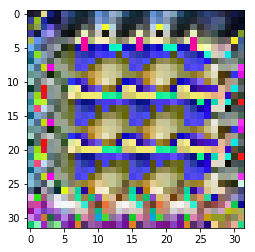

In [25]:
# take a look at the fake image
plt.imshow(test_fake_input.cpu().data.numpy()[0].transpose(1,2,0))